# Model Evaluation

The purpose of this notebook is to evaluate the accuracy and utility of the models. It's a lengthy notebook because it involves several different types of analyses

In [1]:
SHOW_TEST = True
GTDB_TAXONOMY_TABLE = '../data/references/all_taxonomy_r214.tsv'
OVERWRITE_TEST_TRAIN = True
TRAINING_DATA_TSV = '../data/training_data/training_data.tsv' 
STANDARD_AMINO_ACIDS = list({'I', 'H', 'Y', 'R', 'G', 'K', 'Q', 'C', 'E', 'N', 'S', 'L', 'M', 'D', 'T', 'W', 'A', 'F', 'P', 'V'})
PATH_TO_HOLDOUTS = '../data/holdouts/'
PATH_TO_DATA_DIR = '../'

RANKS_TO_TEST = [ 'phylum', 'class', 'order', 'family', 'genus', 'species'] #, 'genome']
conditions = ['oxygen', 'temperature','salinity', 'ph']
# TEMP
# PATH_TO_HOLDOUTS = '..'

In [2]:
units = {
    'temperature' : u'\N{DEGREE SIGN}C',
    'ph' : 'pH',
    'salinity' : '% w/v NaCl',
    'oxygen' : 'Probability Oxygen Tolerant'
}

plot_formats = {
    'oxygen' : 'Oxygen',
    'temperature' : 'Temperature',
    'ph' : 'pH',
    'salinity' : 'Salinity',
    'temperature_optimum' : 'Temperature, Optimum ',
    'ph_optimum' : 'pH, Optimum',
    'salinity_optimum' : 'Salinity, Optimum',
    'temperature_min' : 'Temperature, Minimum',
    'salinity_min' : 'Salinity, Minimum',
    'ph_min' : 'pH, Minimum',
    'temperature_max' : 'Temperature, Maximum',
    'salinity_max' : 'Salinity, Maximum',
    'ph_max' : 'pH, Maximum',
}


rename_estimator = {
        
            'lasso' : 'Lasso Regression',
            'linearregression' : 'Linear Regression',
            'logisticregression' : 'Logistic Classification',
            'selectkbest' : 'best 20 f-stats'
            
        }

In [3]:

import joblib
import json
import sys 
from collections import defaultdict, Counter
from datetime import datetime
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import string

import numpy as np
import pandas as pd
from matplotlib import cm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, f1_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    mean_squared_error,
    r2_score,
)
from sklearn.pipeline import make_pipeline

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("../")
from genome_spot.helpers import rename_condition_to_variable, prepend_features, split_train_and_test_data, load_train_and_test_sets, load_cv_sets

from genome_spot.taxonomy.taxonomy import TaxonomyGTDB
from genome_spot.taxonomy.partition import PartitionTaxa
from genome_spot.taxonomy.balance import BalanceTaxa
from genome_spot.model_training.download_trait_data import ComputeBacDiveTraits
from genome_spot.model_training.run_model_selection import ModelSelection, BASE_VARS_AAS, BASE_VARS_DERIVED_GENOME, BASE_VARS_DERIVED_PROTEIN, BASE_VARS_PIS
from genome_spot.model_training.train_models import  yield_cv_sets, predict_training_and_cv, score_regression
from genome_spot.model_training.make_holdout_sets import make_cv_sets_by_phylogeny

plt.rcParams['svg.fonttype'] = 'none'
plt.style.use('project.mplstyle')
rng = np.random.default_rng(0)


In [4]:
FEATURE_SETS = ModelSelection().generate_named_feature_sets()

def score_classification(y_true, y_pred_probs, p_threshold=0.5):
    y_pred = y_pred_probs > p_threshold
    conf = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf.ravel()
    specificity = tp / (tp + fp)
    sensitivity = tp / (tp + fn)
    f1 = f1_score(y_true, y_pred)
    statistics = {
        "f1": np.mean(f1),
        "specificity": np.mean(specificity),
        "sensitivity": np.mean(sensitivity),
    }
    return statistics

def clean_cv_sets(cv_sets):
    # if a cv_set is missing a set
    cleaned_cv_sets = []
    for training_indices, validation_indices in cv_sets:
        if len(training_indices) > 0 and len(validation_indices) > 0 :
            cleaned_cv_sets.append((training_indices, validation_indices))
    return cleaned_cv_sets

In [5]:
df = pd.read_csv(TRAINING_DATA_TSV, index_col=0, sep='\t')
conditions = [ 'oxygen', 'temperature', 'salinity', 'ph', ]

In [6]:
# stats on modeling
sers = []
for condition in conditions:
    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    target = rename_condition_to_variable(condition)
    ser = df.loc[train_set + test_set, [target]].describe()
    sers.append(ser)

pd.concat(sers, axis=1)

oxygen  temperature_optimum  salinity_optimum  ph_optimum
count  3646.000000          1722.000000        593.000000  756.000000
mean      0.652496            33.031088          4.294144    7.244411
std       0.476243            12.779956          6.254655    1.429781
min       0.000000             4.000000          0.000000    1.100000
25%       0.000000            27.500000          0.000000    6.750000
50%       1.000000            30.000000          2.000000    7.250000
75%       1.000000            35.000000          4.750000    7.800000
max       1.000000           105.000000         27.468210   12.000000

# Model Selection

## Load model selection data

In [287]:
import joblib
import io
import sys


rename_feature_sets = {
    'all' : 'All',
    'aas' : 'AAs',
    'pis' : 'pIs',
    'derived' : 'Deriv',
    
}

rename_localizations = {
    'by_compartment' : 'Extracellular, Intracellular, Membrane',
    'diff_compartment' : 'Difference Extra. vs Intra.',
    '' : 'No Localization'
}

def format_params(params):
    # Convert classses/functions into strings
    output = io.StringIO()
    sys.stdout = output
    print([tup[1] for tup in params['steps']])
    sys.stdout = sys.__stdout__
    printed_string = output.getvalue()
    printed_string = printed_string.replace('\n', '').replace('  ', '')[1:-1]
    printed_string = printed_string.replace("<function mutual_info_regression at 0x13ff9ba60>", "mutual_info_regression")
    printed_string = printed_string.replace("<function f_regression at 0x13ff8c310>", "f_regression")
    return printed_string

#localization_names = ['Whole Cell', 'By Localization', 'Extracellular - Intracellular']
def load_results_to_df(condition):
    scores_by_model = dict()
    print()
    print(condition)
    for i, filename in enumerate(sorted(glob(f'../data/model_selection/{condition}*.json'))):
        with open(filename) as fh:
            data = json.loads(fh.read())
    
        #print(data['model_file'])
        params = joblib.load(PATH_TO_DATA_DIR + data['model_file']).get_params()
        model_type = params['steps'][-1][0]
        feature_set = data['feature_set']
        if condition == 'oxygen':
            score = data['performance']['f1']
        else: 
            score = data['performance']['r2']
    
        localization = '_'.join(feature_set.split('_')[1:])
        #print(localization)
        feature_name = rename_feature_sets[feature_set.split('_')[0]]
        localization_name = rename_localizations[localization]
        printed_string = format_params(params)
        
        scores_by_model[i] = {
            'model_type' : model_type,
            'feature_set' : feature_set,
            'localization' : localization,
            'feature_name' : feature_name,
            'localization_name' : localization_name,
            'score' : score,
            'pipeline_filename' : data['model_file'],
            'parameters' : printed_string
        }
    
    results_df = pd.DataFrame(scores_by_model).T
    return  results_df

dfs = []
for condition in conditions:
    results_df = load_results_to_df(condition)
    results_df['target'] = rename_condition_to_variable(condition)
    dfs.append(results_df)

results_df = pd.concat(dfs,axis=0)
results_df['target'].value_counts()
#results_df['index'] = results_df_index
results_df

model_type feature_set localization feature_name  \
0            gaussiannb         aas                       AAs   
1            gaussiannb         aas                       AAs   
2    logisticregression         aas                       AAs   
3    logisticregression         aas                       AAs   
4    logisticregression         aas                       AAs   
..                  ...         ...          ...          ...   
247               ridge         all                       All   
248               ridge         all                       All   
249               ridge         all                       All   
250               ridge         all                       All   
251               ridge         all                       All   

    localization_name     score  \
0     No Localization  0.815738   
1     No Localization  0.815738   
2     No Localization   0.95713   
3     No Localization  0.957104   
4     No Localization  0.957738   
..                ...       ...   
247   No Localization  0.199421   
248   No Localization  0.236799   
249   No Localization  0.202116   
250   No Localization  0.227266   
251   No Localization  0.204525   

                                     pipeline_filename  \
0    data/model_selection/oxygen_features0_pipeline...   
1    data/model_selection/oxygen_features0_pipeline...   
2    data/model_selection/oxygen_features0_pipeline...   
3    data/model_selection/oxygen_features0_pipeline...   
4    data/model_selection/oxygen_features0_pipeline...   
..                                                 ...   
247  data/model_selection/ph_optimum_features9_pipe...   
248  data/model_selection/ph_optimum_features9_pipe...   
249  data/model_selection/ph_optimum_features9_pipe...   
250  data/model_selection/ph_optimum_features9_pipe...   
251  data/model_selection/ph_optimum_features9_pipe...   

                                            parameters      target  
0    StandardScaler(), SelectKBest(k=20, score_func...      oxygen  
1    StandardScaler(), SelectKBest(k=20, score_func...      oxygen  
2    StandardScaler(), SelectKBest(k=20, score_func...      oxygen  
3    StandardScaler(), SelectKBest(k=20, score_func...      oxygen  
4    StandardScaler(), SelectKBest(k=20, score_func...      oxygen  
..                                                 ...         ...  
247  StandardScaler(), SelectKBest(k=20, score_func...  ph_optimum  
248  StandardScaler(), SelectKBest(k=20, score_func...  ph_optimum  
249  StandardScaler(), SelectKBest(k=20, score_func...  ph_optimum  
250  StandardScaler(), SelectKBest(k=20, score_func...  ph_optimum  
251  StandardScaler(), SelectKBest(k=20, score_func...  ph_optimum  

[960 rows x 9 columns]

In [288]:
results_df['model_type'] = pd.Categorical(results_df['model_type'], 
                      categories=["linearregression", "lasso", "ridge", "mlpregressor",  "logisticregression", "gaussiannb", "svc", ],
                      ordered=True)

In [289]:
# Get baseline for cross-validation
baseline_results = defaultdict(dict)
for condition in conditions:

    if condition == 'oxygen':
        method = 'binary_mode'
    else:
        method = 'average'
    
    target = rename_condition_to_variable(condition)
    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    df_train = df.loc[train_set]
    
    
    for rank in RANKS_TO_TEST:
        
        print(condition, rank)
        #cv_sets = clean_cv_sets(taxonomic_cv_sets_dict[condition][rank])
        #train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
        #target = rename_condition_to_variable(condition)
        #for partition_rank in ["phylum", "class", "order", "family", "genus", "species"]:
        cv_sets = load_cv_sets(condition,PATH_TO_HOLDOUTS, rank)
        y_pred = []
        y_train = []
        for cv_set in cv_sets:
        
            # setup 
            training_indices, validation_indices = cv_set
            df_train_fold = df_train.iloc[training_indices]
            df_valid_fold = df_train.iloc[validation_indices]
            y_train_fold = df_train_fold[target]
            y = np.mean(y_train_fold)
            if method == 'average':
                y_pred.extend([y] * len(validation_indices))
            elif method == 'binary_mode':
                if y >= 0.5:
                    y = 1
                else:
                    y = 0
                y_pred.extend([y] * len(validation_indices))

            fold_y_train = df_valid_fold[target].tolist()
            y_train.extend(fold_y_train)
        baseline_results[target][rank] = {
                    'y_train' : np.array(y_train),
                    'y_valid_pred' : y_pred,
                }
        
#baseline_results

## All model results

In [290]:
import seaborn as sns

fig, axes = plt.subplots(1,4,figsize=(14,9))
for n, condition in enumerate(conditions):
    ax=axes[n]
    target = rename_condition_to_variable(condition)
    group = results_df[results_df['target'] == target].copy().sort_values(['model_type', 'feature_name'])
    y_train = baseline_results[target][rank]['y_train']
    y_valid_pred = np.array(baseline_results[target][rank]['y_valid_pred'])
    not_nan = ~np.isnan(y_valid_pred)
    if condition == 'oxygen':
        group['model_type'] = pd.Categorical(group['model_type'],  categories=["logisticregression", "gaussiannb", "svc", ],ordered=True)
        y_baseline = f1_score(y_train[not_nan], y_valid_pred[not_nan] > 0.5)
        ax.set_ylabel('F1')
    else:
        group['model_type'] = pd.Categorical(group['model_type'],  categories=["linearregression", "lasso", "ridge", "mlpregressor"],ordered=True)
        y_baseline = r2_score(y_train[not_nan], y_valid_pred[not_nan])
        ax.set_ylabel('R$^2$')

    ax.text(-0.2, 1.05, f"{string.ascii_uppercase[n]}.", transform=ax.transAxes,  size=14)
    sns.stripplot(ax=ax, data=group, x='feature_set', y='score',  hue='model_type', palette=['black', 'tomato',  'cornflowerblue', 'orange',],
                  dodge=True)
    ax.axhline(y=y_baseline, linestyle='--', color='gray', label='baseline')
    
    xticklabels = ax.get_xticklabels()
    feature_sets = [rename_feature_sets[label.get_text().split('_')[0]] for label in xticklabels]
    localizations = [rename_localizations['_'.join(label.get_text().split('_')[1:])] for label in xticklabels]
    xticklabels = [f"{l} {f}" for f, l in zip(feature_sets, localizations)]

    ax.set_title(f"Models for {plot_formats[condition]}")
    ax.set_xticklabels(xticklabels, rotation=90)
    ax.legend(loc='lower left')
    if condition == 'ph':
        ax.legend(loc='upper right')
    ax.set_ylim([-0.2,1])

plt.tight_layout()

/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_56787/2991008504.py:21: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.stripplot(ax=ax, data=group, x='feature_set', y='score',  hue='model_type', palette=['black', 'tomato',  'cornflowerblue', 'orange',],
/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_56787/2991008504.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels, rotation=90)
/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_56787/2991008504.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels, rotation=90)
/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_56787/2991008504.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels, rotation=90)
/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_56787/29

In [293]:
results_df['score_type'] = ['f1' if target == 'oxygen' else 'r2' for target in results_df['target']]
results_df

model_type feature_set localization feature_name  \
0            gaussiannb         aas                       AAs   
1            gaussiannb         aas                       AAs   
2    logisticregression         aas                       AAs   
3    logisticregression         aas                       AAs   
4    logisticregression         aas                       AAs   
..                  ...         ...          ...          ...   
247               ridge         all                       All   
248               ridge         all                       All   
249               ridge         all                       All   
250               ridge         all                       All   
251               ridge         all                       All   

    localization_name     score  \
0     No Localization  0.815738   
1     No Localization  0.815738   
2     No Localization   0.95713   
3     No Localization  0.957104   
4     No Localization  0.957738   
..                ...       ...   
247   No Localization  0.199421   
248   No Localization  0.236799   
249   No Localization  0.202116   
250   No Localization  0.227266   
251   No Localization  0.204525   

                                     pipeline_filename  \
0    data/model_selection/oxygen_features0_pipeline...   
1    data/model_selection/oxygen_features0_pipeline...   
2    data/model_selection/oxygen_features0_pipeline...   
3    data/model_selection/oxygen_features0_pipeline...   
4    data/model_selection/oxygen_features0_pipeline...   
..                                                 ...   
247  data/model_selection/ph_optimum_features9_pipe...   
248  data/model_selection/ph_optimum_features9_pipe...   
249  data/model_selection/ph_optimum_features9_pipe...   
250  data/model_selection/ph_optimum_features9_pipe...   
251  data/model_selection/ph_optimum_features9_pipe...   

                                            parameters      target score_type  
0    StandardScaler(), SelectKBest(k=20, score_func...      oxygen         f1  
1    StandardScaler(), SelectKBest(k=20, score_func...      oxygen         f1  
2    StandardScaler(), SelectKBest(k=20, score_func...      oxygen         f1  
3    StandardScaler(), SelectKBest(k=20, score_func...      oxygen         f1  
4    StandardScaler(), SelectKBest(k=20, score_func...      oxygen         f1  
..                                                 ...         ...        ...  
247  StandardScaler(), SelectKBest(k=20, score_func...  ph_optimum         r2  
248  StandardScaler(), SelectKBest(k=20, score_func...  ph_optimum         r2  
249  StandardScaler(), SelectKBest(k=20, score_func...  ph_optimum         r2  
250  StandardScaler(), SelectKBest(k=20, score_func...  ph_optimum         r2  
251  StandardScaler(), SelectKBest(k=20, score_func...  ph_optimum         r2  

[960 rows x 10 columns]

In [294]:
cols_to_save = ['target', 'model_type', 'feature_name', 'localization_name', 'score', 'score_type', 'parameters'] #'feature_set', 'localization',
#results_df = 
results_df.loc[:, cols_to_save].set_index('target').to_csv('supplementary_data_3.tsv', sep='\t')

## Select and Save

In [12]:
whole_cell = ''
select_models =  {
     'temperature' : ('aas', 'by_compartment', 'lasso'),
    'ph' : ('aas', 'by_compartment', 'lasso'),
    # 'temperature' : ('aas', whole_cell, 'lasso'), # consider changing models
    # 'ph' : ('aas', 'diff_compartment', 'linearregression'),
    'salinity' : ('aas', 'by_compartment', 'lasso'), # consider changing features
    'oxygen' : ('aas', whole_cell, 'logisticregression'),
}
select_models

{'temperature': ('aas', 'by_compartment', 'lasso'),
 'ph': ('aas', 'by_compartment', 'lasso'),
 'salinity': ('aas', 'by_compartment', 'lasso'),
 'oxygen': ('aas', '', 'logisticregression')}

In [13]:
feature_set_dict = dict(FEATURE_SETS)

training_instructions = {}
for condition, model_specs in select_models.items():
    result = load_results_to_df(condition)
    selected_feature_type, selected_localization, selected_model = model_specs

    if len(selected_localization) > 0:
        selected_feature_set = '_'.join([selected_feature_type, selected_localization])
    else:
        selected_feature_set = selected_feature_type
    print(condition, model_specs)
    
    result = result[
        (result['feature_set'] == selected_feature_set) & 
        (result['localization'] == selected_localization) & 
        (result['model_type'] == selected_model)
    ]
    
    idx_best = result[['score']].astype('float').idxmax()[0]
    print(idx_best)
    print(condition, result[['score']].astype('float'))
    
    best = result.loc[idx_best]
    print(condition, best)
    print(condition, best.loc['pipeline_filename'])
    training_instructions[condition] = {
        'feature_set' : rename_feature_sets[selected_feature_type],
        'localization' : rename_localizations[selected_localization],
        'features' : feature_set_dict[selected_feature_set],
        'pipeline_filename' : best['pipeline_filename'],
        #'model_type' : 
        
    }

    print(len(feature_set_dict[selected_feature_set]))

OVERWRITE_MODEL_INSTUCTIONS = False
if OVERWRITE_MODEL_INSTUCTIONS is True:
    json.dump(training_instructions, open("../models/instructions.json", "w"))
training_instructions


temperature
temperature ('aas', 'by_compartment', 'lasso')
71
temperature        score
71  0.761061
72  0.760980
73  0.738417
74  0.586584
temperature model_type                                                       lasso
feature_set                                         aas_by_compartment
localization                                            by_compartment
feature_name                                                       AAs
localization_name               Extracellular, Intracellular, Membrane
score                                                         0.761061
pipeline_filename    data/model_selection/temperature_optimum_featu...
Name: 71, dtype: object
temperature data/model_selection/temperature_optimum_features1_pipeline16-lasso.joblib
60

ph
ph ('aas', 'by_compartment', 'lasso')
72
ph        score
71  0.534994
72  0.540952
73  0.407867
74 -0.003033
ph model_type                                                       lasso
feature_set                                       

{'temperature': {'feature_set': 'AAs',
  'localization': 'Extracellular, Intracellular, Membrane',
  'features': ['extracellular_soluble_aa_A',
   'extracellular_soluble_aa_C',
   'extracellular_soluble_aa_D',
   'extracellular_soluble_aa_E',
   'extracellular_soluble_aa_F',
   'extracellular_soluble_aa_G',
   'extracellular_soluble_aa_H',
   'extracellular_soluble_aa_I',
   'extracellular_soluble_aa_K',
   'extracellular_soluble_aa_L',
   'extracellular_soluble_aa_M',
   'extracellular_soluble_aa_N',
   'extracellular_soluble_aa_P',
   'extracellular_soluble_aa_Q',
   'extracellular_soluble_aa_R',
   'extracellular_soluble_aa_S',
   'extracellular_soluble_aa_T',
   'extracellular_soluble_aa_V',
   'extracellular_soluble_aa_W',
   'extracellular_soluble_aa_Y',
   'intracellular_soluble_aa_A',
   'intracellular_soluble_aa_C',
   'intracellular_soluble_aa_D',
   'intracellular_soluble_aa_E',
   'intracellular_soluble_aa_F',
   'intracellular_soluble_aa_G',
   'intracellular_soluble_aa_H'

# Generate Data for Analyses

In [14]:
# Load training instructions
training_instructions = json.loads(open("../models/instructions.json", "r").read())
training_instructions.keys()

dict_keys(['temperature', 'ph', 'salinity', 'oxygen'])

In [15]:
taxonomy = TaxonomyGTDB()
phylum_dict = {k : v[1] for k, v in taxonomy.taxonomy_dict.items()}
taxon_to_accessions = defaultdict(list)
for acc, taxon in phylum_dict.items():
    taxon_to_accessions[taxon].append(acc)

In [16]:
# Load CV sets

taxonomic_cv_sets_dict = defaultdict(dict)
for condition in conditions:
    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    target = rename_condition_to_variable(condition)
    for partition_rank in ["phylum", "class", "order", "family", "genus", "species"]:
        cv_sets = load_cv_sets(condition,PATH_TO_HOLDOUTS, partition_rank)
        for train, val in cv_sets[0:1]:
            print(target, len(train) + len(val))
        taxonomic_cv_sets_dict[condition][partition_rank] = cv_sets
    print(condition, len(cv_sets[0][0]) + len(cv_sets[0][1]) )

len(taxonomic_cv_sets_dict['oxygen']['class'])

oxygen 2727
oxygen 2727
oxygen 2727
oxygen 2727
oxygen 2727
oxygen 2727
oxygen 2727
temperature_optimum 1376
temperature_optimum 1376
temperature_optimum 1376
temperature_optimum 1376
temperature_optimum 1376
temperature_optimum 1376
temperature 1376
salinity_optimum 473
salinity_optimum 473
salinity_optimum 473
salinity_optimum 473
salinity_optimum 473
salinity_optimum 473
salinity 473
ph_optimum 603
ph_optimum 603
ph_optimum 603
ph_optimum 603
ph_optimum 603
ph_optimum 603
ph 603


5

## Models

In [24]:
# Record results from models at all holdout levels

def load_results_from_model_eval_dict(target, rank, taxonomic_model_eval_dict):
    results_dict = taxonomic_model_eval_dict[target][rank]
    y_train = results_dict.get('y_train', [])
    y_train_pred = results_dict.get('y_train_pred', [])
    y_valid_pred = results_dict.get('y_valid_pred', [])
    y_test = results_dict.get('y_test', [])
    y_test_pred = results_dict.get('y_test_pred', [])
    return y_train, y_train_pred, y_valid_pred, y_test, y_test_pred

taxonomic_model_eval_dict = defaultdict(dict)
for condition in ['oxygen', 'temperature', 'ph', 'salinity']:
    #for rank in ['family']:
    for rank in RANKS_TO_TEST:
        
        if condition in ['temperature', 'ph', 'salinity']:
            method = 'predict'
            attributes = ['optimum', 'min', 'max']
        elif condition == 'oxygen':
            method = 'predict_proba'
            attributes = ['']

        #for n, target_attr in enumerate(['optimum']):
        for n, target_attr in enumerate(attributes):
            
            if condition == 'oxygen':
                target = 'oxygen'
            else:
                target = rename_condition_to_variable(condition, target_attr)
            print(target, rank)
            features = training_instructions[condition]['features']
            train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
            cv_sets = clean_cv_sets(taxonomic_cv_sets_dict[condition][rank])
            pipeline_filename = PATH_TO_DATA_DIR + training_instructions[condition]['pipeline_filename']
            pipe = joblib.load(pipeline_filename)
            pipe[-1].max_iter = 50000
        
            #print('train')
            df_train = df.loc[train_set].copy()
            X_train = df_train[features]
            y_train = df_train[target]
            
            if condition == 'oxygen':
                pipe, y_train_pred, y_valid_pred = predict_training_and_cv(X_train, y_train, pipeline=pipe, cv=yield_cv_sets(cv_sets), method='predict_proba')
            else:
                pipe, y_train_pred, y_valid_pred = predict_training_and_cv(X_train, y_train, pipeline=pipe, cv=yield_cv_sets(cv_sets), method='predict')
            pipe.fit(X_train, y_train)

            #print('test')
            df_test = df.loc[test_set].copy()
            X_test = df_test[features]
            y_test = df_test[target]
            if condition == 'oxygen':
                y_test_pred = pipe.predict_proba(X_test)    
            else:
                y_test_pred = pipe.predict(X_test)    
            
            results_dict = {
                'y_train' : y_train.values,
                'y_train_pred' : y_train_pred,
                'y_valid_pred' : y_valid_pred,
                'y_test' : y_test.values,
                'y_test_pred' : y_test_pred,
            }
    
            taxonomic_model_eval_dict[target][rank] = results_dict
                

taxonomic_model_eval_dict['salinity_optimum']['family'].keys()

oxygen phylum
oxygen class
oxygen order
oxygen family
oxygen genus
oxygen species
temperature_optimum phylum
temperature_min phylum


/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.489e+01, tolerance: 1.383e+01
  model = cd_fast.enet_coordinate_descent(


temperature_max phylum


/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.383e+01, tolerance: 2.087e+01
  model = cd_fast.enet_coordinate_descent(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.383e+01, tolerance: 2.087e+01
  model = cd_fast.enet_coordinate_descent(


temperature_optimum class
temperature_min class
temperature_max class


/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.383e+01, tolerance: 2.087e+01
  model = cd_fast.enet_coordinate_descent(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.383e+01, tolerance: 2.087e+01
  model = cd_fast.enet_coordinate_descent(


temperature_optimum order
temperature_min order
temperature_max order


/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.299e+01, tolerance: 1.656e+01
  model = cd_fast.enet_coordinate_descent(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.383e+01, tolerance: 2.087e+01
  model = cd_fast.enet_coordinate_descent(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:63

temperature_optimum family
temperature_min family
temperature_max family


/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.383e+01, tolerance: 2.087e+01
  model = cd_fast.enet_coordinate_descent(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.383e+01, tolerance: 2.087e+01
  model = cd_fast.enet_coordinate_descent(


temperature_optimum genus
temperature_min genus
temperature_max genus


/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.006e+01, tolerance: 1.592e+01
  model = cd_fast.enet_coordinate_descent(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.383e+01, tolerance: 2.087e+01
  model = cd_fast.enet_coordinate_descent(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:63

temperature_optimum species
temperature_min species
temperature_max species


/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.091e+02, tolerance: 1.637e+01
  model = cd_fast.enet_coordinate_descent(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.383e+01, tolerance: 2.087e+01
  model = cd_fast.enet_coordinate_descent(
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:63

ph_optimum phylum
ph_min phylum
ph_max phylum
ph_optimum class
ph_min class
ph_max class
ph_optimum order
ph_min order
ph_max order
ph_optimum family
ph_min family
ph_max family
ph_optimum genus
ph_min genus
ph_max genus
ph_optimum species
ph_min species
ph_max species
salinity_optimum phylum
salinity_min phylum
salinity_max phylum
salinity_optimum class
salinity_min class
salinity_max class
salinity_optimum order
salinity_min order
salinity_max order
salinity_optimum family
salinity_min family
salinity_max family
salinity_optimum genus
salinity_min genus
salinity_max genus
salinity_optimum species
salinity_min species
salinity_max species


dict_keys(['y_train', 'y_train_pred', 'y_valid_pred', 'y_test', 'y_test_pred'])

## Phylogeny-based Model

In [25]:
# Returns a match to a query 
from collections import defaultdict

taxonomy = TaxonomyGTDB()
taxonomy_dict = taxonomy.taxonomy_dict

def make_sorted_taxonomy(genomes, taxonomy_dict):

    taxonomy_list = []
    for genome in genomes:
        taxonomy = taxonomy_dict.get(genome, None)
        if taxonomy:
            taxonomy_list.append(list(taxonomy) + [genome])
    
    sorted_taxonomy = sorted(taxonomy_list)
    return sorted_taxonomy

def find_match_to_query(query, sorted_taxonomy,
                        required_novelty = 'genome',
                        required_similarity = 'phylum',):

                        
    def _count_shared_ranks(query, comparison):
        return sum([i == j for i, j in zip(query[:-1], comparison[:-1])])

    max_shared = ranks.index(required_novelty) + 1
    
    query_index = sorted_taxonomy.index(query)
    up_index = query_index - 1
    down_index = query_index + 1
    selection = None
    while selection is None:
        up_taxonomy = sorted_taxonomy[max([up_index, 0])]
        down_taxonomy = sorted_taxonomy[min([down_index, len(sorted_taxonomy) - 1])]
        up_shared = _count_shared_ranks(query, up_taxonomy)
        down_shared = _count_shared_ranks(query, down_taxonomy)
        if up_shared >= down_shared and up_shared <= max_shared:
            selection = up_taxonomy
        elif down_shared >= up_shared and down_shared <= max_shared:
            selection = down_taxonomy
        elif up_index < 0 and down_index >=  len(sorted_taxonomy) - 1:
            return None
        else:
            up_index -= 1
            down_index += 1

    min_shared = ranks.index(required_similarity) + 1
    if _count_shared_ranks(query, selection) < min_shared:
        return None
    else:
        return selection

# PER CV basis
def make_nearest_neighbors_dicts(sampled_genomes, taxonomy_dict):
    nearest_neighbors_dicts = defaultdict(dict)
    for rank in RANKS_TO_TEST:
        sorted_taxonomy = make_sorted_taxonomy(sampled_genomes, taxonomy_dict)
        ranks = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'genome']
        closest_relative = {}
        for n, query in enumerate(sorted_taxonomy):
            match = find_match_to_query(query, sorted_taxonomy, required_novelty = rank, required_similarity = 'domain')
            if match:
                if query[-1] != match[-1]:
                    closest_relative[query[-1]] = match[-1]
        
        nearest_neighbors_dicts[condition][rank] = closest_relative
    return nearest_neighbors_dicts

taxonomy = TaxonomyGTDB()

In [26]:

def taxonomy_lists_for_genomes(genomes):
    taxonomy_lists = []
    for genome in genomes:
        taxlist = taxonomy_dict.get(genome, None)
        if taxlist:
            taxonomy_lists.append(list(taxlist) + [genome])
    return taxonomy_lists

def make_children_dict(taxonomy_lists):
    children_dict = defaultdict(set)
    for idx in list(taxonomy.indices.values())[:-1]:
        for taxlist in taxonomy_lists:
            children_dict[taxlist[idx]].add(taxlist[idx+1])
    return children_dict

def make_parent_dict(taxonomy_lists):
    parent_dict = dict()
    for idx in list(taxonomy.indices.values())[:-1]:
        for taxlist in taxonomy_lists:
            parent_dict[taxlist[idx+1]] = taxlist[idx]
    return parent_dict

def make_sibling_taxa_dict(children_dict):
    sibling_taxa_sets = [taxa for taxa in children_dict.values()] + [{'Bacteria', 'Archaea'}]
    sister_taxa_dict = {taxon : taxa.difference(set([taxon]))  for taxa in sibling_taxa_sets for taxon in taxa}
    return sister_taxa_dict

taxonomy.index_to_rank = {v : k for k, v in taxonomy.indices.items()}
taxonomy.index_to_rank 


def fit_closest_relative_model(df_train_fold, sister_taxa_dict, parent_dict, taxonomy, method):
    #### lookup sister taxa and get genomes
    # just use dataframe to avoid a massive dictionary?
    value_of_sisters = {} # taxon : value of sisters
    # The data in the model to be referenced
    for rank_idx in taxonomy.indices.values():
        rank = taxonomy.index_to_rank[rank_idx]
        for taxon in df_train_fold[rank].drop_duplicates().dropna():
            # Get sisters of taxon at initial rank
            try_rank_idx = rank_idx
            rank = taxonomy.index_to_rank[try_rank_idx]
            sisters = sister_taxa_dict[taxon]
            # If no sisters, see if parents have sisters; repeat as needed
            if len(sisters) == 0:
                while len(sisters) == 0:
                    if try_rank_idx > 0: 
                        #print(try_rank_idx, rank,len(sisters), taxon, parent_dict[taxon],  )
                        try_rank_idx -= 1  # move up
                        rank = taxonomy.index_to_rank[try_rank_idx]
                        taxon = parent_dict[taxon]
                        sisters = sister_taxa_dict[taxon]      
                        #print('p', try_rank_idx, rank,len(sisters), taxon, parent_dict[taxon],  )
                    else:
                        break
            try:
                Y = df_train_fold[df_train_fold[rank].isin(sisters)][target].dropna().values
                if method == 'random':
                    value_of_sisters[taxon] = rng.choice(Y, size=1)[0]
                elif method == 'average':
                    value_of_sisters[taxon] = np.mean(Y)
                elif method == 'binary_mode':
                    # for oxygen
                    if np.mean(Y) >= 0.5:
                        value_of_sisters[taxon] = 1
                    else:
                        value_of_sisters[taxon] = 0
            except:
                pass
                #print('FAILED', taxon)
        
    return value_of_sisters




def predict_closest_relative_model(genomes, model):
    arr = []
    for genome in genomes:
        taxlist = taxonomy.taxonomy_dict.get(genome, None)
        if taxlist:            
            taxlist = taxonomy.taxonomy_dict[genome]
            taxon_found = False
            for taxon in taxlist[::-1]:
                if taxon in model.keys():
                    arr.append(model[taxon])
                    taxon_found = True
                    break
            if taxon_found is False:
                arr.append(np.nan)
        else:
            arr.append(np.nan)
    return np.array(arr)

def random_predict_closest_relative_model(genomes, target, average_close_relative, df_train_fold, sister_taxa_dict):
    arr = []
    for genome in genomes:
        
        taxlist = taxonomy.taxonomy_dict.get(genome, None)
        if taxlist:
            taxon_found = False
            for taxon, rank_idx in list(zip(taxlist, range(0, len(taxlist))))[::-1]:
                if rank_idx < 7:
                    if taxon in average_close_relative.keys():
                        #print(taxon)
                        rank = taxonomy.index_to_rank[rank_idx]
                        sisters = sister_taxa_dict[taxon]
                        Y = df_train_fold[df_train_fold[rank].isin(sisters)][target].dropna().values
                        try:
                            y = rng.choice(Y, size=1)[0]
                        except:
                            y = np.nan
                        arr.append(y)
                        taxon_found = True
                        break
            if taxon_found is False:
                arr.append(np.nan)
        else:
            arr.append(np.nan)
    return np.array(arr)

In [27]:
average_closest_relative_results = defaultdict(dict)
random_closest_relative_results = defaultdict(dict)
    
for condition in conditions:
#for condition in ['salinity']:
    
    target = rename_condition_to_variable(condition)
    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    df_train = df.loc[train_set]

    #for rank in ['phylum']:
    for rank in RANKS_TO_TEST:
        
        print(condition, rank)
        cv_sets = clean_cv_sets(taxonomic_cv_sets_dict[condition][rank])
        y_train = []
        y_pred_average = []
        y_pred_random = []
        for cv_set in cv_sets:
        
            # setup 
            training_indices, validation_indices = cv_set
           #print(len(training_indices), len(validation_indices), len(training_indices) + len(validation_indices))
            df_train_fold = df_train.iloc[training_indices]
            df_valid_fold = df_train.iloc[validation_indices]
            train_genomes = df_train_fold.index
            valid_genomes = df_valid_fold.index
            taxonomy_lists = taxonomy_lists_for_genomes(train_genomes)
            children_dict = make_children_dict(taxonomy_lists)
            parent_dict = make_parent_dict(taxonomy_lists)
            sister_taxa_dict = make_sibling_taxa_dict(children_dict)        
            
            # fit
            if condition == 'oxygen':
                method = 'binary_mode'
            else:
                method = 'average'
            average_close_relative = fit_closest_relative_model(df_train_fold, sister_taxa_dict, parent_dict, taxonomy, method=method)
            random_close_relative = fit_closest_relative_model(df_train_fold, sister_taxa_dict, parent_dict, taxonomy, method='random')
            
            # predict
            fold_y_train = df_valid_fold[target].tolist()
            fold_y_pred_average = predict_closest_relative_model(valid_genomes, model=average_close_relative)
            fold_y_pred_random = random_predict_closest_relative_model(valid_genomes, target, average_close_relative, df_train_fold, sister_taxa_dict)
            y_train.extend(fold_y_train)
            #print(len(valid_genomes), len(fold_y_pred_average), len(fold_y_pred_random))
            y_pred_average.extend(fold_y_pred_average)
            y_pred_random.extend(fold_y_pred_random)
            
        #print(np.array(y_train).shape, np.array(y_pred_average).shape, np.array(y_pred_random).shape)
        average_closest_relative_results[target][rank] = {
                    'y_train' : np.array(y_train),
                    'y_valid_pred' : np.array(y_pred_average),
                }
        
        random_closest_relative_results[target][rank] = {
                    'y_train' : np.array(y_train),
                    'y_valid_pred' : np.array(y_pred_random),
                }

len(random_closest_relative_results[target].keys())

oxygen phylum


/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


oxygen class
oxygen order
oxygen family
oxygen genus
oxygen species
temperature phylum


/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


temperature class
temperature order
temperature family
temperature genus
temperature species
salinity phylum


/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


salinity class
salinity order
salinity family
salinity genus
salinity species
ph phylum
ph class
ph order
ph family
ph genus
ph species


6

In [28]:
len(random_closest_relative_results[target]['species']['y_train'])

603

# Model Performance

## Performance

In [29]:
# Record scores from models
to_table = {}

rank = 'family'
for condition in conditions:
    instructions = training_instructions[condition]

    if condition in ['temperature', 'ph', 'salinity']:
        targets = [condition + '_' + attr for attr in ['optimum', 'min', 'max']]
    elif condition == 'oxygen':
        targets = ['oxygen']

    print(targets)
    for target in targets:

        y_train, y_train_pred, y_valid_pred, y_test, y_test_pred = load_results_from_model_eval_dict(target, rank, taxonomic_model_eval_dict)
        if condition == 'oxygen':
            target_attr = ''
            f1_train = f1_score(y_train, y_train_pred[:, 1] > 0.5)
            f1_valid = f1_score(y_train, y_valid_pred[:, 1] > 0.5)
            f1_test = f1_score(y_test, y_test_pred[:, 1] > 0.5)
            r2_train = 'n.a.'
            r2_valid = 'n.a.'
            r2_test = 'n.a.'
            rmse_train = 'n.a.'
            rmse_valid = 'n.a.'
            rmse_test ='n.a.'
            f1_baseline = f1_score(y_train, np.ones(y_train.shape))
            r2_baseline = 'n.a.'
            rmse_baseline = 'n.a.'
        else:
            target_attr = target.split('_')[-1]
            r2_train = r2_score(y_train, y_train_pred)    
            r2_valid = r2_score(y_train, y_valid_pred)
            r2_test = r2_score(y_test, y_test_pred)
            rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
            rmse_valid = np.sqrt(mean_squared_error(y_train, y_valid_pred))
            rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
            f1_train = 'n.a.'
            f1_valid = 'n.a.'
            f1_test = 'n.a.'
            f1_baseline = 'n.a.'
            r2_baseline = r2_score(y_train, [np.mean(y_train)] * len(y_train))    
            rmse_baseline = np.sqrt(mean_squared_error(y_train, [np.mean(y_train)] * len(y_train)))


        pipeline_filename = PATH_TO_DATA_DIR + training_instructions[condition]['pipeline_filename']
        pipeline = joblib.load(pipeline_filename)

        
        
        

        
        params = pipeline.get_params()
        estimator = params['steps'][-1][0]
        
        subparams = {}
        if estimator == 'lasso':
            subparams['alpha'] = params['lasso__alpha']
        if params['steps'][1][0] == 'selectkbest':
             subparams['features'] = rename_estimator[params['steps'][1][0]]
        
        
        subdescr = ' '.join([f'{k}={v}' for k, v in subparams.items()])
        descr = f'{rename_estimator[estimator]} ({subdescr})'
        print(descr)

        to_table[(plot_formats[condition], target_attr.capitalize())] = {
            ('Features', 'Type') : instructions['feature_set'],
            ('Features', 'Localization') : instructions['localization'],
            ('Estimator','(Params)') : descr,
            ('Training', 'R$^2$') : r2_train,
            ('Training', 'RMSE') : rmse_train,
            ('Training', 'F1') : f1_train,
            ('Cross-Validation', 'R$^2$') : r2_valid,
            ('Cross-Validation', 'RMSE') : rmse_valid,
            ('Cross-Validation', 'F1') : f1_valid,
            ('Test', 'R$^2$') : r2_test,
            ('Test', 'RMSE') : rmse_test,
            ('Test', 'F1') : f1_test,
            ('Baseline', 'R$^2$') : r2_baseline,
            ('Baseline', 'RMSE') : rmse_baseline,
            ('Baseline', 'F1') : f1_baseline,
            
            
            
            
        }
    

results_table = pd.DataFrame(to_table) #.T
results_table.T

['oxygen']
Logistic Classification (features=best 20 f-stats)
['temperature_optimum', 'temperature_min', 'temperature_max']
Lasso Regression (alpha=0.001)
Lasso Regression (alpha=0.001)
Lasso Regression (alpha=0.001)
['salinity_optimum', 'salinity_min', 'salinity_max']
Lasso Regression (alpha=0.01)
Lasso Regression (alpha=0.01)
Lasso Regression (alpha=0.01)
['ph_optimum', 'ph_min', 'ph_max']
Lasso Regression (alpha=0.01)
Lasso Regression (alpha=0.01)
Lasso Regression (alpha=0.01)


Features                                          \
                        Type                            Localization   
Oxygen                   AAs                         No Localization   
Temperature Optimum      AAs  Extracellular, Intracellular, Membrane   
            Min          AAs  Extracellular, Intracellular, Membrane   
            Max          AAs  Extracellular, Intracellular, Membrane   
Salinity    Optimum      AAs  Extracellular, Intracellular, Membrane   
            Min          AAs  Extracellular, Intracellular, Membrane   
            Max          AAs  Extracellular, Intracellular, Membrane   
pH          Optimum      AAs  Extracellular, Intracellular, Membrane   
            Min          AAs  Extracellular, Intracellular, Membrane   
            Max          AAs  Extracellular, Intracellular, Membrane   

                                                             Estimator  \
                                                              (Params)   
Oxygen               Logistic Classification (features=best 20 f-st...   
Temperature Optimum                     Lasso Regression (alpha=0.001)   
            Min                         Lasso Regression (alpha=0.001)   
            Max                         Lasso Regression (alpha=0.001)   
Salinity    Optimum                      Lasso Regression (alpha=0.01)   
            Min                          Lasso Regression (alpha=0.01)   
            Max                          Lasso Regression (alpha=0.01)   
pH          Optimum                      Lasso Regression (alpha=0.01)   
            Min                          Lasso Regression (alpha=0.01)   
            Max                          Lasso Regression (alpha=0.01)   

                     Training                     Cross-Validation            \
                        R$^2$      RMSE        F1            R$^2$      RMSE   
Oxygen                   n.a.      n.a.  0.961141             n.a.      n.a.   
Temperature Optimum  0.783514  5.797851      n.a.         0.725379  6.530078   
            Min      0.736251  6.646166      n.a.         0.684569  7.268219   
            Max      0.786824  5.685906      n.a.         0.728412  6.417797   
Salinity    Optimum  0.866237  2.313842      n.a.         0.809354  2.762359   
            Min      0.850382  1.605357      n.a.         0.783737  1.930057   
            Max      0.822774  3.820775      n.a.         0.722724  4.779077   
pH          Optimum  0.613787  0.905399      n.a.         0.477367  1.053233   
            Min      0.562473  0.860235      n.a.         0.475772  0.941618   
            Max      0.549286  1.141987      n.a.         0.349939  1.371475   

                                   Test                     Baseline  \
                           F1     R$^2$      RMSE        F1    R$^2$   
Oxygen               0.942585      n.a.      n.a.  0.967312     n.a.   
Temperature Optimum      n.a.  0.715009  7.422059      n.a.      0.0   
            Min          n.a.  0.699233  8.188921      n.a.      0.0   
            Max          n.a.  0.749634  6.744978      n.a.      0.0   
Salinity    Optimum      n.a.  0.683259  3.255933      n.a.      0.0   
            Min          n.a.  0.636298  2.191283      n.a.      0.0   
            Max          n.a.  0.722371  4.522586      n.a.      0.0   
pH          Optimum      n.a.   0.53571  0.892533      n.a.      0.0   
            Min          n.a.  0.490319  0.987044      n.a.      0.0   
            Max          n.a.   0.39518  1.152402      n.a.      0.0   

                                          
                          RMSE        F1  
Oxygen                    n.a.  0.748508  
Temperature Optimum  12.460971      n.a.  
            Min      12.941247      n.a.  
            Max      12.314903      n.a.  
Salinity    Optimum   6.326531      n.a.  
            Min       4.150298      n.a.  
            Max       9.075869      n.a.  
pH          Optimum   1.456888      n.a.  
          

In [21]:
def ax_regression(ax, y_true, y_pred, title):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[1,0]
    ax.scatter(y_true, y_pred, s=20, color='black', alpha=0.5)
    ax.plot([np.min(y_true), np.max(y_true)], [np.min(y_true), np.max(y_true)], color='lightgray')
    ax.set_xlabel('True')
    ax.set_ylabel('Prediction')
    ax.set_title(f'{title}\nR$^2$={r2:.2f} RMSE={rmse:.1f} corr={corr:.2f} n={len(y_true)}')
    return ax

def ax_residual(ax, y_true, y_pred, ):
    X = y_true
    Y = y_true - y_pred
    ax.scatter(X, Y, s=1, color='gray')
    ax.axhline(y=0, color='lightgray')
    ax.set_ylim([-1 * np.abs(np.max(Y)), np.abs(np.max(Y))])
    ax.set_ylabel('Residual')
    return ax

def ax_distribution(ax, y_true, y_pred):
    counts, bins, _ = ax.hist(y_true, bins=50, histtype='step', color='black', label='True')
    ax.hist(y_pred, bins=bins, histtype='step', color='gray', label='Predicted')
    ax.legend(frameon=False)
    ax.set_ylabel('Counts')
    return ax

def plot_regression_training_validation(y_train, y_train_pred, y_valid, y_valid_pred):
    
    fig, axes = plt.subplots(3,2, figsize=(10,10), gridspec_kw={'height_ratios' : (10,4, 2)})
    
    ax = axes[0, 0]
    ax = ax_regression(ax, y_train, y_train_pred, title='Training')
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    
    ax = axes[1,0]
    ax = ax_residual(ax,  y_train, y_train_pred)
    ax.set_xlim(xlims)
    abs_diff = np.max(np.abs(y_train - y_train_pred))
    ax.set_ylim([-1 * abs_diff, 1 * abs_diff])
    
    ax = axes[2,0]
    ax_distribution(ax, y_train, y_train_pred)
    ax.set_xlim(xlims)
    
    ax = axes[0, 1]
    ax = ax_regression(ax, y_valid, y_valid_pred, title='Validation')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    ax = axes[1,1]
    ax = ax_residual(ax, y_valid, y_valid_pred,)
    ax.set_xlim(xlims)
    
    ax.set_ylim([-1 * abs_diff, 1 * abs_diff])
    
    ax = axes[2,1]
    ax_distribution(ax, y_valid, y_valid_pred,)
    ax.set_xlim(xlims)
    return fig, axes

def downsample_distribution_cap(Y, bins, max_fraction_per_bin=0.05):
    # downsampled_indices = downsample_distribution_cap(y_train, bins=50, max_fraction_per_bin=0.05)
    #     X_train = X_train.iloc[downsampled_indices]
    #     y_train = y_train.iloc[downsampled_indices]
    #     cv_sets = make_cv_sets_by_phylogeny(genomes=X_train.index.tolist(), partition_rank=rank, kfold=5)
        
    if bins is None:
        bins = 50
    
    hist, bins = np.histogram(Y, bins=bins)
    if max_fraction_per_bin is None:
        max_fraction_per_bin = len(bins)**-(1/1)
    max_per_bin = int(len(Y) * max_fraction_per_bin)
    
    indices = []
    y_indices = np.array([i for i in range(len(Y))])
    for i, count in enumerate(hist):
        y_bin_indices = y_indices[(Y >= bins[i]) & (Y < bins[i+1])]
        y_sample = rng.choice(y_bin_indices, size=min([len(y_bin_indices), max_per_bin]), replace=False)
        indices.extend(list(y_sample))
        #print(count, y_sample)

    return indices


temperature_optimum
salinity_optimum
ph_optimum


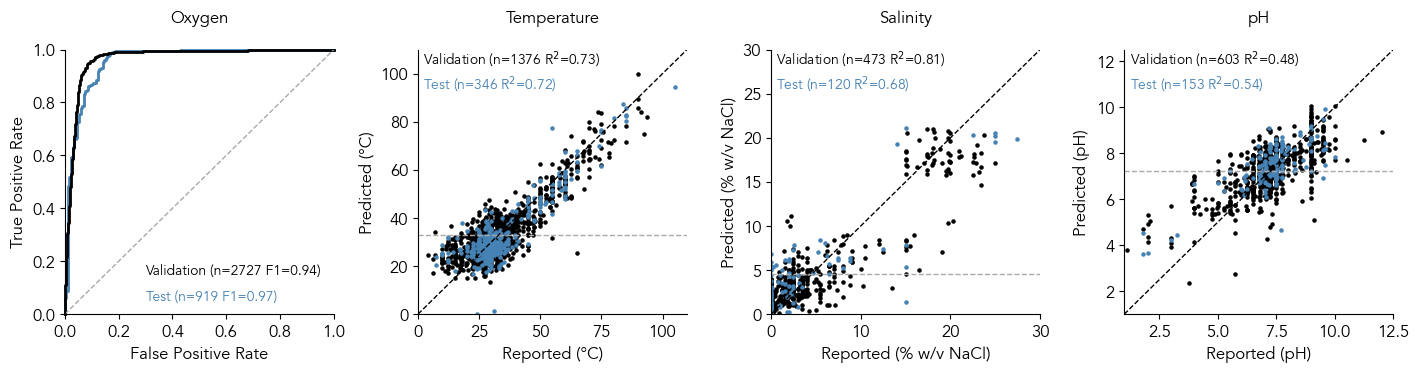

In [23]:
from sklearn.metrics import roc_curve, f1_score

lims_dict = {'temperature' : [0, 110],
         'ph' : [1, 12.5],
         'salinity' : [0, 30],
        }
fontsize=10

def ax_target_regression(ax, target, condition,  show_test=False, lims_dict=lims_dict):

    

    fontsize = 10
    validation_color = 'black'
    test_color = 'steelblue'
    rank = 'family' #'family' 
    shared_kwargs = {'s' : 5,
                        'alpha' : 1,
                        }
    

    y_train, y_train_pred, y_valid_pred, y_test, y_test_pred = load_results_from_model_eval_dict(target, rank, taxonomic_model_eval_dict)
    # features = to_table[(plot_formats[condition], 'Optimum')][('Features', 'Type')]
    # localization = to_table[(plot_formats[condition], 'Optimum')][('Features', 'Localization')]
    # model_name = to_table[(plot_formats[condition], 'Optimum')][('Estimator', '(Params)')].split('(')[0].replace('Regression', 'Regr.')
    lim1, lim2 = lims_dict[condition]
    scores = score_regression(y_train, y_valid_pred)
    rmse, r2, corr = scores['rmse'], scores['r2'], scores['corr']
    

    ax.set_title(plot_formats[target]+'\n')

    # 1:1
    ax.plot([lim1, lim2], [lim1, lim2], linestyle='--', color='black', lw=1)

    # validation
    ax.scatter(y_train, y_valid_pred,  **shared_kwargs, color=validation_color, label='Validation',)
    y_text = 1. * (lim2 - lim1) + lim1
    x_text = 0.02 * (lim2 - lim1) + lim1
    label = f"Validation (n={len(y_train)} R$^2$={r2:.2f})"#\nRSME={rmse:.1f}" #r={corr:.2f}
    ax.text(s=label, x=x_text, y=y_text, va='top', ha='left', color=validation_color, fontsize=fontsize)
    
    # text
    if show_test is True:
        scores = score_regression(y_test, y_test_pred)
        rmse, r2, corr = scores['rmse'], scores['r2'], scores['corr']
        ax.scatter(y_test, y_test_pred,label='Test', **shared_kwargs, color=test_color)
        y_text = 0.83 * (lim2 - lim1) + lim1
        label = f"Test (n={len(y_test)} R$^2$={r2:.2f})"#\nRSME={rmse:.1f}" #r={corr:.2f}
        ax.text(s=label, x=x_text, y=y_text, va='bottom', ha='left', color=test_color , fontsize=fontsize)
    
    # baseline
    y = np.mean(y_train)
    ax.axhline(y=y, linestyle='--', color='darkgray', lw=1)
    
    ax.set_xlim(lim1, lim2)
    ax.set_ylim(lim1, lim2)
    ax.set_ylabel(f"Predicted ({units[target.split('_')[0]]})")
    ax.set_xlabel(f"Reported ({units[target.split('_')[0]]})")
    return ax

def ax_target_classification(ax, target, condition,  show_test=False):

    validation_color = 'black'
    test_color = 'steelblue'
    rank = 'family'
    cv_sets = clean_cv_sets(taxonomic_cv_sets_dict[condition][rank])
    y_train, y_train_pred, y_valid_pred, y_test, y_test_pred = load_results_from_model_eval_dict(target, rank, taxonomic_model_eval_dict)
    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    df_train = df.loc[train_set]
    # features = to_table[(plot_formats[target], '')][('Features', 'Type')]
    # localization = to_table[(plot_formats[target], '')][('Features', 'Localization')]
    # model_name = to_table[(plot_formats[target], '')][('Estimator', '(Params)')].split('(')[0].replace('Regression', 'Regr.').replace('Classification', 'Classif.')
    
    # stats
    stats = score_classification(y_train, y_valid_pred[:, 1])
    valid_label = f"Validation (n={len(y_train)} F1={stats['f1']:.2f})"
    stats = score_classification(y_test, y_test_pred[:, 1])
    test_label = f"Test (n={len(y_test)} F1={stats['f1']:.2f})"
    
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_test_pred[:, 1])
    ax.plot(fpr, tpr, c=test_color, label=test_label, lw=2,clip_on=False)
    fpr, tpr, thresholds = roc_curve(y_true=y_train, y_score=y_valid_pred[:, 1])
    ax.plot(fpr, tpr, c=validation_color, label=valid_label, lw=2,clip_on=False)
    
    ax.text(x=0.3, y=0.05, s=test_label, color=test_color, fontsize=fontsize)
    ax.text(x=0.3, y=0.15, s=valid_label, color=validation_color, fontsize=fontsize)
    
    # baseline
    ax.plot([0,1], [0,1], linestyle='--', color='darkgray', lw=1)
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title(f'Oxygen Tolerance\n')
    ax.set_title(plot_formats[condition] + '\n')
    return ax
    


def axes_overall_performance(axes, show_test = False):
    axl = axes.flatten()
    for i, condition in enumerate(['temperature', 'salinity', 'ph', ]):
        i += 1
        ax = axl[i]
        target = rename_condition_to_variable(condition)
        print(target)
        ax = ax_target_regression(ax, target,condition,  show_test=show_test)
        ax.set_title(plot_formats[condition]+'\n')
    
    # oxygen
    ax = axl[0]
    condition = 'oxygen'
    target = rename_condition_to_variable(condition)
    ax_target_classification(ax, target, condition,  show_test=show_test)
    return axes


fig, axes = plt.subplots(1,4, figsize=(14,3.7))
axes_overall_performance(axes, show_test=True)
plt.tight_layout(pad=0.5)
plt.savefig("fig-2a.svg",  format="svg")
plt.show()

In [30]:
y_train, y_train_pred, y_valid_pred, y_test, y_test_pred = load_results_from_model_eval_dict('oxygen', 'family', taxonomic_model_eval_dict)
balanced_accuracy_score(y_train, y_valid_pred[:, 1] > 0.5), balanced_accuracy_score(y_test, y_test_pred[:, 1] > 0.5)

(0.929055603789713, 0.9086022766363324)

In [32]:
this_plot_lims_dict = {'temperature' : [-10, 125],
             'ph' : [0, 15],
             'salinity' : [0, 40],
            }

validation_color = 'black'
test_color = 'steelblue'

show_test = True
rank = 'family' 

fig, axes = plt.subplots(3,3, figsize=(11,11))

axl = axes.flatten()
for n, condition in enumerate(['temperature','salinity', 'ph', ]):
    axes[n, 0].text(-0.2, 1.1, f"{string.ascii_uppercase[n]}.", transform=axes[n, 0].transAxes,  size=14)
    for m, attr in enumerate(['min', 'optimum', 'max']):

        target = rename_condition_to_variable(condition, attr)
        ax = axes[n, m]
            
        ax = ax_target_regression(ax, target, condition,  show_test=True, lims_dict=this_plot_lims_dict)

        
plt.tight_layout(pad=1)

## Error Model

In [34]:
def predict_error(y, error_arr):
    """References an array where col 1 is a predicted value 
    and col 2 is the RMSE of values predicted to be y +/- interval"""
    closest_reference = np.argmin(np.abs(error_arr[:, 0] - y))
    ref_y, ref_err = error_arr[closest_reference]
    return ref_err



def rmse_by_value(y_true, y_pred, interval, by_true=False) -> np.ndarray:
    """Returns an array where col 1 is the value and col 2
    is the RMSE of values predicted to be y +/- interval
    """
   
    rmse_arr = np.empty(y_true.shape)
    if by_true is True:
        for i, y in enumerate(y_true):
            filter = (y_true > (y- interval)) & (y_true < (y+interval))
            rmse = np.sqrt(mean_squared_error(y_true[filter], y_pred[filter]))
            rmse_arr[i] = rmse

    else:
        for i, y in enumerate(y_pred):
            filter = (y_pred > (y- interval)) & (y_pred < (y+interval))
            rmse = np.sqrt(mean_squared_error(y_true[filter], y_pred[filter]))
            rmse_arr[i] = rmse

    error_arr = np.stack([y_pred, rmse_arr], axis=1)
    return error_arr



def train_error_model(pipeline, df_train, features, target, save: bool = True):
    condition = target.split("_")[0]

    X_train = df_train[features].values
    y_train = df_train[target]
    
    # cross-validation
    partition_rank = 'family'
    cv_sets = make_cv_sets_by_phylogeny(genomes=df_train.index.tolist(), partition_rank=partition_rank, kfold=5)

    if condition == "oxygen":
        pass
        #method = "predict_proba"
        #pipeline, y_train_pred, y_valid_pred = predict_training_and_cv(X_train, y_train, pipeline, cv=yield_cv_sets(cv_sets), method=method)
        # no error model
    else:
        method = "predict"
        pipeline, y_train_pred, y_valid_pred = predict_training_and_cv(X_train, y_train, pipeline, cv=yield_cv_sets(cv_sets), method=method)
        error_arr = np.stack([y_pred, rmse_arr], axis=1)
        if save is True:
            joblib.dump(error_arr, f"{ROOT_DIR}/models/error-{target}.joblib")
    
    
    #if save is True:
        #joblib.dump(pipeline, f"{ROOT_DIR}/models/{target}.joblib")
        #save_data(target, features, genome_accessions=df_train.index.tolist())
    return pipeline

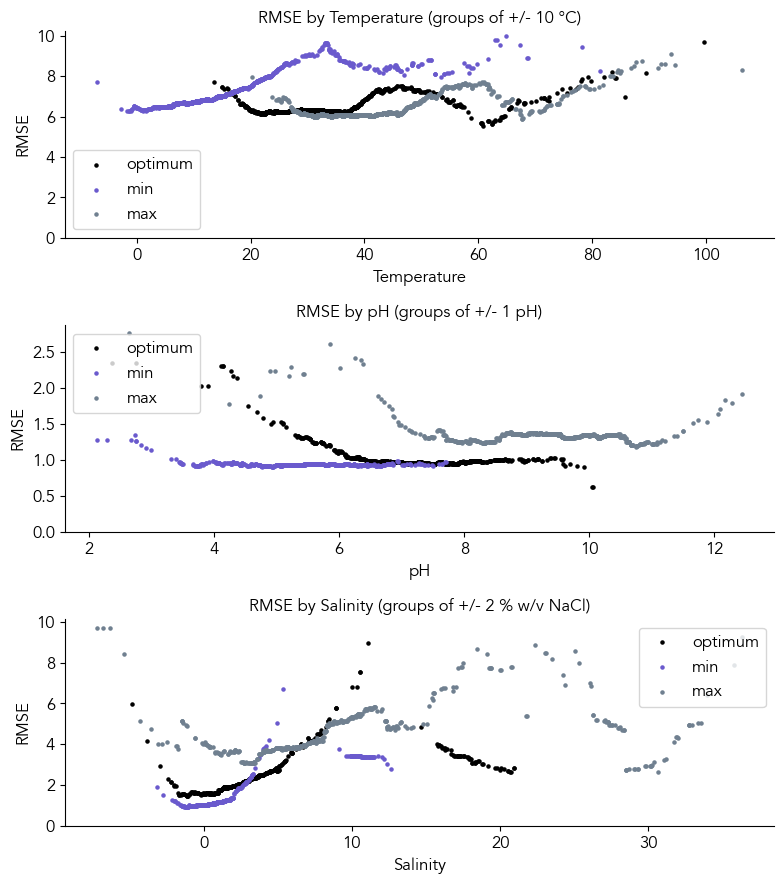

In [37]:
interval_dict = {
    'ph' : 1,
    'salinity' : 2,
    'temperature' : 10,
}

rank = 'family'
condition = 'temperature'
#target = 'temperature_optimum'
target_attr = 'optimum'

fig, axes = plt.subplots(3,1,figsize=(8,9))

for n, condition in enumerate(['temperature', 'ph', 'salinity']):


    ax = axes[n]
    if condition in ['temperature', 'ph', 'salinity']:
        method = 'predict'
        attributes = ['optimum', 'min', 'max']
    elif condition == 'oxygen':
        method = 'predict_proba'
        attributes = ['']

    
    for target_attr in attributes:
            
        if condition == 'oxygen':
            target = 'oxygen'
        else:
            target = rename_condition_to_variable(condition, target_attr)
        
        y_train, y_train_pred, y_valid_pred, y_test, y_test_pred = load_results_from_model_eval_dict(target, rank, taxonomic_model_eval_dict)
        
        # function
        # given y, compare y to error by y
        
        interval = interval_dict[condition]
        error_arr = rmse_by_value(y_train, y_valid_pred, interval, by_true=False)
        ax.scatter(error_arr[:, 0], error_arr[:, 1], s=5,  label=target_attr) #color='cornflowerblue',
        ax.set_xlabel(plot_formats[condition])
        ax.set_title(f'RMSE by {plot_formats[condition]} (groups of +/- {interval} {units[condition]})')
        ax.set_ylabel(f'RMSE')
        
    ax.set_ylim([0, ax.get_ylim()[1]])
    ax.legend()

plt.tight_layout()
#ax.set_title(f'Interval: ')
# discrete
#rmse_arr

In [189]:
rank = 'family'

for target, y_min, y_max in [
    ('temperature_optimum', 0, 15),
    ('salinity_optimum', 10, 20),
    ('ph_optimum', -1, 5),
    ('ph_optimum', 9.5, 15),
    #('salinity_optimum', 20, 25),
]:

    
    y_train, y_train_pred, y_valid_pred, y_test, y_test_pred = load_results_from_model_eval_dict(target, rank, taxonomic_model_eval_dict)
    indexer = (y_train > y_min) & (y_train < y_max)
    avg_rmse = np.sqrt(mean_squared_error(y_train, y_valid_pred))
    rmse = np.sqrt(mean_squared_error(y_train[indexer], y_valid_pred[indexer]))
    
    print(target, rmse, avg_rmse)
    

temperature_optimum 14.04479395690458 6.5300783378019664
salinity_optimum 4.817268828321983 2.762358549900665
ph_optimum 2.030037643537819 1.0532332957114054
ph_optimum 1.8430332795349835 1.0532332957114054


In [36]:
y_train[indexer], y_valid_pred[indexer]

(array([10.  , 11.25,  9.75,  9.75, 10.  , 10.  ,  9.7 ,  9.75, 10.5 ,
        10.  , 10.  , 12.  , 10.  ]),
 array([ 8.23549967,  8.57741251,  8.14549694,  9.57182646, 10.06609931,
         8.62403011,  8.17717261,  8.41426569,  7.68581789,  8.55498295,
         7.72093999,  8.92990374,  9.18298222]))

## Novelty Detection Model

In [38]:
for condition in conditions:
    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    print(len(train_set) + len(test_set), condition)

3646 oxygen
1722 temperature
593 salinity
756 ph


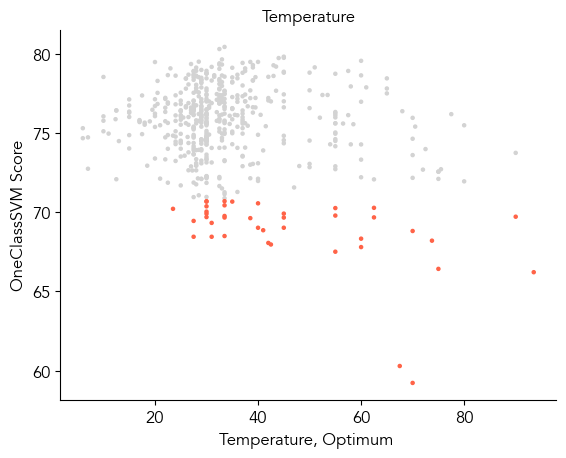

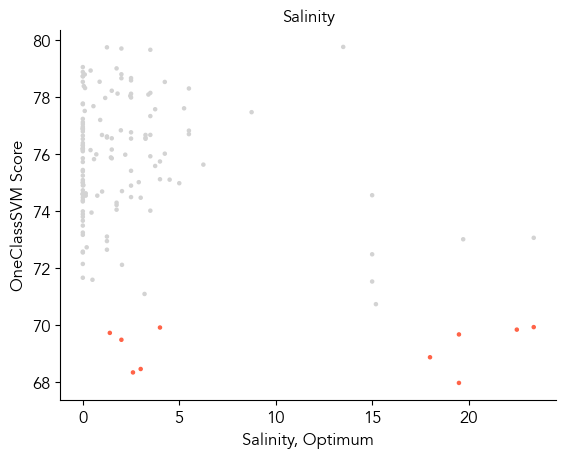

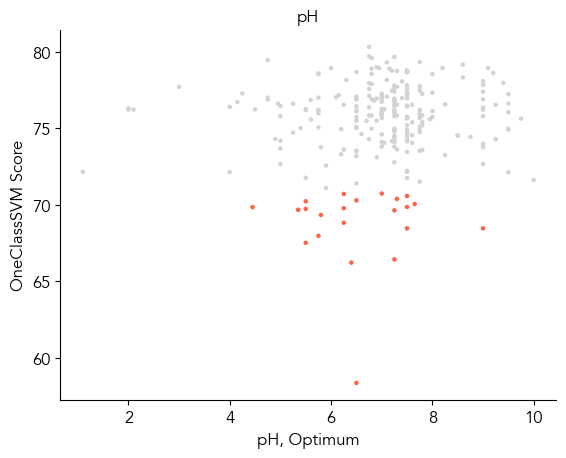

In [40]:
nu=0.05

from sklearn.svm import OneClassSVM

condition = 'oxygen'
    
target = rename_condition_to_variable(condition)
features = training_instructions[condition]['features']
train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
rank = 'family'
y_train, y_train_pred, y_valid_pred, y_test, y_test_pred = load_results_from_model_eval_dict(target, rank, taxonomic_model_eval_dict)

df_train = df.loc[train_set].copy()
df_test = df.loc[test_set].copy()
X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]


clf = OneClassSVM(nu=nu).fit(X_train)




novelty_detect = clf.predict(X_test)
len(novelty_detect[novelty_detect == 1]) / len(novelty_detect)
#clf.score_samples(X)

train_novelty_pred = clf.predict(X_train)
test_novelty_pred = clf.predict(X_test)
train_novelty_score = clf.score_samples(X_train)
test_novelty_score = clf.score_samples(X_test)

df_train['train_novelty_pred'] = train_novelty_pred
df_train['train_novelty_score'] = train_novelty_score

for condition in conditions[1:]:
    
    target = rename_condition_to_variable(condition)
    features = training_instructions[condition]['features']
    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    rank = 'family'
    y_train, y_train_pred, y_valid_pred, y_test, y_test_pred = load_results_from_model_eval_dict(target, rank, taxonomic_model_eval_dict)
    
    # reduce to overlap
    def overlap(taxa, taxa_of_reference):
        return np.array([ taxon in taxa for taxon in taxa_of_reference])

    
    #plot_pred = train_novelty_pred[overlap(train_set, df_train.index) == True]
    #plot_score = train_novelty_score[overlap(train_set, df_train.index) == True]
    
    
    fig, ax = plt.subplots()
    
    C_train = ['lightgray' if nov == 1 else 'tomato' if nov == -1 else "None" for nov in df_train.reindex(train_set)['train_novelty_pred'] ]
    #C_test = ['lightgray' if nov == 1 else 'blue' for nov in test_novelty_pred ]
    ax.scatter(y_train, df_train.reindex(train_set)['train_novelty_score'], c=C_train, s=5)
    #ax.scatter(y_train, y_train - y_train_pred, c=C_train, s=5)
    #ax.scatter(y_train_pred[:, 1], df_train.reindex(train_set)['train_novelty_score'], c=C_train, s=5)
    #ax.scatter(y_test_pred, test_novelty_score,c=C_test, s=5)
    ax.set_xlabel(plot_formats[target])
    ax.set_title(plot_formats[condition])
    ax.set_ylabel('OneClassSVM Score')

In [41]:
from sklearn.svm import OneClassSVM

condition = 'temperature'
for condition in conditions:
    
    target = rename_condition_to_variable(condition)
    instructions = json.loads(open("../models/instructions.json", "r").read())

    features = instructions[condition]['features']
    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    print(condition, features)
    # save a model
    nu = 0.02
    df_train = df.loc[train_set + test_set]
    X_train = df_train[features]
    clf = OneClassSVM(nu=nu).fit(X_train)
    

oxygen ['all_aa_A', 'all_aa_C', 'all_aa_D', 'all_aa_E', 'all_aa_F', 'all_aa_G', 'all_aa_H', 'all_aa_I', 'all_aa_K', 'all_aa_L', 'all_aa_M', 'all_aa_N', 'all_aa_P', 'all_aa_Q', 'all_aa_R', 'all_aa_S', 'all_aa_T', 'all_aa_V', 'all_aa_W', 'all_aa_Y']
temperature ['extracellular_soluble_aa_A', 'extracellular_soluble_aa_C', 'extracellular_soluble_aa_D', 'extracellular_soluble_aa_E', 'extracellular_soluble_aa_F', 'extracellular_soluble_aa_G', 'extracellular_soluble_aa_H', 'extracellular_soluble_aa_I', 'extracellular_soluble_aa_K', 'extracellular_soluble_aa_L', 'extracellular_soluble_aa_M', 'extracellular_soluble_aa_N', 'extracellular_soluble_aa_P', 'extracellular_soluble_aa_Q', 'extracellular_soluble_aa_R', 'extracellular_soluble_aa_S', 'extracellular_soluble_aa_T', 'extracellular_soluble_aa_V', 'extracellular_soluble_aa_W', 'extracellular_soluble_aa_Y', 'intracellular_soluble_aa_A', 'intracellular_soluble_aa_C', 'intracellular_soluble_aa_D', 'intracellular_soluble_aa_E', 'intracellular_solu

# Effect of Features

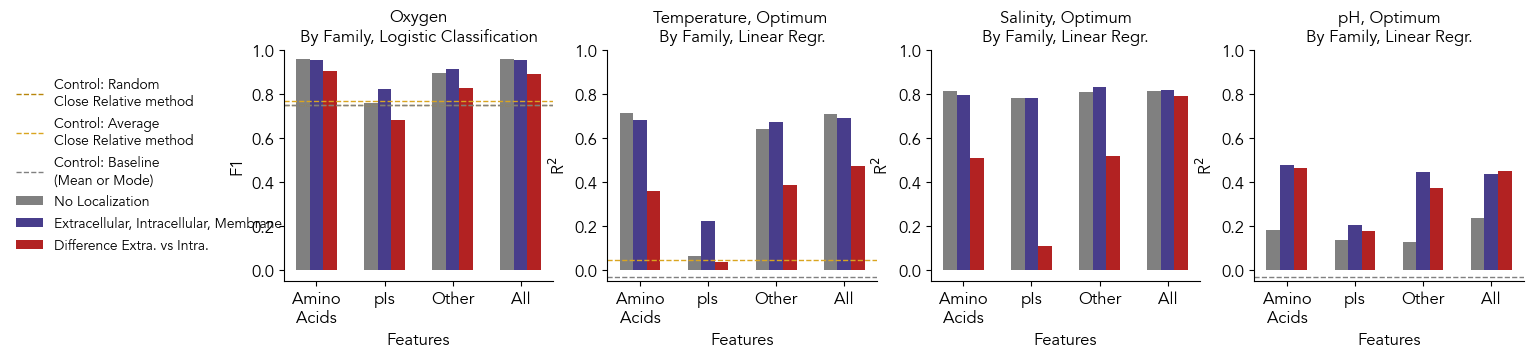

In [48]:
xorder = [ 'AAs', 'pIs', 'Deriv', 'All']

this_plot_formats = {
    'AAs' : 'Amino\nAcids',
    'pIs' : 'pIs',
    'Deriv' : 'Other',
    'All' : 'All'
}

attr_colors = ["gray", "darkslateblue", "firebrick",]
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=attr_colors) 

rank = 'family'
fig, axes = plt.subplots(1,4,figsize=(16,3))
for n, condition in enumerate(conditions):
    target = rename_condition_to_variable(condition)
    group = results_df[(results_df['target'] == target) & (results_df['model_type'].isin(['linearregression', 'logisticregression']))]
    model_type = group['model_type'].tolist()[0]
    ax=axes[n]
    target = rename_condition_to_variable(condition)
    to_bar_plot = {}
    for i, localization_name in enumerate(rename_localizations.values()):
        ser = group[(group['localization_name'] == localization_name)].groupby('feature_name')['score'].max()
        to_bar_plot[localization_name] = ser
    
    data = pd.DataFrame(to_bar_plot)
    data['feature_name'] = data.index
    df_plot = pd.melt(data, id_vars=['feature_name'], value_vars=data.columns).sort_values('variable', ascending=False)
    df_plot['feature_name'] = pd.Categorical(df_plot['feature_name'], xorder)
    df_plot = df_plot.sort_values('feature_name')
    xgroups = df_plot['feature_name'].drop_duplicates().tolist()
    attributes = df_plot['variable'].drop_duplicates().tolist()
    X = np.arange(len(xgroups))  # the label locations
    width = 0.2  # the width of the bars
    multiplier = 0
    for attribute in attributes:
        group = df_plot[df_plot['variable'] == attribute]
        offset = width * multiplier
        measurement = group['value']

        if len(attribute) > 15:
            attribute = ' -\n'.join(attribute.split(' - '))
        rects = ax.bar(X + offset, measurement, width, label=attribute)
        multiplier += 1

    rank='family'
    
    y_train, _, y_valid_pred, _, _ = load_results_from_model_eval_dict(target, rank, average_closest_relative_results)
    y_valid_pred = np.array(y_valid_pred)
    not_nan = ~np.isnan(y_valid_pred)
    if condition == 'oxygen':
        yline_average = f1_score(y_train[not_nan], y_valid_pred[not_nan] > 0.5)
       
    else:
        yline_average = r2_score(y_train[not_nan], y_valid_pred[not_nan])

    
    y_train, _, y_valid_pred, _, _ = load_results_from_model_eval_dict(target, rank, random_closest_relative_results)
    y_valid_pred = np.array(y_valid_pred)
    not_nan = ~np.isnan(y_valid_pred)
    if condition == 'oxygen':
        yline_random = f1_score(y_train[not_nan], y_valid_pred[not_nan] > 0.5)       
    else:
        yline_random = r2_score(y_train[not_nan], y_valid_pred[not_nan])

    y_train, _, y_valid_pred, _, _ = load_results_from_model_eval_dict(target, rank, baseline_results)
    y_valid_pred = np.array(y_valid_pred)
    not_nan = ~np.isnan(y_valid_pred)
    if condition == 'oxygen':
        yline_baseline = f1_score(y_train[not_nan], y_valid_pred[not_nan] > 0.5)
       
    else:
        yline_baseline = r2_score(y_train[not_nan], y_valid_pred[not_nan])
    
    ax.axhline(yline_random, linestyle='--', color='darkgoldenrod', label='Control: Random\nClose Relative method')
    ax.axhline(yline_average, linestyle='--', color='goldenrod', label='Control: Average\nClose Relative method')
    ax.axhline(yline_baseline, linestyle='--', color='gray', label='Control: Baseline\n(Mean or Mode)')
    ax.set_xticks(X + width, [this_plot_formats[label] for label in xgroups], rotation=0, ha='center')
    ax.set_title(plot_formats[target] + f"\nBy {rank.capitalize()}, {rename_estimator[model_type].replace('Regression', 'Regr.')}")
    ax.set_ylabel('')
    ax.set_xlabel('Features')
    ax.set_ylim([-0.05,1])
    ax.set_xticks(ax.get_xticks())
    #ax.set_xlim([-0.5,3.5])
    if target == 'oxygen':
        ax.set_ylabel('F1')
    else:
        ax.set_ylabel('R$^2$')


axes[0].legend(fontsize=10,frameon=False, bbox_to_anchor=(-0.5,0.5), ncols=1, loc='center')


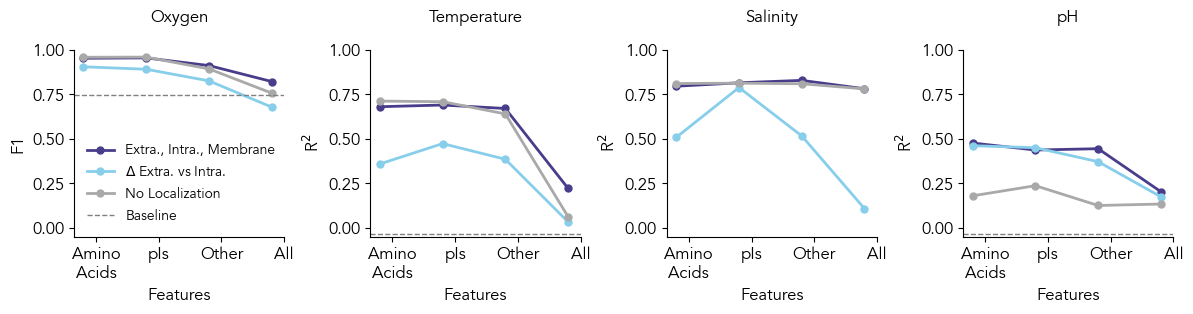

In [49]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#import matplotlib as mpl
#import numpy as np

def axes_feature_selection_one_model(axes, xgroups):

    lw = 2
    xorder = [ 'AAs', 'pIs', 'Deriv', 'All']
    this_plot_formats = {
        'AAs' : 'Amino\nAcids',
        'pIs' : 'pIs',
        'Deriv' : 'Other',
        'All' : 'All'
    }
    rename_local = {
        'No Localization' : 'No Localization',
     'Extracellular, Intracellular, Membrane' : 'Extra., Intra., Membrane',
     'Difference Extra. vs Intra.' : r'$\Delta$ Extra. vs Intra.',
    }
    localization_colors = [ "darkslateblue", "skyblue", "darkgray",]
    matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=attr_colors) 
    
    
    for n, condition in enumerate(conditions):
        ax=axes[n]

        # data
        to_bar_plot = {}
        target = rename_condition_to_variable(condition)
        rank = 'family'
        group = results_df[(results_df['target'] == target) & (results_df['model_type'].isin(['linearregression', 'logisticregression']))]

        model_type = group['model_type'].tolist()[0]
        for i, localization_name in enumerate(rename_localizations.values()):
            ser = group[(group['localization_name'] == localization_name)].groupby('feature_name')['score'].max()
            to_bar_plot[localization_name] = ser
            ser.plot(ax=ax, label=rename_local[localization_name], color=localization_colors[i], 
                      lw=lw, marker='o', linestyle='-', markersize=5)

        # baseline
        y_train, _, y_valid_pred, _, _ = load_results_from_model_eval_dict(target, rank, baseline_results)
        y_valid_pred = np.array(y_valid_pred)
        not_nan = ~np.isnan(y_valid_pred)
        if condition == 'oxygen':
            yline_baseline = f1_score(y_train[not_nan], y_valid_pred[not_nan] > 0.5)
        else:
            yline_baseline = r2_score(y_train[not_nan], y_valid_pred[not_nan])
        ax.axhline(yline_baseline, linestyle='--', lw=1, color='gray', label='Baseline')

        # format
        ax.set_xticks(X + width, [this_plot_formats[label] for label in xgroups], rotation=0, ha='center')
        ax.set_title(plot_formats[condition]+'\n')
        ax.set_ylabel('')
        ax.set_xlabel('Features')
        ax.set_ylim([-0.05,1])
        ax.set_xticks(ax.get_xticks())
        if target == 'oxygen':
            ax.set_ylabel('F1')
        else:
            ax.set_ylabel('R$^2$')
    
    axes[0].legend(fontsize=10,frameon=False, ncols=1, loc='best')


fig, axes = plt.subplots(1,4,figsize=(12,3.3))
axes_feature_selection_one_model(axes, xgroups)
plt.tight_layout()
plt.savefig("fig-2b.svg",  format="svg")
plt.show()


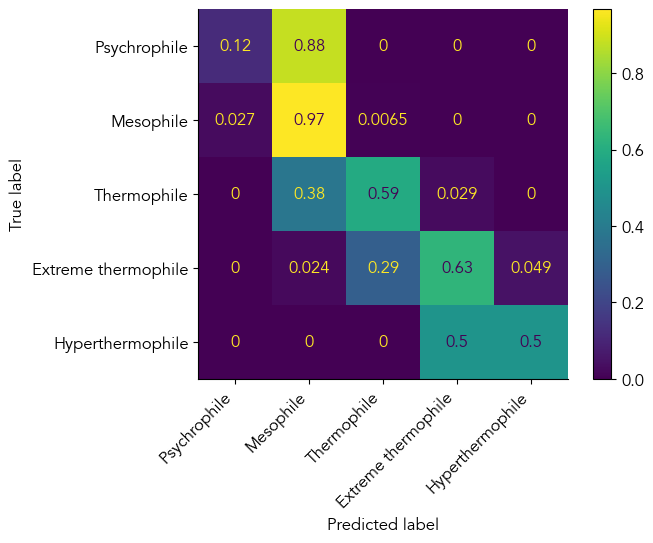

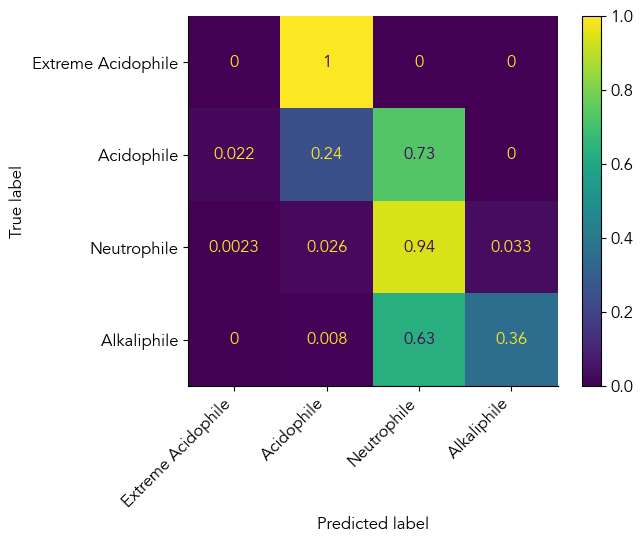

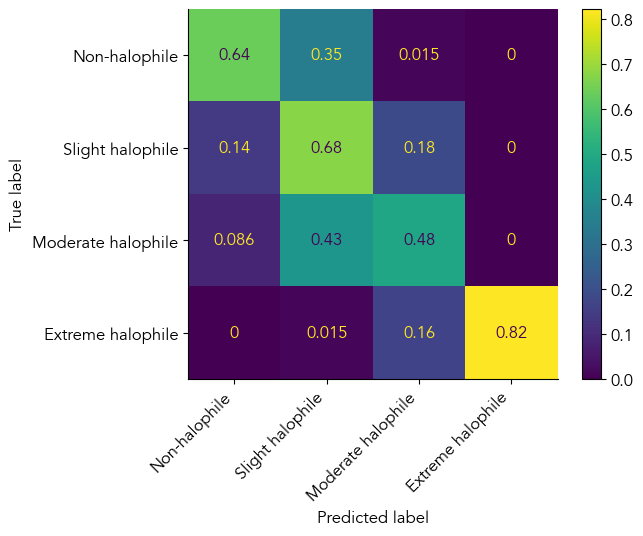

In [44]:
category_definitions = {
    'oxygen' : {
        'bins' : [0, 0.5, 1.1],
        'labels' : ['Obligate anaerobe', 'Aerobe'],
               },
    'ph_optimum' : {
        'bins' : [-10,3,5.5,8.5,20],
        'labels' : ['Extreme Acidophile', 'Acidophile', 'Neutrophile', 'Alkaliphile'],
    },
    'temperature_optimum' : {
        'bins' : [-30,20,45,64,80,130],
        'labels' : ['Psychrophile', 'Mesophile', 'Thermophile', 'Extreme thermophile', 'Hyperthermophile'],
    },
    'salinity_optimum' : {
        'bins' : [-10, 1.7, 4.8, 15, 50],
        'labels' : ['Non-halophile', 'Slight halophile', 'Moderate halophile', 'Extreme halophile'],
}}
category_definitions
for condition in ['temperature', 'ph', 'salinity']:

    rank = 'family'
    target = rename_condition_to_variable(condition)
    cv_sets = clean_cv_sets(taxonomic_cv_sets_dict[condition][rank])
    y_train, y_train_pred, y_valid_pred, y_test, y_test_pred = load_results_from_model_eval_dict(target, rank, taxonomic_model_eval_dict)
    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    #df_train = df.loc[train_set]
    
    bins = category_definitions[target]['bins']
    labels = category_definitions[target]['labels']
    true_bins = np.digitize(y_train, bins)
    pred_bins = np.digitize(y_valid_pred, bins)
    
    disp = ConfusionMatrixDisplay(confusion_matrix(true_bins, pred_bins, normalize='true'), display_labels=labels)
    disp.plot()
    ax = disp.ax_
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', )
    plt.show()

# Effect of Holdout Level


## Plot different holdout levels

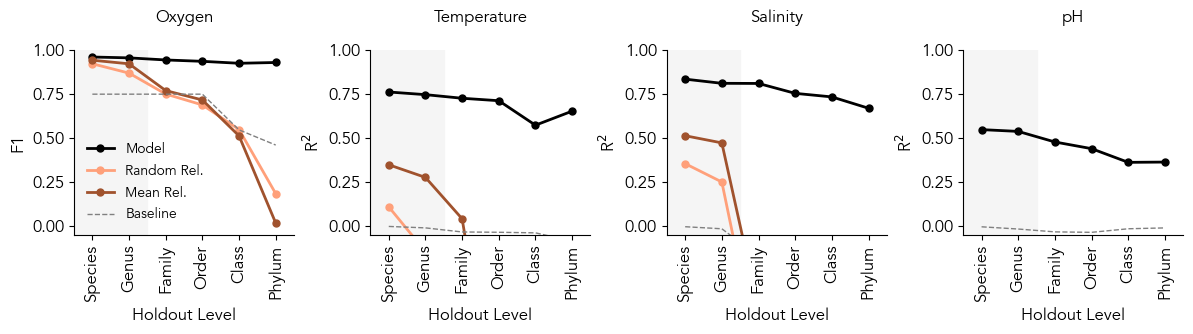

In [45]:

def axes_holdout_level_experiment(axes):

    lw = 2
    axl[0].set_title('Varying Holdout Level\n')
    rank_order = RANKS_TO_TEST[::-1]
    for n, condition in enumerate(conditions):
    
        ### MODEL
        ax = axl[n]
        target = rename_condition_to_variable(condition)
        scores = {}
        for rank in rank_order:
            y_train, _, y_valid_pred, _, _ = load_results_from_model_eval_dict(target, rank, taxonomic_model_eval_dict)
            if condition == 'oxygen':
                scores[rank] = f1_score(y_train, y_valid_pred[:, 1] > 0.5)
                ax.set_ylabel('F1')
                text = plot_formats[condition].replace(' ', '\n')
                ax.set_ylabel(f"F1")
            else:
                scores[rank] = r2_score(y_train, y_valid_pred)
                ax.set_ylabel('R$^2$')
                text = plot_formats[condition].replace(' ', '\n')
                ax.set_ylabel(f"R$^2$")
        ax.set_title(plot_formats[condition]+'\n')
        ser = pd.Series(scores)
        ser.plot(ax=ax, lw=lw, marker='o', markersize=5, color='black', label='Model')
    
    
    
        ### RANDOM
        scores = {}
        for rank in rank_order:
            target = rename_condition_to_variable(condition)
            y_train, _, y_valid_pred, _, _ = load_results_from_model_eval_dict(target, rank, random_closest_relative_results)
            y_valid_pred = np.array(y_valid_pred)
            not_nan = ~np.isnan(y_valid_pred)
            if np.sum(not_nan) < 1:
                scores[rank] = np.nan
            else:
                if condition == 'oxygen':
                    scores[rank] = f1_score(y_train[not_nan], y_valid_pred[not_nan] > 0.5)
                else:
                    scores[rank] = r2_score(y_train[not_nan], y_valid_pred[not_nan])
        ser = pd.Series(scores)
        ser.plot(ax=ax, lw=lw, marker='o', color='lightsalmon', markersize=5, label='Random Rel.')
    
        ### AVERAGE
        scores = {}
        for rank in rank_order:
            target = rename_condition_to_variable(condition)
            y_train, _, y_valid_pred, _, _ = load_results_from_model_eval_dict(target, rank, average_closest_relative_results)
            y_valid_pred = np.array(y_valid_pred)
            not_nan = ~np.isnan(y_valid_pred)
            if np.sum(not_nan) < 1:
                scores[rank] = np.nan
            else:
                if condition == 'oxygen':
                    scores[rank] = f1_score(y_train[not_nan], y_valid_pred[not_nan] > 0.5)
                else:
                    scores[rank] = r2_score(y_train[not_nan], y_valid_pred[not_nan])
        ser = pd.Series(scores)
        ser.plot(ax=ax, lw=lw, marker='o', color='sienna', markersize=5, label='Mean Rel.')
    
        ### BASELINE
        scores = {}
        for rank in rank_order:
            target = rename_condition_to_variable(condition)
            y_train, _, y_valid_pred, _, _ = load_results_from_model_eval_dict(target, rank, baseline_results)
            y_valid_pred = np.array(y_valid_pred)
            not_nan = ~np.isnan(y_valid_pred)
            if condition == 'oxygen':
                scores[rank] = f1_score(y_train[not_nan], y_valid_pred[not_nan] > 0.5)
            else:
                scores[rank] = r2_score(y_train[not_nan], y_valid_pred[not_nan])
        ser = pd.Series(scores)
        #ser.plot(ax=ax, lw=lw, marker='o', linestyle='--', color='gray', markersize=5, label='Baseline')
        ser.plot(ax=ax, lw=1,  linestyle='--', color='gray', label='Baseline')
        ax.fill_between([0-0.5, rank_order.index('genus')+0.5, ], -0.05, 1, color='whitesmoke')
    
    for ax in axl:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_xlim([-0.5, len(rank_order) - 0.5])
        ax.set_ylim([-0.05,1])
        ax.set_xlabel('')
        ax.set_xticks(range(len(rank_order)))
        ax.set_xticklabels([t.capitalize() for t in rank_order], rotation=90)
        ax.set_xlabel('Holdout Level')
    
    ax = axl[0]
    axl[0].legend(frameon=False, fontsize=10, loc='lower left')#, bbox_to_anchor=(1,1.1,)

fig, axes = plt.subplots(1,4, figsize=(12,3.5))
axl = axes.flatten()
axes = axes_holdout_level_experiment(axl)
plt.tight_layout()
plt.savefig("fig-2c.svg",  format="svg")
plt.show()

## Regressions

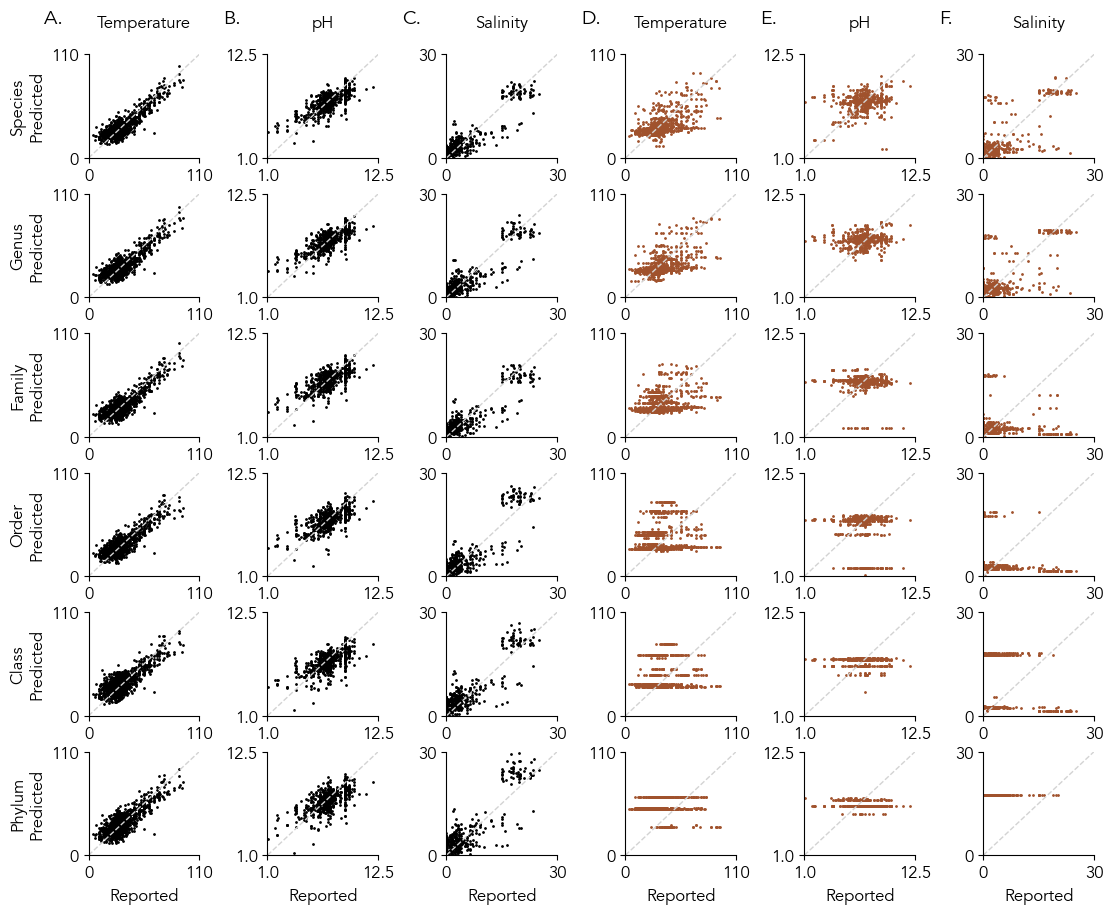

In [46]:
experiment_scores = defaultdict(dict)
# predictions for each CV set:

RANKS_TO_TEST = ['phylum', 'class', 'order', 'family', 'genus', 'species']
fig, axes = plt.subplots(len(RANKS_TO_TEST), 6, figsize=(11,1.5*len(RANKS_TO_TEST)))
for col, condition in enumerate(['temperature', 'ph', 'salinity']):

    target = rename_condition_to_variable(condition)
    lim1, lim2 = lims_dict[condition]

    ax = axes[0, col]
    ax.text(-0.4, 1.3, f"{string.ascii_uppercase[col]}.", transform=ax.transAxes,  size=14)
    ax = axes[0, col+3]
    ax.text(-0.4, 1.3, f"{string.ascii_uppercase[col+3]}.", transform=ax.transAxes,  size=14)
    for row, rank in enumerate(RANKS_TO_TEST[::-1]):
        ax = axes[row, col]
        y_train, y_train_pred, y_valid_pred, y_test, y_test_pred = load_results_from_model_eval_dict(target, rank, taxonomic_model_eval_dict)

        scores = score_regression(y_train, y_valid_pred)
        rmse, r2, corr = scores['rmse'], scores['r2'], scores['corr']
        
        X = y_train
        Y = y_valid_pred
        ax.scatter(X,Y,s=1, color='black')
        if row == 0:
            ax.set_title(plot_formats[condition]+'\n')
        if col == 0:
            ax.set_ylabel(f"{rank.capitalize()}")
        
        ax.set_xlim(lim1, lim2)
        ax.set_ylim(lim1, lim2)
        ax.plot([lim1, lim2], [lim1, lim2], linestyle='--', color='lightgray',)
        ax.set_yticks([lim1, lim2])
        ax.set_xticks([lim1, lim2])
        if row == len(RANKS_TO_TEST) -1:
            ax.set_xlabel('Reported')
        if col == 0:
            ax.set_ylabel(f"{rank.capitalize()}\nPredicted")
    
    for row, rank in enumerate(RANKS_TO_TEST[::-1]):
        
        ax = axes[row, col + 3]
        
        y_train, _, y_valid_pred, _, _ = load_results_from_model_eval_dict(target, rank, average_closest_relative_results)
        y_valid_pred = np.array(y_valid_pred)
        not_nan = ~np.isnan(y_valid_pred)
        # if condition == 'oxygen':
        #     scores[rank] = f1_score(y_train[not_nan], y_valid_pred[not_nan] > 0.5)
           
        # else:
        #     try:
        #         scores[rank] = r2_score(y_train[not_nan], y_valid_pred[not_nan])
        #     except:
        X = y_train
        Y = y_valid_pred
        ax.scatter(X,Y,s=1, color='sienna')
        if row == 0:
            ax.set_title(plot_formats[condition]+'\n')
        
        ax.set_xlim(lim1, lim2)
        ax.set_ylim(lim1, lim2)
        ax.plot([lim1, lim2], [lim1, lim2], linestyle='--', color='lightgray',)
        ax.set_yticks([lim1, lim2])
        ax.set_xticks([lim1, lim2])

    
        if row == len(RANKS_TO_TEST) -1:
            ax.set_xlabel('Reported')
        
plt.tight_layout(pad=0.2)

# Figure 2

temperature_optimum
salinity_optimum
ph_optimum


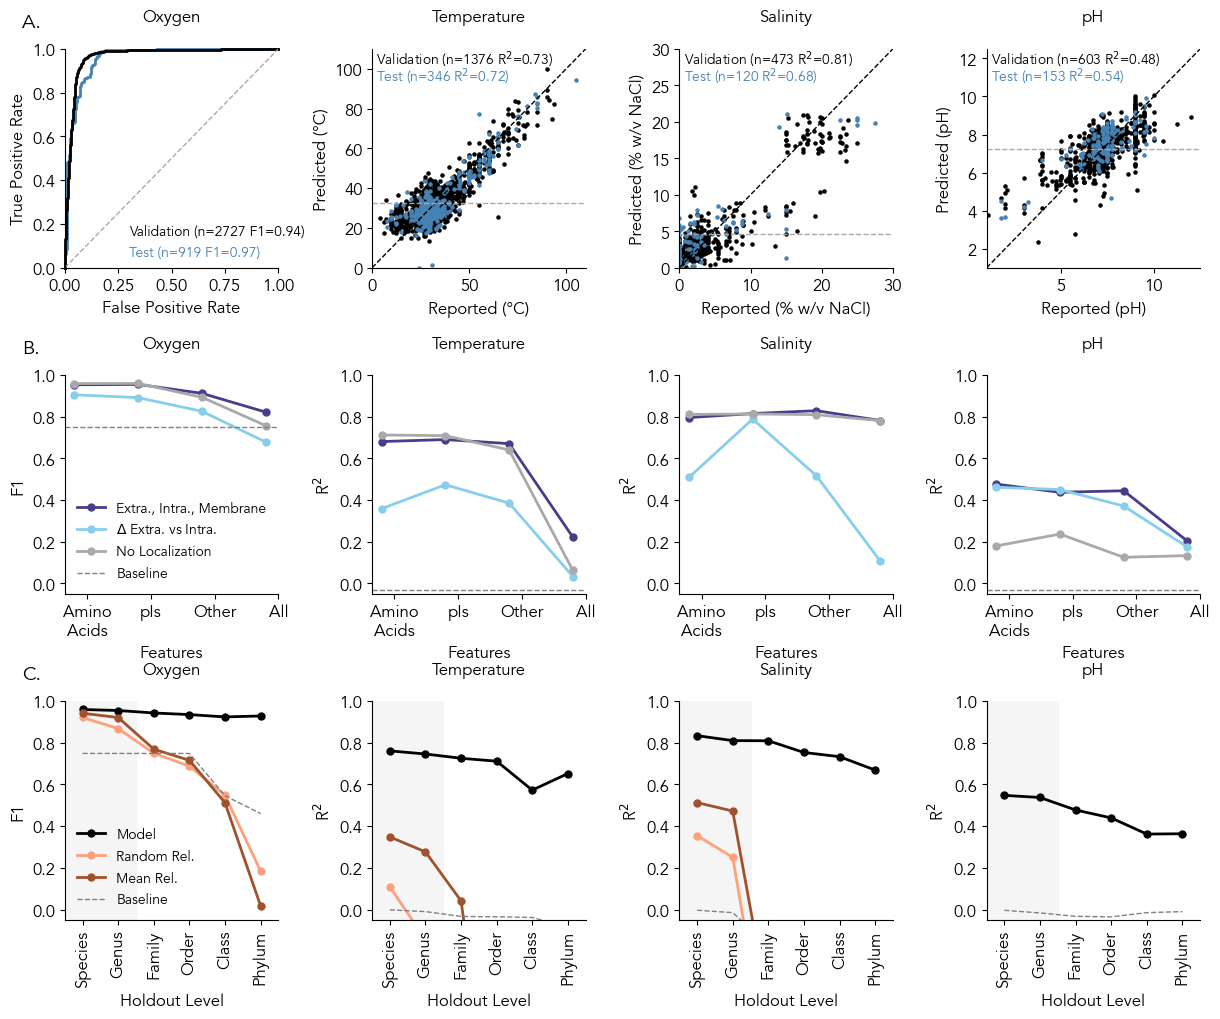

In [50]:
### Supp fig

fig, axes = plt.subplots(3,4, figsize=(12,10))

axl = axes[0]
axes_overall_performance(axes, show_test=True)
axl[0].text(-0.2, 1.1, f"{string.ascii_uppercase[0]}.", transform=axl[0].transAxes,  size=14)

n = 1
axl = axes[n]
axes_feature_selection_one_model(axl, xgroups)
axl[0].text(-0.2, 1.1, f"{string.ascii_uppercase[n]}.", transform=axl[0].transAxes,  size=14)

n = 2
axl = axes[n].flatten()
axes = axes_holdout_level_experiment(axl)
axl[0].text(-0.2, 1.1, f"{string.ascii_uppercase[n]}.", transform=axl[0].transAxes,  size=14)

plt.tight_layout(pad=0)
#plt.savefig("fig-2abc.svg",  format="svg")
plt.show()

In [749]:
axes[n]

TypeError: 'NoneType' object is not subscriptable

# Feature Importance

In [51]:
permutation_importances = {}
feature_coefficients = {}
rank = 'family'
for condition in ['oxygen', 'temperature', 'ph', 'salinity']:
    print(condition)
    if condition in ['temperature', 'ph', 'salinity']:
        method = 'predict'
        attributes = ['optimum', 'min', 'max']
    elif condition == 'oxygen':
        method = 'predict_proba'
        attributes = ['']

         
    if condition == 'oxygen':
        target = 'oxygen'
    else:
        target = rename_condition_to_variable(condition)

    features = training_instructions[condition]['features']
    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    cv_sets = clean_cv_sets(taxonomic_cv_sets_dict[condition][rank])
    pipeline_filename = PATH_TO_DATA_DIR + training_instructions[condition]['pipeline_filename']
    pipe = joblib.load(pipeline_filename)
    pipe[-1].max_iter = 50000

    df_train = df.loc[train_set]
    X_train = df_train[features]
    y_train = df_train[target]
    pipe.fit(X_train, y_train)
    X_train_scaled = pipe[0].transform(X_train)
    if condition == 'oxygen':
        feat_importance = (np.std(X_train_scaled, 0) * pipe[-1].coef_)[0]
        feature_coefficients[condition] = dict(zip(features, feat_importance))
        print(feat_importance)
    else:
        feat_importance = (np.std(X_train_scaled, 0) * pipe[-1].coef_)
        feature_coefficients[condition] = dict(zip(features, feat_importance))
        print(feat_importance)
    #print(pipe)

    model = pipe[-1]
    permutation_importances[target] = permutation_importance(model, X_train_scaled, y_train,
                               n_repeats=30,
                               random_state=0)
    
    permutation_importances[target]['features'] = features
    
len(permutation_importances.keys())

oxygen
[ 1.23564822 -2.2037032   0.16117309 -0.56243173  0.60792436  0.73275276
  1.4520622  -1.03305533  0.11423237  0.02780192 -1.03753956  1.53487619
 -1.63491152  0.49076308 -1.00754199  0.2686576  -0.38379053 -0.40223476
  0.82746704 -1.46840657]
temperature
[ 5.40521410e-01  1.81879724e-01  3.07709074e-01 -1.22416921e+00
  1.43154996e+00 -1.95147759e+00 -4.80875008e-01  3.70365032e+00
 -1.26851717e-01  1.12175026e+00 -8.87611320e-02 -7.47453814e-01
  6.56052046e-01 -4.93219168e-03 -0.00000000e+00  2.45082918e-01
 -4.32289575e-01  1.85763215e+00  7.38891999e-01  9.80628944e-01
 -7.58165209e+00  7.01404733e-01  1.97741373e+00  2.05880447e+00
 -5.38146083e+00 -3.79953337e+00 -2.11898748e+00 -0.00000000e+00
  3.45588333e+00 -6.78818214e+00 -3.99844665e+00 -1.00225498e+01
  9.40249897e+00  6.62864061e-01  4.65416786e+00 -4.17156730e+00
 -3.21259916e+00  3.50640747e+00  7.27397975e-01  4.28576070e+00
  1.62734296e+00 -5.41857405e-01 -2.75895160e+00  1.00546039e+00
  2.52916957e+00 -1.5

4

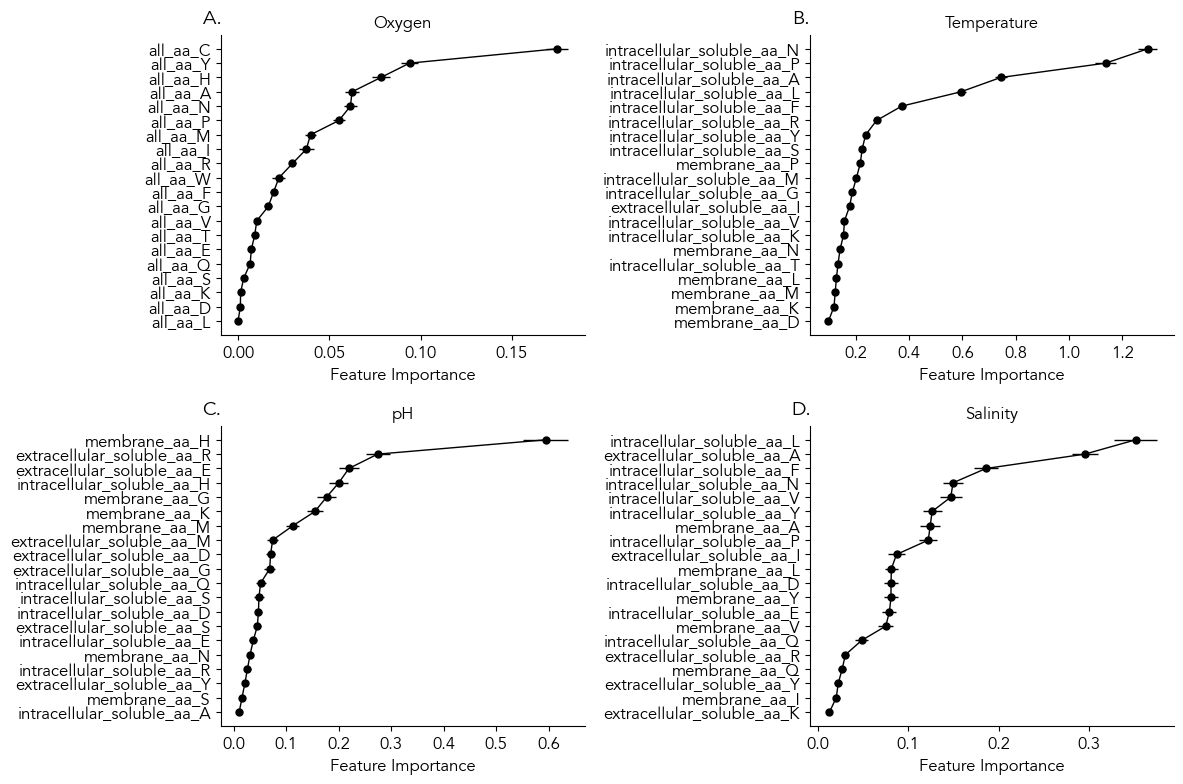

In [52]:
fig, axes = plt.subplots(2,2, figsize=(12,8))
axl = axes.flatten()
for n, (target, r) in enumerate(permutation_importances.items()):

    
    importance_df = pd.DataFrame(zip(r['features'], r['importances_mean'], r['importances_std']))
    importance_df.columns = ['feature', 'mean_importance', 'std_importance']
    importance_df
    importance_df  = importance_df[np.abs(importance_df['mean_importance']) > 0].sort_values('mean_importance', ascending=False).head(20)[::-1]

    ax = axl[n]
    #fig, ax = plt.subplots(figsize=(3,5))
    labels = importance_df['feature'].tolist()
    ax.errorbar(
        y=range(len(labels)), x=importance_df['mean_importance'], xerr=importance_df['std_importance'],
        markersize=5,
        marker='o',
        color='black'
               )


    condition = target.replace('_optimum', '')
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_title(plot_formats[condition])
    ax.set_xlabel('Feature Importance')
    #ax.set_xlim([0,1])
    #ax.set_xticks(ax.get_major_xticks())
    #ax.set_xlim(ax.get_xlim()#)
    
    ax.text(-0.05, 1.04, f"{string.ascii_uppercase[n]}.", transform=ax.transAxes,  size=14)
plt.tight_layout()

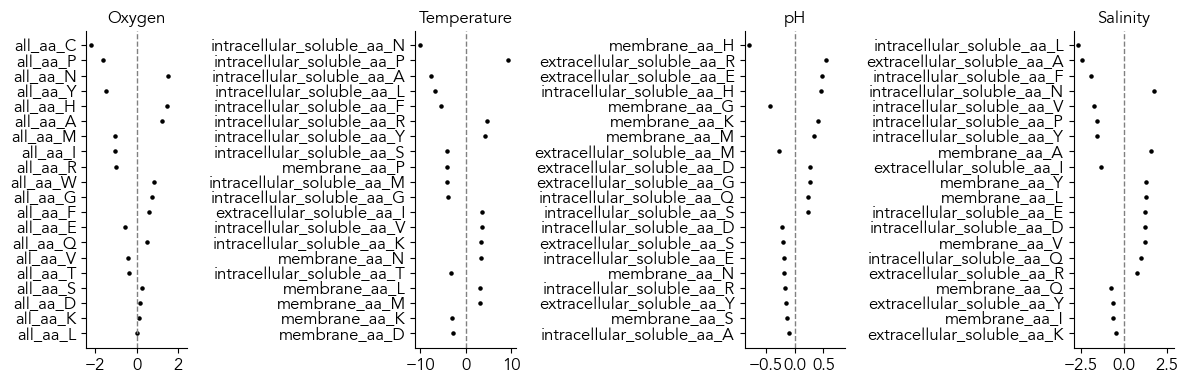

In [54]:
fig, axes = plt.subplots(1,4,figsize=(12,0.2*20))
for n, (condition, importances) in enumerate(feature_coefficients.items()):
    ax = axes[n]
    indexer = np.abs( pd.Series(importances)).sort_values().index
    X = pd.Series(importances).loc[indexer].tail(20)
    labels = X.index
    ax.scatter(X, range(len(labels)), s=5, color='black')
    ax.axvline(x=0, linestyle='--', color='gray')
    #.plot.barh(ax=ax)
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    xmax = np.max(np.abs(X))
    ax.set_xlim(-1.1 * xmax, 1.1 * xmax)

    ax.set_title(plot_formats[condition])

plt.tight_layout()

# In-Depth: Oxygen

## Original Model

In [222]:
condition = target = 'oxygen'
rank = 'family'
train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
df_train = df.loc[train_set]
df_full = df.loc[train_set + test_set]
y_train, y_train_pred, y_valid_pred, y_test, y_test_pred = load_results_from_model_eval_dict(target, rank, taxonomic_model_eval_dict)
y_valid_pred_probs = y_valid_pred[:, 1]
y_valid_pred = 1. * (y_valid_pred_probs > 0.5)
y_test_pred_probs = y_test_pred[:, 1]
y_test_pred = 1. * (y_test_pred_probs > 0.5)
y_full = np.array(list(y_train) + list(y_test))

y_full_pred = np.array(list(y_valid_pred) + list(y_test_pred))

In [123]:
localizations = ['all']
#localizations = ['extracellular_soluble', 'intracellular_soluble', 'membrane']
# expected_df = df['all_nt_C'].apply(lambda x: pd.Series(calc_expected_aa_frequencies(gc_fraction=x)))
# sers = []
# for localization in localizations:
#     for aa in BASE_VARS_AAS:
#         col = localization + '_' + aa
#         ser = df[col] / expected_df[aa[-1]]
#         ser.name = 'enrich:' + localization + '_' + aa
#         sers.append(ser)

# enrichment_df = pd.concat(sers, axis=1)
# #enrichment_df.columns = ['enrich:' + localization + '_' + aa for aa in BASE_VARS_AAS]
# enrichment_df
# features = enrichment_df.columns


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    mean_squared_error,
    r2_score,
)
from sklearn.pipeline import make_pipeline
condition = 'oxygen'
target = 'oxygen'
rank = 'family'
selected_feature_set = 'aas'
features = feature_set_dict[selected_feature_set]
train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
cv_sets = taxonomic_cv_sets_dict[condition][rank]
df_train = df.loc[train_set]

X_train = df_train[features]
y_train = df_train[target]

#X_train = enrichment_df.loc[df_train.index]
pipe, y_train_pred, y_valid_pred = predict_training_and_cv(X_train, y_train,
                                                               pipeline=make_pipeline(StandardScaler(), LogisticRegression()), 
                                                               cv=yield_cv_sets(cv_sets))

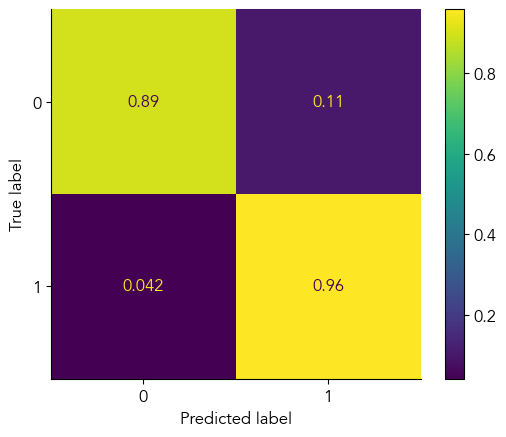

(1562, 980, 116, 69, 0.9576946658491723, 0.930870083432658, 0.9440918706557873)

In [124]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train, y_valid_pred, labels=[0,1], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
conf = confusion_matrix(y_train, y_valid_pred)
tn, fp, fn, tp = conf.ravel()
f1 = tp / (tp + 0.5 * (fp + fn))
tp, tn, fp, fn, tp / (tp + fn), tp / (tp + fp), f1

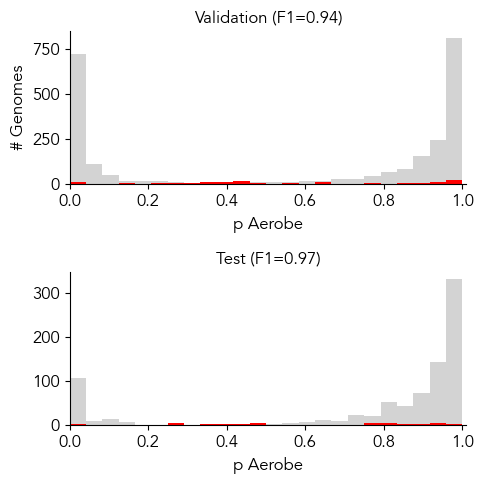

In [125]:

fig, axes = plt.subplots(2,1, figsize=(5,5))
ax = axes[0]
stats = score_classification(y_train, y_valid_pred)
ax.set_title(f"Validation (F1={stats['f1']:.2f})")
bins = np.linspace(0, 1, 25)
hist1, bins, _ = ax.hist(y_valid_pred_probs[y_train == y_valid_pred], bins=bins, color='lightgray', label='Correct')
hist2, bins, _ = ax.hist(y_valid_pred_probs[y_train != y_valid_pred], bins=bins,   color='red', label='Incorrect')
ax.set_ylabel('# Genomes' )
ax = axes[1]
stats = score_classification(y_test, y_test_pred)
ax.set_title(f"Test (F1={stats['f1']:.2f})")
hist1, bins, _ = ax.hist(y_test_pred_probs[y_test == y_test_pred], bins=bins,   color='lightgray', label='Correct predictions')
hist2, bins, _ = ax.hist(y_test_pred_probs[y_test != y_test_pred], bins=bins,  color='red', label='Incorrect')
for ax in axes:
    ax.set_xlabel('p Aerobe')
    ax.set_xlim([0,1.01])
plt.tight_layout()

### Performance by Group (e.g. Phylum)

In [167]:
#len(df_train[(df_train['all_nt_C'] < 0.35) | (df_train['all_nt_C'] > 0.65)]) / len(df_train)
df_train[(df_train['all_nt_C'] < 0.35)]['phylum'].value_counts()

phylum
Bacillota_A           86
Campylobacterota      64
Methanobacteriota     35
Fusobacteriota        24
Bacteroidota          18
Thermotogota          16
Bacillota             11
Spirochaetota         10
Bacillota_F            5
Nitrospirota           4
Bacillota_C            3
Pseudomonadota         3
Bacillota_D            3
Dictyoglomota          2
Thermodesulfobiota     2
Deferribacterota       2
Aquificota             1
Halobacteriota         1
Bacillota_B            1
Name: count, dtype: int64

0.25-0.30 0.7220779220779221
0.30-0.35 0.7034313725490196
0.35-0.40 0.902984022556391
0.40-0.45 0.9602763150751858
0.45-0.50 0.9615743505524037
0.50-0.55 0.94956454306848
0.55-0.60 0.9332554403388345
0.60-0.65 0.9083008447043535
0.65-0.70 0.710688591983556
0.70-0.75 0.6605691056910569
0.9141054542130354
10-20 0.984375
20-30 0.881378159275155
30-40 0.939819547535446
40-50 0.9015151515151515
50-60 0.8494252873563218
60-70 0.672514619883041
70-80 0.75
80-90 nan
90-100 nan
0.9159967583074682
0-5 0.9279003586464992
5-10 0.7395833333333333
10-15 1.0
15-20 0.5
20-25 0.6666666666666666
0.8628474576271186


/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_56787/167895466.py:158: RuntimeWarning: invalid value encountered in scalar divide
  f1 = tp / (tp + 0.5 * (fp + fn))
/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_56787/167895466.py:134: RuntimeWarning: invalid value encountered in scalar divide
  term1 = (tp / (tp + fn))
/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_56787/167895466.py:230: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([ymin+0.5, ymax-0.5])


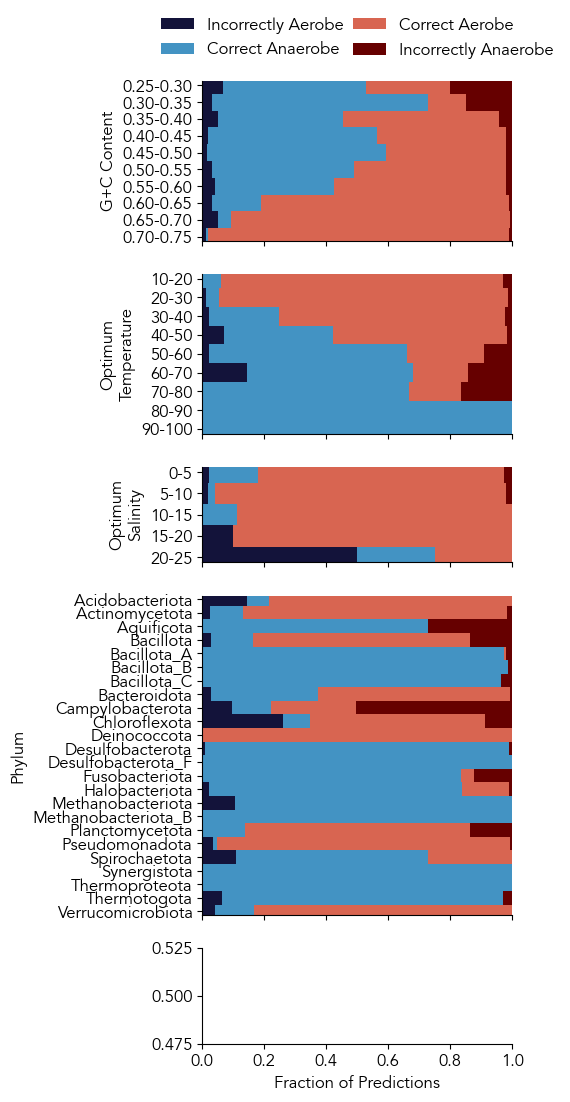

In [192]:
# F1 score along different gradients:
# GC Content
# Temperature / Salinity / pH gradients
# Phylum
condition = 'oxygen'
rank = 'family'
target = rename_condition_to_variable(condition)
cv_sets = clean_cv_sets(taxonomic_cv_sets_dict[condition][rank])
y_train, y_train_pred, y_valid_pred, y_test, y_test_pred = load_results_from_model_eval_dict(target, rank, taxonomic_model_eval_dict)
y_train_pred = y_train_pred[:, 1] > 0.5
y_valid_pred = y_valid_pred[:, 1] > 0.5
y_test_pred = y_test_pred[:, 1] > 0.5
train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
df_train = df.loc[train_set]


bin_defitions = {
    'all_nt_C' : {
        'min' : 0.25,
        'max' : 0.75,
        'step' : 0.05,
        },
    'temperature_optimum' : {
        'min' : 10,
        'max' : 100,
        'step' : 10,
        },
    'salinity_optimum' : {
        'min' : 0,
        'max' : 25,
        'step' : 5,
        },
    'ph_optimum' : {
        'min' : 1,
        'max' : 11,
        'step' : 1,
        }
}

this_plot_formats = {
    'temperature_optimum' : 'Optimum\nTemperature',
    'salinity_optimum' : 'Optimum\nSalinity',
    'ph_optimum' : 'Optimum\npH',
    'all_nt_C' : 'G+C Content',
}
xlabel_kwargs = {
    'rotation' : 'horizontal', 'ha':'right', 'va':'center'
}
ylabel_kwargs = {}

columns = ['Incorrectly Anaerobe', 'Correct Aerobe', 'Correct Anaerobe', 'Incorrectly Aerobe', ][::-1]
oxygen_colors = [ '#660000', plt.get_cmap("RdBu_r")(0.79), plt.get_cmap("RdBu_r")(0.2), '#13133a', ][::-1]


def aerobic_predictions_along_range(y_train, y_valid_pred, bin_min, bin_max, step, var, 
                                    df_train=df_train, norm=True, randomize=False, float_prec=None
                                    ):
    arr = []
    labels = []
    ser = df.loc[df_train.index, var]
    bins = np.arange(bin_min, bin_max, step)
    for bin_min in bins:
        #print(.shape)
        indexer_for_bin = (bin_min <= ser) & (ser < (bin_min + step))
        y_train_bin = y_train[indexer_for_bin]
        y_valid_pred_bin = y_valid_pred[indexer_for_bin]

        if randomize is True:
            y_train_bin = np.random.choice(y_train_bin, size=len(y_train_bin), replace=False)
        tp = np.sum((y_train_bin == 1) & (y_valid_pred_bin == 1))
        tn = np.sum((y_train_bin == 0) & (y_valid_pred_bin == 0)) 
        fp = np.sum((y_train_bin == 0) & (y_valid_pred_bin == 1)) 
        fn = np.sum((y_train_bin == 1) & (y_valid_pred_bin == 0))
        if norm is True:
            arr.append([val / np.sum(indexer_for_bin) for val in [fn, tp, tn, fp][::-1]])
        else:
            arr.append([fn, tp, tn, fp][::-1])

        if float_prec == 2:
            labels.append(f"{(bin_min):.2f}-{(bin_min + step):.2f}")
        else:
            labels.append(f"{(bin_min):.0f}-{(bin_min + step):.0f}")
    return arr, labels

def ax_bar_aerobic_predictions(ax, arr, xticklabels, cols, colors, stacked=True, show_proportions = False):
    
    df_results = pd.DataFrame(arr)
    df_results.columns = cols
    df_results.plot.bar(ax=ax, stacked=stacked, width=1, color=colors)
    if show_proportions is True:
        (df_results['False Aerobe'] / (df_results['True Aerobe'] + df_results['False Aerobe'])).plot( label='Proportion Aerobe False')
        (df_results['False Anaerobe'] / (df_results['True Anaerobe'] + df_results['False Anaerobe'])).plot(linestyle='--', c='black', label='Proportion Anaerobe False')
    ax.set_xticklabels(xticklabels, rotation=90)
    ax.set_ylabel('Proportion of Predictions')
    ax.legend(bbox_to_anchor=(1.,1.), frameon=False)
    return ax 

def arr_to_f1(arr):
    arr = np.array(arr)
    tp, tn, fp, fn = np.sum(arr, axis=0)
    f1 = tp / (tp + 0.5 * (fp + fn))
    return f1
    
def aerobic_predictions_by_taxon(y_train, y_valid_pred, taxon_to_accessions, df_train=df_train, min_n = 1, norm=True, randomize=False):
    # across gc_content bins
    # find indices within those bins
    # plot sum values  tp, etc.

    arr = []
    labels = []
    for taxon, accessions in sorted(taxon_to_accessions.items()):
        genomes = set(df_train.index.tolist()).intersection(set(accessions))
        if len(genomes) > min_n:
            indexer = [idx in genomes for idx in df_train.index]
            y_train_taxon = y_train[indexer]
            y_valid_pred_taxon = y_valid_pred[indexer]

            if randomize is True:
                y_train_taxon = np.random.choice(y_train_taxon, size=len(y_train_taxon), replace=False)
            #conf = confusion_matrix(y_train_taxon, y_valid_pred)
            #tn, fp, fn, tp = conf.ravel()
            tp = np.sum((y_train_taxon == 1) & (y_valid_pred_taxon == 1))
            tn = np.sum((y_train_taxon == 0) & (y_valid_pred_taxon == 0))
            fp = np.sum((y_train_taxon == 0) & (y_valid_pred_taxon == 1))
            fn = np.sum((y_train_taxon == 1) & (y_valid_pred_taxon == 0))
            if norm is True:
                arr.append([val / np.sum(indexer) for val in [fn, tp, tn, fp][::-1]])
            else:
                arr.append([fn, tp, tn, fp][::-1])
            labels.append(taxon)
    return arr, labels
    
def balanced_accuracy(fp, tn, tp, fn):
    term1 = (tp / (tp + fn))
    term2 = (tn / (tn + fp))
    return 0.5 * (term1 + term2)

def accuracy(fp, tn, tp, fn):
    return (tp + tn) / (fp + tn + tp + fn)

def ax_predictions_along_range(ax, var):
    bin_min = bin_defitions[var]['min']
    bin_max = bin_defitions[var]['max']
    step = bin_defitions[var]['step']

    if var == 'all_nt_C':
        float_prec = 2
    else:
        float_prec = None
    arr, labels = aerobic_predictions_along_range(y_train, y_valid_pred, bin_min=bin_min, bin_max=bin_max, step=step, var=var, 
                                        df_train=df_train, norm=True, randomize=False,float_prec=float_prec
                                        )
    f1 = arr_to_f1(arr)
    bas = []
    accs = []
    for line, label in zip(arr, labels):
        fn, tp, tn, fp,  = line[::-1]
        f1 = tp / (tp + 0.5 * (fp + fn))
        ba = balanced_accuracy(fp, tn, tp, fn)
        acc = accuracy(fp, tn, tp, fn)
        accs.append(acc)
        bas.append(ba)
        #print(fn, tp, tn, fp)
        #print(label, acc)
        #print(label, tp+fn, tn+fp)
        print(label, ba)
    print(np.mean(accs))
    stacked = True
    df_results = pd.DataFrame(arr)
    df_results.columns = columns
    df_results.index = labels
    df_results = df_results[::-1]
    df_results.plot.barh(ax=ax, stacked=True, width=1, color=oxygen_colors, legend=None)
    ax.set_yticklabels(df_results.index, rotation=0)
    ax.set_ylabel(this_plot_formats[var], **ylabel_kwargs)
    return ax


def ax_predictions_by_phylum(ax):
    arr, labels = aerobic_predictions_by_taxon(y_train, y_valid_pred, taxon_to_accessions, min_n = 10, norm=True)
    df_results = pd.DataFrame(arr)
    df_results.columns = columns
    df_results.index = labels
    df_results = df_results[::-1]
    df_results.plot.barh(ax=ax, stacked=True, width=1, color=oxygen_colors, legend=None)
    ax.set_yticklabels(df_results.index, rotation=0)
    ax.set_ylabel('Phylum', **ylabel_kwargs)
    return ax 




fig, axes = plt.subplots(5,1,figsize=(4,12.5), gridspec_kw={'height_ratios' : (1,1,0.6,2,0.6, )}) #1.2,
axl = axes.flatten()
for n, var in enumerate(['all_nt_C', 'temperature_optimum', 'salinity_optimum']):
    ax = axes[n]
    ax = ax_predictions_along_range(ax, var)
n += 1
ax = axes[n]
ax = ax_predictions_by_phylum(ax)

from sklearn.metrics import confusion_matrix
norm = True
arr = []
labels = []
for i, (training_indices, validation_indices) in enumerate(cv_sets):
    y_true = y_train[validation_indices]
    y_pred = y_valid_pred[validation_indices] > 0.5
    conf = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf.ravel()
    labels.append(i+1)
    if norm is True:
        arr.append([val / np.sum([fn, tp, tn, fp, ][::-1]) for val in [fn, tp, tn, fp][::-1]])
    else:
        arr.append([fn, tp, tn, fp][::-1])

# ax = axes[-1]
# df_results = pd.DataFrame(arr)
# df_results.columns = columns
# df_results.index = labels
# df_results = df_results[::-1]
# df_results.plot.barh(ax=ax, stacked=True, width=1, color=oxygen_colors, legend=None)
# ax.set_yticklabels(df_results.index, rotation=0)
# ax.set_ylabel('Cross-Validation\nFold', **xlabel_kwargs)


for n, ax in enumerate(axl):
    ax.set_xlim([0,1])
    ymin, ymax = ax.get_ylim()
    ax.set_ylim([ymin+0.5, ymax-0.5])
    if n == len(axes) - 1:
        ax.set_xlabel('Fraction of Predictions')
    else:
        ax.set_xticklabels([])
    if n == 0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), frameon=False, ncol=2, columnspacing=0.5)
#plt.tight_layout()

0.25-0.30 0.7220779220779221
0.30-0.35 0.7034313725490196
0.35-0.40 0.902984022556391
0.40-0.45 0.9602763150751858
0.45-0.50 0.9615743505524037
0.50-0.55 0.94956454306848
0.55-0.60 0.9332554403388345
0.60-0.65 0.9083008447043535
0.65-0.70 0.710688591983556
0.70-0.75 0.6605691056910569
0.9141054542130354
10-20 0.984375
20-30 0.881378159275155
30-40 0.939819547535446
40-50 0.9015151515151515
50-60 0.8494252873563218
60-70 0.672514619883041
70-80 0.75
80-90 nan
90-100 nan
0.9159967583074682
0-5 0.9279003586464992
5-10 0.7395833333333333
10-15 1.0
15-20 0.5
20-25 0.6666666666666666
0.8628474576271186


/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_56787/167895466.py:158: RuntimeWarning: invalid value encountered in scalar divide
  f1 = tp / (tp + 0.5 * (fp + fn))
/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_56787/167895466.py:134: RuntimeWarning: invalid value encountered in scalar divide
  term1 = (tp / (tp + fn))
/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_56787/167895466.py:135: RuntimeWarning: invalid value encountered in scalar divide
  term2 = (tn / (tn + fp))


1-2 nan
2-3 nan
3-4 nan
4-5 0.7777777777777777
5-6 0.9482758620689655
6-7 0.9474916387959866
7-8 0.9129323057894487
8-9 0.8181818181818181
9-10 1.0
10-11 nan
0.8611383660941236


Text(0.5, 1.0, '  \n')

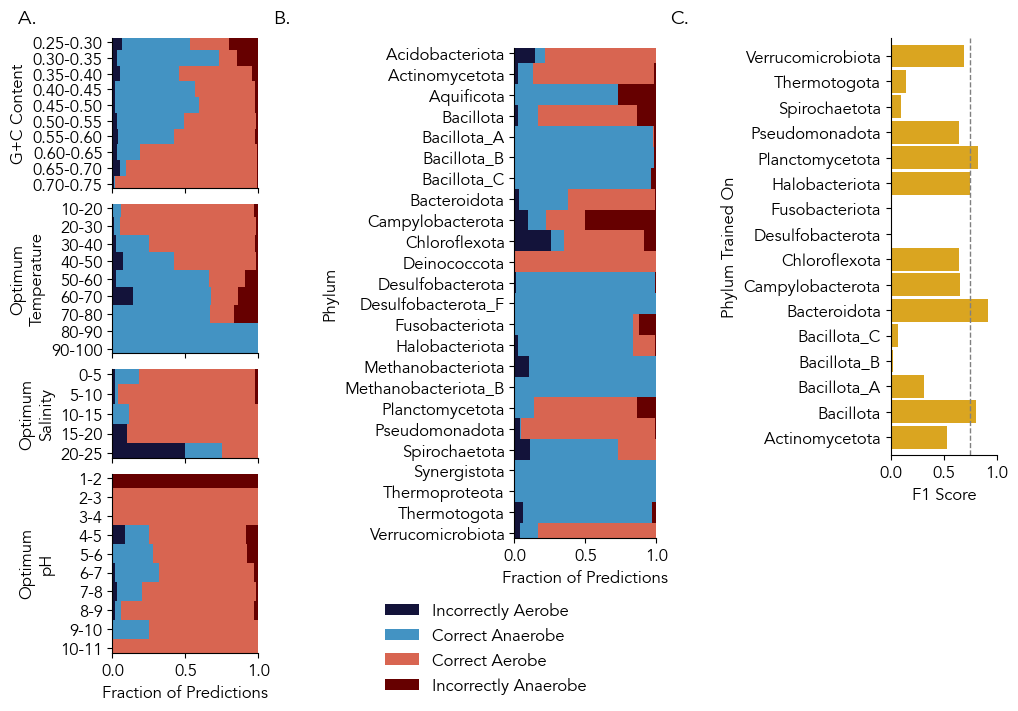

In [173]:
fig = plt.figure(layout="constrained", figsize=(10,7))
subfigs = fig.subfigures(1, 3, wspace=0.07, width_ratios=[1,1.3,1])
axs0 = subfigs[0].subplots(4, 1, gridspec_kw={'height_ratios' : (1,1,0.6,1.2)})
# subfigs[0].suptitle('subfigs[0]\nLeft side')
# fig, axes = plt.subplots(5,1,figsize=(4,12.5), gridspec_kw={'height_ratios' : (1,1,0.6,2,0.6, )}) #1.2,
axl = axs0.flatten()
for n, var in enumerate(['all_nt_C', 'temperature_optimum', 'salinity_optimum', 'ph_optimum']):
    ax = axl[n]
    ax = ax_predictions_along_range(ax, var)
    ax.set_xlim([0,1])
    ymin, ymax = ax.get_ylim()
    ax.set_ylim([ymin+0.5, ymax-0.5])
    if n == len(axl) - 1:
        ax.set_xlabel('Fraction of Predictions')
    else:
        ax.set_xticklabels([])
ax = axl[0]
ax.text(-0.65, 1.1, f"{string.ascii_uppercase[0]}.", transform=ax.transAxes,  size=14)
ax.text(1.1, 1.1, f"{string.ascii_uppercase[1]}.", transform=ax.transAxes,  size=14)
        
axs1 = subfigs[1].subplots(1, 1)

ax = axs1
ax = ax_predictions_by_phylum(ax)
ax.set_xlim([0,1])
ymin, ymax = ax.get_ylim()
ax.set_ylim([ymin+0.5, ymax-0.5])
ax.set_xlabel('Fraction of Predictions')
ax.legend(loc='upper center', bbox_to_anchor=(-0.2, -0.1), frameon=False, ncol=1, columnspacing=0.5)
#ax.set_title('  \n', fontsize=8)
ax.text(1.1, 1.05, f"{string.ascii_uppercase[2]}.", transform=ax.transAxes,  size=14)


# subfigs[1].suptitle('subfigs[1]')
# subfigs[1].supylabel('ylabel for subfigs[1]')

axs2 = subfigs[2].subplots(2, 1, gridspec_kw={'height_ratios' : (2.2,1)})
ax = axs2[0]
axs2[1].set_axis_off()
ax_one_phylum_trained(ax)
ax.set_title('  \n', fontsize=8) # add padding
#plt.tight_layout()
# subfigs[1].suptitle('subfigs[1]')

In [128]:
df_train['y_pred'] = y_valid_pred
df_train[(df_train['all_nt_C'] >= 0.70) & (df_train['oxygen'] < 0.50)  ].sort_values('ncbi_species')


all_nt_length  all_pur_pyr_transition_freq  all_nt_C  all_nt_A  \
GCA_000526155      4236553.0                     0.465461  0.700793  0.299207   
GCA_016583525      5104440.0                     0.558775  0.713511  0.286489   
GCA_016583725      5457049.0                     0.558323  0.706235  0.293765   

               all_total_proteins  all_total_protein_length  all_pis_acidic  \
GCA_000526155              3733.0                 1234035.0        0.249933   
GCA_016583525              4670.0                 1514244.0        0.172591   
GCA_016583725              5008.0                 1599133.0        0.184305   

               all_pis_neutral  all_pis_basic  all_pis_3_4  ...  \
GCA_000526155         0.381998       0.368069          0.0  ...   
GCA_016583525         0.511135       0.316274          0.0  ...   
GCA_016583725         0.495208       0.320487          0.0  ...   

               microaerotolerant    domain              phylum  \
GCA_000526155                NaN  Bacteria  Desulfobacterota_C   
GCA_016583525                NaN  Bacteria      Pseudomonadota   
GCA_016583725                NaN  Bacteria      Pseudomonadota   

                             class             order              family  \
GCA_000526155       Deferrisomatia  Deferrisomatales   Deferrisomataceae   
GCA_016583525  Gammaproteobacteria   Burkholderiales  Burkholderiaceae_B   
GCA_016583725  Gammaproteobacteria   Burkholderiales  Burkholderiaceae_B   

                     genus                   species   ncbi_genus  y_pred  
GCA_000526155  Deferrisoma        Deferrisoma camini  Deferrisoma   False  
GCA_016583525   Rubrivivax    Rubrivivax gelatinosus   Rubrivivax    True  
GCA_016583725   Rubrivivax  Rubrivivax gelatinosus_B   Rubrivivax    True  

[3 rows x 268 columns]

In [174]:
arr, labels = aerobic_predictions_by_taxon(y_train, y_valid_pred, taxon_to_accessions, min_n = 10, norm=False)
df_results = pd.DataFrame(arr)
df_results.columns = columns
df_results.index = labels
df_results = df_results[::-1]
df_results

Incorrectly Aerobe  Correct Anaerobe  Correct Aerobe  \
Verrucomicrobiota                     1                 3              20   
Thermotogota                          2                29               0   
Thermoproteota                        0                13               0   
Synergistota                          0                17               0   
Spirochaetota                         4                23              10   
Pseudomonadota                       32                11             843   
Planctomycetota                       0                 4              21   
Methanobacteriota_B                   0                19               0   
Methanobacteriota                     5                43               0   
Halobacteriota                        2                76              14   
Fusobacteriota                        0                20               1   
Desulfobacterota_F                    0                26               0   
Desulfobacterota                      1               105               0   
Deinococcota                          0                 0              41   
Chloroflexota                         6                 2              13   
Campylobacterota                      9                12              26   
Bacteroidota                         12               145             259   
Bacillota_C                           0                52               0   
Bacillota_B                           0                66               0   
Bacillota_A                           0               259               2   
Bacillota                             2                10              51   
Aquificota                            0                 8               0   
Actinomycetota                        6                28             218   
Acidobacteriota                       2                 1              11   

                     Incorrectly Anaerobe  
Verrucomicrobiota                       0  
Thermotogota                            1  
Thermoproteota                          0  
Synergistota                            0  
Spirochaetota                           0  
Pseudomonadota                          6  
Planctomycetota                         4  
Methanobacteriota_B                     0  
Methanobacteriota                       0  
Halobacteriota                          1  
Fusobacteriota                          3  
Desulfobacterota_F                      0  
Desulfobacterota                        1  
Deinococcota                            0  
Chloroflexota                           2  
Campylobacterota                       48  
Bacteroidota                            3  
Bacillota_C                             2  
Bacillota_B                             1  
Bacillota_A                             5  
Bacillota                              10  
Aquificota                              3  
Actinomycetota                          4  
Acidobacteriota                         0

In [177]:

accuracies = []
for l, label in zip(arr, labels):
    fp, tn, tp, fn = l
    #f1 = (2 * tp) / (2 * tp + fp + fn) 
    ba = balanced_accuracy(fp, tn, tp, fn)
    acc = accuracy(fp, tn, tp, fn)
    print( label, ba,  fp, tn, tp, fn)
    accuracies.append(acc)

np.mean(accuracies)

Acidobacteriota 0.6666666666666666 2 1 11 0
Actinomycetota 0.9027556968733439 6 28 218 4
Aquificota 0.5 0 8 0 3
Bacillota 0.8346994535519126 2 10 51 10
Bacillota_A 0.6428571428571428 0 259 2 5
Bacillota_B 0.5 0 66 0 1
Bacillota_C 0.5 0 52 0 2
Bacteroidota 0.9560582486507512 12 145 259 3
Campylobacterota 0.46138996138996136 9 12 26 48
Chloroflexota 0.5583333333333333 6 2 13 2
Deinococcota nan 0 0 41 0
Desulfobacterota 0.49528301886792453 1 105 0 1
Desulfobacterota_F nan 0 26 0 0
Fusobacteriota 0.625 0 20 1 3
Halobacteriota 0.9538461538461538 2 76 14 1
Methanobacteriota nan 5 43 0 0
Methanobacteriota_B nan 0 19 0 0
Planctomycetota 0.9199999999999999 0 4 21 4
Pseudomonadota 0.6243734078395924 32 11 843 6
Spirochaetota 0.9259259259259259 4 23 10 0
Synergistota nan 0 17 0 0
Thermoproteota nan 0 13 0 0
Thermotogota 0.46774193548387094 2 29 0 1
Verrucomicrobiota 0.875 1 3 20 0


/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_56787/167895466.py:135: RuntimeWarning: invalid value encountered in scalar divide
  term2 = (tn / (tn + fp))
/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_56787/167895466.py:134: RuntimeWarning: invalid value encountered in scalar divide
  term1 = (tp / (tp + fn))


0.9009338118501361

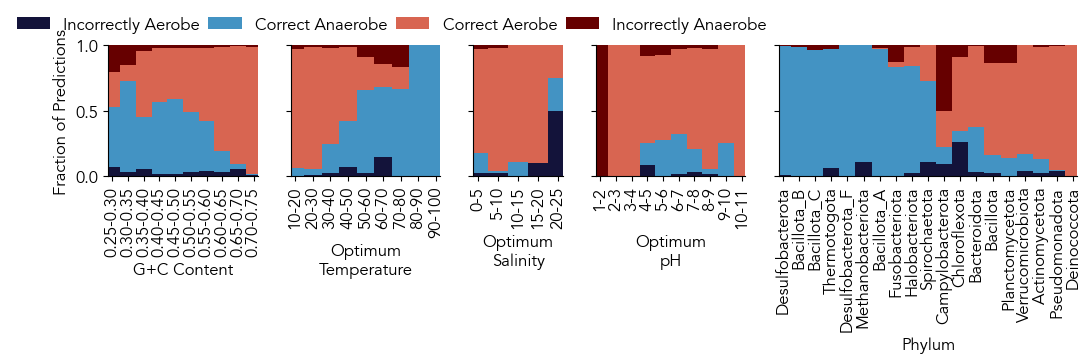

In [131]:
fig, axes = plt.subplots(1,5,figsize=(12.5,1.7,), gridspec_kw={'width_ratios' : (1,1,0.6,1, 2, )}) #1.2,
axl = axes.flatten()
xlabel_kwargs = {
    'rotation' : 'horizontal', 'ha':'center', #'va':'top'
}
for n, var in enumerate(['all_nt_C', 'temperature_optimum', 'salinity_optimum', 'ph_optimum',
                        ]):

    ax = axes[n]
    bin_min = bin_defitions[var]['min']
    bin_max = bin_defitions[var]['max']
    step = bin_defitions[var]['step']

    if var == 'all_nt_C':
        float_prec = 2
    else:
        float_prec = None
    arr, labels = aerobic_predictions_along_range(y_train, y_valid_pred, bin_min=bin_min, bin_max=bin_max, step=step, var=var, 
                                        df_train=df_train, norm=True, randomize=False,float_prec=float_prec
                                        )
    f1 = arr_to_f1(arr)
    stacked = True
    df_results = pd.DataFrame(arr)
    df_results.columns = columns
    df_results.index = labels
    df_results.plot.bar(ax=ax, stacked=True, width=1, color=oxygen_colors, legend=None)
    ax.set_xticklabels(df_results.index, rotation=90)
    ax.set_xlabel(this_plot_formats[var], **xlabel_kwargs)

    
n += 1
ax = axes[n]
arr, labels = aerobic_predictions_by_taxon(y_train, y_valid_pred, taxon_to_accessions, min_n = 20, norm=True)
df_results = pd.DataFrame(arr)
df_results.columns = columns
df_results.index = labels
df_results = df_results.sort_values('Correct Aerobe')
#df_results = df_results[::-1]
df_results.plot.bar(ax=ax, stacked=True, width=1, color=oxygen_colors, legend=None)
ax.set_xticklabels(df_results.index, rotation=90)
ax.set_xlabel('Phylum', **xlabel_kwargs)

from sklearn.metrics import confusion_matrix
norm = True
arr = []
labels = []
for i, (training_indices, validation_indices) in enumerate(cv_sets):
    y_true = y_train[validation_indices]
    y_pred = y_valid_pred[validation_indices] > 0.5
    conf = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf.ravel()
    labels.append(i+1)
    if norm is True:
        arr.append([val / np.sum([fn, tp, tn, fp, ][::-1]) for val in [fn, tp, tn, fp][::-1]])
    else:
        arr.append([fn, tp, tn, fp][::-1])


for n, ax in enumerate(axl):
    ax.set_ylim([0,1])
    xmin, xmax = ax.get_xlim()
    ax.set_xlim([xmin+0.5, xmax-0.5])
    if n == 0:
        ax.set_ylabel('Fraction of Predictions')
    else:
        ax.set_yticklabels([])
    if n == 0:
        ax.legend(loc='upper center', bbox_to_anchor=(1.9, 1.34), frameon=False, ncol=4, columnspacing=0.5)
#plt.tight_layout()

In [236]:
filter = df[(df['all_nt_C'] >= 0.70) & (df['all_nt_C'] < .80)].index
df_train[(y_valid_pred != y_train) & df_train.index.isin(filter)] #['genus'] #.value_counts()

all_nt_length  all_pur_pyr_transition_freq  all_nt_C  all_nt_A  \
GCA_000014185      3225750.0                     0.462585  0.704766  0.295234   
GCA_006363815      5347022.0                     0.516027  0.729329  0.270671   
GCA_016583525      5104440.0                     0.558775  0.713511  0.286489   
GCA_016583725      5457049.0                     0.558323  0.706235  0.293765   

               all_total_proteins  all_total_protein_length  all_pis_acidic  \
GCA_000014185              3140.0                  977188.0        0.348089   
GCA_006363815              4575.0                 1453840.0        0.315847   
GCA_016583525              4670.0                 1514244.0        0.172591   
GCA_016583725              5008.0                 1599133.0        0.184305   

               all_pis_neutral  all_pis_basic  all_pis_3_4  ...  aerotolerant  \
GCA_000014185         0.339809       0.312102          0.0  ...           NaN   
GCA_006363815         0.356940       0.327213          0.0  ...           NaN   
GCA_016583525         0.511135       0.316274          0.0  ...           NaN   
GCA_016583725         0.495208       0.320487          0.0  ...           NaN   

               microaerotolerant    domain          phylum  \
GCA_000014185                NaN  Bacteria  Actinomycetota   
GCA_006363815                NaN  Bacteria  Actinomycetota   
GCA_016583525                NaN  Bacteria  Pseudomonadota   
GCA_016583725                NaN  Bacteria  Pseudomonadota   

                             class                order                family  \
GCA_000014185        Rubrobacteria      Rubrobacterales      Rubrobacteraceae   
GCA_006363815        Actinomycetia  Streptosporangiales  Streptosporangiaceae   
GCA_016583525  Gammaproteobacteria      Burkholderiales    Burkholderiaceae_B   
GCA_016583725  Gammaproteobacteria      Burkholderiales    Burkholderiaceae_B   

                         genus                      species       ncbi_genus  
GCA_000014185    Rubrobacter_B   Rubrobacter_B xylanophilus      Rubrobacter  
GCA_006363815  Thermomonospora  Thermomonospora catenispora  Thermomonospora  
GCA_016583525       Rubrivivax       Rubrivivax gelatinosus       Rubrivivax  
GCA_016583725       Rubrivivax     Rubrivivax gelatinosus_B       Rubrivivax  

[4 rows x 267 columns]

In [233]:
len(df_train[(y_valid_pred != y_train) & df_train.index.isin(filter)])

18

In [194]:
for var, y_min, y_max in [
    ('temperature_optimum', 60, 80),
    ('salinity_optimum', 15, 30),
]:

    indexer = (df_train[var] > y_min) & (df_train[var] < y_max)
    print(var, balanced_accuracy_score(y_train[indexer], y_valid_pred[indexer] * 1))


temperature_optimum 0.7489177489177489
salinity_optimum 0.6666666666666666


In [133]:
var = 'all_nt_C'
bin_min = bin_defitions[var]['min']
bin_max = bin_defitions[var]['max']
step = bin_defitions[var]['step']

if var == 'all_nt_C':
    float_prec = 2
else:
    float_prec = None
arr, labels = aerobic_predictions_along_range(y_train, y_valid_pred, bin_min=bin_min, bin_max=bin_max, step=step, var=var, 
                                    df_train=df_train, norm=True, randomize=False,float_prec=float_prec
                                    )
f1 = arr_to_f1(arr)
f1

0.10645713396960321

In [134]:
# balanced_accuracy
fn, tp, tn, fp = np.split(len(y_train) * np.array(arr).T, 4)

ba = 0.5 * ((tp/(tp+fn)) + (tn/(tn+fp)))
f1 = (2 * tp) / (2*tp + fp + fn)
for f, a, l in zip(f1[0], ba[0], labels):
    print(l, f, a)
print()
for l, p, n in zip(labels, tp[0], tn[0]):
    print(l, (p+n)/len(y_train))

0.25-0.30 0.7741935483870969 0.7220779220779221
0.30-0.35 0.8843537414965985 0.7034313725490197
0.35-0.40 0.8939393939393939 0.902984022556391
0.40-0.45 0.965675057208238 0.9602763150751861
0.45-0.50 0.9696969696969698 0.9615743505524037
0.50-0.55 0.9482071713147411 0.94956454306848
0.55-0.60 0.9249999999999999 0.9332554403388345
0.60-0.65 0.8811188811188811 0.9083008447043535
0.65-0.70 0.5714285714285715 0.7106885919835559
0.70-0.75 0.3333333333333333 0.6605691056910569

0.25-0.30 0.7307692307692308
0.30-0.35 0.8181818181818181
0.35-0.40 0.9044368600682594
0.40-0.45 0.9612403100775193
0.45-0.50 0.9639639639639641
0.50-0.55 0.9498069498069498
0.55-0.60 0.9379310344827587
0.60-0.65 0.9575
0.65-0.70 0.9411764705882353
0.70-0.75 0.9760479041916167


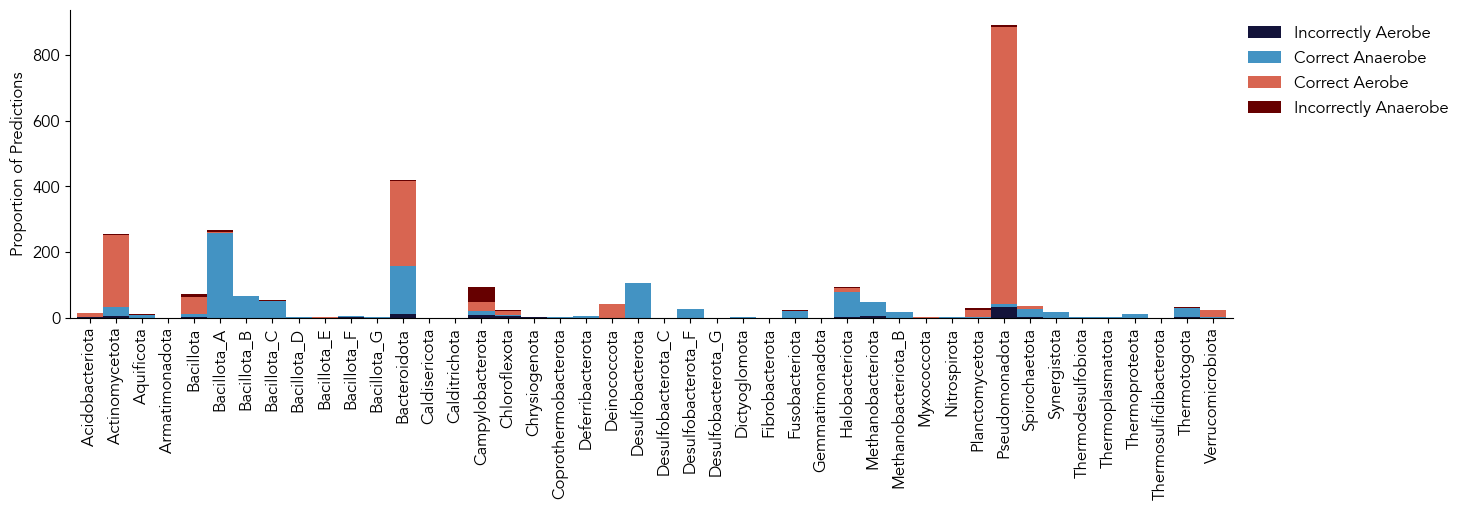

In [71]:
arr, labels = aerobic_predictions_by_taxon(y_train, y_valid_pred, taxon_to_accessions, min_n = 0, norm=False)
arr, labels
fig ,ax = plt.subplots(figsize=(15,4))
ax = ax_bar_aerobic_predictions(ax, arr, labels, columns, oxygen_colors,)
#ax.set_yscale('log')
#ax.set_xlabel('GC Content')

In [72]:

aerobe_indexer = (y_train == 1)
anaerobe_indexer = (y_train == 0)

def score_by_taxon(indexer, col_prefix = '', taxonomy_dict=taxonomy_dict):    
    
    arr_taxa = [taxonomy.taxonomy_dict[accession][taxonomy.indices['phylum']] for accession in df_train[indexer].index.tolist()]
    correct_by_phylum = Counter(zip(arr_taxa, y_train[indexer] == y_valid_pred[indexer]))
    df_by_taxon = pd.DataFrame.from_dict(correct_by_phylum, orient='index')
    df_by_taxon['phylum'] = [index[0] for index in df_by_taxon.index.tolist()]
    df_by_taxon['bool'] = [index[1] for index in df_by_taxon.index.tolist()]
    
    df_by_taxon = pd.pivot(df_by_taxon, index='phylum', values=0, columns='bool').fillna(0).rename(columns={True : 'true', False : 'false'})
    df_by_taxon['accuracy'] = df_by_taxon['true'] / (df_by_taxon['true'] + df_by_taxon['false'])
    df_by_taxon['total'] = df_by_taxon['true'] + df_by_taxon['false']
    df_by_taxon.columns = [col_prefix + col for col in df_by_taxon.columns]
    return df_by_taxon

anaerobes_pred_df = score_by_taxon(anaerobe_indexer, col_prefix = 'anaerobe_')
aerobes_pred_df = score_by_taxon(aerobe_indexer, col_prefix = 'aerobe_')
pred_df = pd.merge(anaerobes_pred_df, aerobes_pred_df, left_index=True, right_index=True, how='outer')
pred_df['total'] = pred_df['aerobe_total'].fillna(0.) + pred_df['anaerobe_total'].fillna(0.)
pred_df['fraction_aerobe'] = pred_df['aerobe_total'].fillna(0.)  / pred_df['total']
pred_df.fillna(0).style.background_gradient(cmap='Blues')

In [73]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

X = pred_df['fraction_aerobe'].values
Y1 = pred_df['aerobe_accuracy'].values
Y2 = pred_df['anaerobe_accuracy'].values

S1 = 5 * pred_df['aerobe_total'].fillna(0)
S2 = 5 * pred_df['anaerobe_total'].fillna(0)
ax = axes[0]
ax.set_title('Aerobes',fontsize=16, )
ax.scatter(X, Y1, edgecolor='cornflowerblue', facecolor='None', lw=1,  s=S1, label='Aerobes', clip_on=False)
ax.set_xlabel('Fraction Aerobic')
ax = axes[1]
ax.set_title('Anaerobes',fontsize=16, )
ax.scatter(1 - X, Y2, edgecolor='cornflowerblue', facecolor='None', lw=1,s=S2, label='Anaerobes', clip_on=False)
ax.set_xlabel('Fraction Anaerobic')
for ax in axes:
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_ylabel('Accuracy')
plt.show()



### Specific phyla

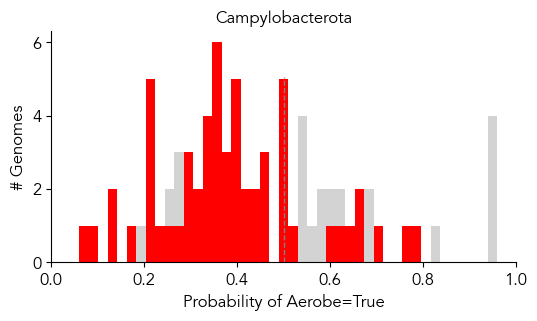

In [74]:
#phylum='Aquificota'
#phylum = 'Bacillota'
#phylum = 'Chloroflexota'
phylum = 'Campylobacterota'
#phylum = 'Actinomycetota'
#phylum = 'Pseudomonadota'
#phylum = 'Bacteroidota'
#phylum = 'Bacillota_A'

indexer = (df_train.index.map(phylum_dict) == phylum)

fig, ax = plt.subplots(figsize=(6,3))
ax.set_title(phylum)
ax.set_ylabel('# Genomes' )
ax.set_xlabel('Probability of Aerobe=True')
bins = np.linspace(0, 1, 50)
hist1, bins, _ = ax.hist(y_valid_pred_probs[(y_train == y_valid_pred) & indexer], bins=bins, color='lightgray', label='Correct predictions', alpha=1)
hist2, bins, _ = ax.hist(y_valid_pred_probs[(y_train != y_valid_pred) & indexer], bins=bins, color='red', label='Incorrect', alpha=1)
ax.axvline(x=0.5, linestyle='--', ymax=0.8)
ax.set_xlim([0,1])
plt.show()

### Genera Missed

In [197]:

def count_genera_from_indices(data, indices):
    species = data.loc[indices]['ncbi_species'].tolist()
    genera = [spec.split(' ')[0] for spec in species]
    count = Counter(genera)
    return count


focus = 1
false_pred = df_full[(y_full_pred != y_full) & (y_full == focus)].index.tolist()
true_not = df_full[(y_full == np.abs(1-focus))].index.tolist()
data = df_full

count_false = count_genera_from_indices(data, false_pred)
count_true = count_genera_from_indices(data, true_not)
count_total = Counter([species.split(' ')[0] for species in data['ncbi_species'].dropna().tolist()])

df_counts = pd.concat([pd.Series(count_false), pd.Series(count_true), pd.Series(count_total)], axis=1).fillna(0)
df_counts.columns = [f'count_missed_{focus}', f'count_true_{np.abs(1-focus)}', 'count_total']
df_counts = df_counts[df_counts[f'count_missed_{focus}'] > 0]
df_counts[f'%_genus_missed_{focus}'] = 100 * df_counts[f'count_missed_{focus}'] / df_counts['count_total']
df_counts[f'%_genus_true_{np.abs(1-focus)}'] = 100 * df_counts[f'count_true_{np.abs(1-focus)}'] / df_counts['count_total']

df_counts = df_counts.sort_values(f'count_missed_{focus}', ascending=False)
df_counts['cumsum'] = np.cumsum(df_counts[f'count_missed_{focus}'] / df_counts[f'count_missed_{focus}'].sum())
sum_to_1 = (df_counts[f'count_missed_{focus}'] + df_counts[f'count_true_{np.abs(1-focus)}'] == df_counts['count_total']) & (df_counts[f'count_true_{np.abs(1-focus)}'] != 0)
genus_has_other = (df_counts[f'count_true_{np.abs(1-focus)}'] >= 1)
print(100 * (df_counts[genus_has_other][f'count_missed_{focus}'].sum() / df_counts[f'count_missed_{focus}'].sum()))
df_counts[genus_has_other]



40.17094017094017


count_missed_0  count_true_1  count_total  %_genus_missed_0  \
Sulfurospirillum             6.0           1.0            8         75.000000   
Rhodovulum                   5.0           1.0            6         83.333333   
Bifidobacterium              3.0           2.0            5         60.000000   
Sulfurimonas                 2.0           2.0            4         50.000000   
Chloroflexus                 2.0           1.0            3         66.666667   
Rhodoferax                   2.0           3.0            5         40.000000   
Marinobacter                 2.0          14.0           16         12.500000   
Rhodobacter                  2.0           3.0            5         40.000000   
Rhodoblastus                 2.0           1.0            3         66.666667   
Magnetospirillum             2.0           2.0            4         50.000000   
Zymomonas                    1.0           1.0            2         50.000000   
Rhodoplanes                  1.0           1.0            2         50.000000   
Schaalia                     1.0           1.0            2         50.000000   
Streptococcus                1.0           5.0            6         16.666667   
Algoriphagus                 1.0           8.0            9         11.111111   
Vibrio                       1.0          13.0           14          7.142857   
Pseudovibrio                 1.0           3.0            4         25.000000   
Desulfovibrio                1.0           1.0           15          6.666667   
Pseudomonas                  1.0         100.0          101          0.990099   
Brevundimonas                1.0          12.0           13          7.692308   
Halarchaeum                  1.0           2.0            3         33.333333   
Enterobacter                 1.0           9.0           10         10.000000   
Rheinheimera                 1.0           2.0            3         33.333333   
Simplicispira                1.0           1.0            2         50.000000   
Neisseria                    1.0          10.0           11          9.090909   
Colwellia                    1.0           3.0            4         25.000000   
Leptospira                   1.0           1.0            2         50.000000   
Aureimonas                   1.0           4.0            5         20.000000   
Spirochaeta                  1.0           1.0            4         25.000000   

                  %_genus_true_1    cumsum  
Sulfurospirillum       12.500000  0.051282  
Rhodovulum             16.666667  0.179487  
Bifidobacterium        40.000000  0.205128  
Sulfurimonas           50.000000  0.247863  
Chloroflexus           33.333333  0.264957  
Rhodoferax             60.000000  0.316239  
Marinobacter           87.500000  0.333333  
Rhodobacter            60.000000  0.350427  
Rhodoblastus           33.333333  0.367521  
Magnetospirillum       50.000000  0.435897  
Zymomonas              50.000000  0.461538  
Rhodoplanes            50.000000  0.495726  
Schaalia               50.000000  0.504274  
Streptococcus          83.333333  0.512821  
Algoriphagus           88.888889  0.529915  
Vibrio                 92.857143  0.572650  
Pseudovibrio           75.000000  0.606838  
Desulfovibrio           6.666667  0.615385  
Pseudomonas            99.009901  0.752137  
Brevundimonas          92.307692  0.760684  
Halarchaeum            66.666667  0.769231  
Enterobacter           90.000000  0.811966  
Rheinheimera           66.666667  0.854701  
Simplicispira          50.000000  0.880342  
Neisseria              90.909091  0.888889  
Colwellia              75.000000  0.897436  
Leptospira             50.000000  0.905983  
Aureimonas             80.000000  0.931624  
Spirochaeta            25.000000  0.940171

In [217]:
anaerobic_genera = set(df_train[df_train['oxygen'] == 0]['genus'].tolist())
aerobic_genera = set(df_train[df_train['oxygen'] == 1]['genus'].tolist())

genera_with_both = aerobic_genera.intersection(anaerobic_genera)

incorrect_df = df_train[(y_train != y_valid_pred)]

len(incorrect_df[incorrect_df['genus'].isin(genera_with_both)]) / len(incorrect_df)

0.2620320855614973

0.06857352401906858

In [196]:
query_indices = df[df['ncbi_species'].isin(['Aquifex aeolicus',
 'Balnearium lithotrophicum',
 'Desulfurobacterium atlanticum',
 'Desulfurobacterium indicum',
 'Desulfurobacterium thermolithotrophum',
 'Hydrogenivirga caldilitoris',
 'Hydrogenobacter hydrogenophilus',
 'Hydrogenobacter thermophilus',
 'Hydrogenothermus marinus',
 'Persephonella atlantica',
 'Persephonella hydrogeniphila',
 'Persephonella marina',
 'Phorcysia thermohydrogeniphila',
 'Sulfurihydrogenibium azorense',
 'Sulfurihydrogenibium subterraneum',
 'Sulfurihydrogenibium yellowstonense',
 'Thermocrinis albus',
 'Thermocrinis minervae',
 'Thermocrinis ruber',
 'Thermovibrio ammonificans',
 'Thermovibrio guaymasensis'])].index


df_full.reindex(query_indices) #['oxygen']

all_nt_length  all_pur_pyr_transition_freq  all_nt_C  all_nt_A  \
GCA_003664005      1753431.0                     0.408219  0.462137  0.537863   
GCA_900215655            NaN                          NaN       NaN       NaN   
GCA_000191045      1541970.0                     0.395300  0.349486  0.650514   
GCA_000173615            NaN                          NaN       NaN       NaN   
GCA_003688665            NaN                          NaN       NaN       NaN   
GCA_004339575      1621426.0                     0.389788  0.449414  0.550586   
GCA_900142435      1367923.0                     0.426379  0.445235  0.554765   
GCA_000185805      1759530.0                     0.399773  0.521298  0.478702   
GCA_000025605      1500579.0                     0.428727  0.469305  0.530695   
GCA_001968985      1607531.0                     0.419094  0.381653  0.618347   
GCA_000021545            NaN                          NaN       NaN       NaN   
GCA_010588305            NaN                          NaN       NaN       NaN   
GCA_000512735            NaN                          NaN       NaN       NaN   
GCA_000164905      1742934.0                     0.427791  0.440009  0.559991   
GCA_900188395      1739394.0                     0.409113  0.365086  0.634914   
GCA_000619805            NaN                          NaN       NaN       NaN   
GCA_900215515            NaN                          NaN       NaN       NaN   
GCA_003633715      1621736.0                     0.380604  0.431898  0.568102   
GCA_900182585      1727582.0                     0.385657  0.411552  0.588448   

               all_total_proteins  all_total_protein_length  all_pis_acidic  \
GCA_003664005              1885.0                  560018.0        0.258886   
GCA_900215655                 NaN                       NaN             NaN   
GCA_000191045              1509.0                  478199.0        0.156395   
GCA_000173615                 NaN                       NaN             NaN   
GCA_003688665                 NaN                       NaN             NaN   
GCA_004339575              1646.0                  510198.0        0.219927   
GCA_900142435              1463.0                  436118.0        0.172932   
GCA_000185805              1813.0                  550008.0        0.198566   
GCA_000025605              1593.0                  478791.0        0.161331   
GCA_001968985              1617.0                  493271.0        0.186766   
GCA_000021545                 NaN                       NaN             NaN   
GCA_010588305                 NaN                       NaN             NaN   
GCA_000512735                 NaN                       NaN             NaN   
GCA_000164905              1869.0                  552849.0        0.147138   
GCA_900188395              1769.0                  541950.0        0.193895   
GCA_000619805                 NaN                       NaN             NaN   
GCA_900215515                 NaN                       NaN             NaN   
GCA_003633715              1662.0                  509527.0        0.200963   
GCA_900182585              1877.0                  550590.0        0.210975   

               all_pis_neutral  all_pis_basic  all_pis_3_4  ...  aerotolerant  \
GCA_003664005         0.411141       0.329973          0.0  ...           NaN   
GCA_900215655              NaN            NaN          NaN  ...           NaN   
GCA_000191045         0.323393       0.520212          0.0  ...           NaN   
GCA_000173615              NaN            NaN          NaN  ...           NaN   
GCA_003688665              NaN            NaN          NaN  ...           NaN   
GCA_004339575         0.356622       0.423451          0.0  ...           NaN   
GCA_900142435         0.455229       0.371839          0.0  ...           NaN   
GCA_000185805         0.345836       0.455598          0.0  ...           NaN   
GCA_000025605         0.465160       0.373509          0.0  ...           NaN   
GCA

## Other models

In [77]:

condition = 'oxygen'
target = 'oxygen'
rank = 'family'
selected_feature_set = 'aas'
features = feature_set_dict[selected_feature_set]
train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
cv_sets = taxonomic_cv_sets_dict[condition][rank]
df_train = df.loc[train_set]
X_train = df_train[features]
y_train = df_train[target]

### Variable Features

In [78]:
rename_base_vars = {
    'nt_C' : 'G+C Content',
    'pur_pyr_transition_freq' : 'R>Y Transitions',
    'protein_coding_density' : 'Coding Density',
    'mean_protein_length' : 'Protein Length',
    'mean_gravy' : 'Hydropathy',
    'mean_nh2o' : 'nH2O',
    'mean_zc' : 'zC',
    'mean_pi' : 'pI',
    'proportion_R_RK' : 'R/R+K',
    'mean_thermostable_freq' : 'Thermostable Residues',
}
rename_base_vars.update({s : s.split('_')[-1] for s in BASE_VARS_AAS})
rename_base_vars.update({s : 'pI ' + '-'.join(s.split('_')[1:]) for s in BASE_VARS_PIS})
rename_base_vars.keys()

dict_keys(['nt_C', 'pur_pyr_transition_freq', 'protein_coding_density', 'mean_protein_length', 'mean_gravy', 'mean_nh2o', 'mean_zc', 'mean_pi', 'proportion_R_RK', 'mean_thermostable_freq', 'aa_A', 'aa_C', 'aa_D', 'aa_E', 'aa_F', 'aa_G', 'aa_H', 'aa_I', 'aa_K', 'aa_L', 'aa_M', 'aa_N', 'aa_P', 'aa_Q', 'aa_R', 'aa_S', 'aa_T', 'aa_V', 'aa_W', 'aa_Y', 'pis_4_5', 'pis_5_6', 'pis_6_7', 'pis_7_8', 'pis_8_9', 'pis_9_10', 'pis_10_11', 'pis_11_12'])

#### LOO

In [79]:
len(cv_sets[0][0]), df_train.shape, len(train_set)

(2174, (2727, 266), 2727)

Text(0.5, 0, 'Left Out Variable')

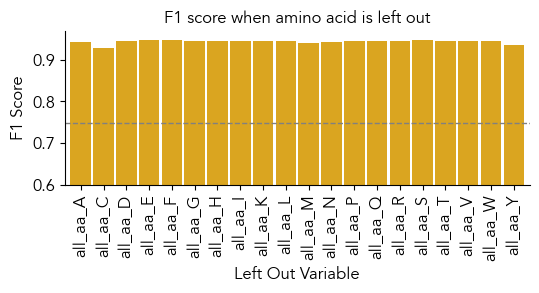

In [80]:
f1_when_left_out = {}

for i, aa in enumerate(features):
    loo_variables = features[:i] + features[i+1:]
    left_out = features[i]
    pipe, y_train_pred, y_valid_pred = predict_training_and_cv(df_train[loo_variables], y_train,
                                                               pipeline=make_pipeline(StandardScaler(), LogisticRegression()), 
                                                               cv=yield_cv_sets(cv_sets))
    f1 = f1_score(y_train, y_valid_pred)
    f1_when_left_out[aa] = f1

fig, ax = plt.subplots(figsize=(6,2))
pd.Series(f1_when_left_out).plot.bar(ax=ax, width=0.9, color='goldenrod')
y_baseline = f1_score(baseline_results[target][rank]['y_train'], baseline_results[target][rank]['y_valid_pred'])
ax.axhline(y_baseline, color='gray', linestyle='--')
ax.set_ylim([0.6, 0.97])
ax.set_title("F1 score when amino acid is left out")
ax.set_ylabel("F1 Score")
ax.set_xlabel("Left Out Variable")

#### 1 at a time

Text(0.5, 0, 'Variable')

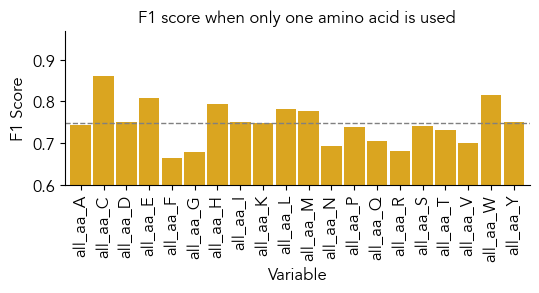

In [81]:
f1_when_only = {}
for i, aa in enumerate(features):
    variables = [aa]
    pipe, y_train_pred, y_valid_pred = predict_training_and_cv(df_train[variables], y_train,
                                                               pipeline=make_pipeline(StandardScaler(), LogisticRegression()), 
                                                               cv=yield_cv_sets(cv_sets))
    f1 = f1_score(y_train, y_valid_pred)
    f1_when_only[aa] = f1

fig, ax = plt.subplots(figsize=(6,2))
pd.Series(f1_when_only).plot.bar(ax=ax, width=0.9, color='goldenrod')
y_baseline = f1_score(baseline_results[target][rank]['y_train'], baseline_results[target][rank]['y_valid_pred'])
ax.axhline(y_baseline, color='gray', linestyle='--')
ax.set_ylim([0.6, 0.97])
ax.set_title("F1 score when only one amino acid is used")
ax.set_ylabel("F1 Score")
ax.set_xlabel("Variable")

#### 2 at a time

In [184]:
from itertools import combinations
f1_pairs = {}
for i, aas in enumerate(combinations(sorted(features), 2)):
    variables = [*aas]
    pipe, y_train_pred, y_valid_pred = predict_training_and_cv(df_train[variables], y_train,
                                                               pipeline=make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced')), 
                                                               cv=yield_cv_sets(cv_sets))
    f1 = f1_score(y_train, y_valid_pred)
    #f1 = balanced_accuracy_score(y_train, y_valid_pred)
    f1_pairs[aas] = f1

fig, ax = plt.subplots(figsize=(6,2))
pd.Series(f1_pairs).plot.bar(ax=ax, width=0.9, color='goldenrod')
y_baseline = f1_score(baseline_results[target][rank]['y_train'], baseline_results[target][rank]['y_valid_pred'])
ax.axhline(y_baseline, color='gray', linestyle='--')
ax.set_ylim([0.6, 0.97])
ax.set_title("F1 score when 2 amino acids are used")
ax.set_ylabel("F1 Score")
ax.set_xlabel("Variable")

Text(0.5, 0, 'Variable')

In [185]:
from itertools import permutations
f1_pairs
full_pairs = {}
for aa1 in sorted(features):
    for aa2 in sorted(features):
        forward_value = f1_pairs.get((aa1, aa2), None)
        if forward_value is not None:
            value = forward_value
        else:
            value = f1_pairs.get((aa2, aa1), np.nan)
            
        full_pairs[(aa1, aa2)] = value
        full_pairs[(aa2, aa1)] = value



In [186]:
from genome_spot.model_training.run_model_selection import BASE_VARS_AAS
rename_vars = {f"all_{s}" : s.split('_')[-1] for s in BASE_VARS_AAS}
rename_vars

{'all_aa_A': 'A',
 'all_aa_C': 'C',
 'all_aa_D': 'D',
 'all_aa_E': 'E',
 'all_aa_F': 'F',
 'all_aa_G': 'G',
 'all_aa_H': 'H',
 'all_aa_I': 'I',
 'all_aa_K': 'K',
 'all_aa_L': 'L',
 'all_aa_M': 'M',
 'all_aa_N': 'N',
 'all_aa_P': 'P',
 'all_aa_Q': 'Q',
 'all_aa_R': 'R',
 'all_aa_S': 'S',
 'all_aa_T': 'T',
 'all_aa_V': 'V',
 'all_aa_W': 'W',
 'all_aa_Y': 'Y'}

In [187]:


pairs_df = pd.DataFrame.from_dict(full_pairs, orient='index')
pairs_df.columns = ['f1']
pairs_df['aa_1'] = [aas[0] for aas in pairs_df.index.tolist()]
pairs_df['aa_2'] = [aas[1] for aas in pairs_df.index.tolist()]
pairs_df = pd.pivot(pairs_df, index='aa_1', columns='aa_2', values='f1').T

def ax_two_aa_heatmap(fig, ax, pairs_df):

    x_variables = pairs_df.columns
    y_ticklabels = [rename_vars[var] for var in pairs_df.index]
    x_ticklabels = [rename_vars[var] for var in pairs_df.columns]
    c = ax.pcolormesh(range(len(x_variables)), range(len(y_ticklabels)), 
                      pairs_df.values, 
                      cmap='gray_r', vmin=0.75, vmax=pairs_df.max().max(), edgecolor='black', linewidth=0.5, clip_on=False)
    #ax.set_title(f'{method.capitalize()} Correlation Coefficients of Select Variables\n')
    ax.set_title(plot_formats[target].replace(', Optimum', ''))
    ax.set_xticks(range(len(x_variables)))
    ax.set_yticks(range(len(y_ticklabels)))
    ax.set_xticklabels(x_ticklabels, rotation=0, ha='center')
    ax.set_yticklabels(y_ticklabels)
    fig.colorbar(c, ax=ax,  aspect=20, label='F1')
    return ax
fig, ax = plt.subplots(figsize=(6.2,5))
ax= ax_two_aa_heatmap(fig, ax, pairs_df)

In [188]:
pairs_df

aa_1      all_aa_A  all_aa_C  all_aa_D  all_aa_E  all_aa_F  all_aa_G  \
aa_2                                                                   
all_aa_A       NaN  0.857591  0.724900  0.801899  0.765763  0.806723   
all_aa_C  0.857591       NaN  0.829086  0.907158  0.844099  0.826524   
all_aa_D  0.724900  0.829086       NaN  0.803263  0.698742  0.658472   
all_aa_E  0.801899  0.907158  0.803263       NaN  0.793060  0.797344   
all_aa_F  0.765763  0.844099  0.698742  0.793060       NaN  0.639597   
all_aa_G  0.806723  0.826524  0.658472  0.797344  0.639597       NaN   
all_aa_H  0.791917  0.911023  0.771168  0.812617  0.755825  0.781983   
all_aa_I  0.733842  0.879450  0.743208  0.809434  0.771692  0.750391   
all_aa_K  0.727333  0.874222  0.737283  0.806675  0.789031  0.780922   
all_aa_L  0.751722  0.861566  0.771918  0.814465  0.710415  0.724750   
all_aa_M  0.737617  0.829390  0.734087  0.845646  0.708166  0.722606   
all_aa_N  0.797789  0.839170  0.682739  0.796850  0.681270  0.655490   
all_aa_P  0.721739  0.846251  0.717881  0.802153  0.718882  0.758532   
all_aa_Q  0.809943  0.906642  0.720885  0.795719  0.682464  0.801619   
all_aa_R  0.774490  0.833073  0.680119  0.798865  0.660881  0.676529   
all_aa_S  0.778281  0.832767  0.540632  0.801260  0.703599  0.675114   
all_aa_T  0.741678  0.813117  0.632507  0.799748  0.674722  0.658311   
all_aa_V  0.774109  0.834519  0.570727  0.797353  0.701121  0.645183   
all_aa_W  0.789206  0.899445  0.810878  0.826344  0.814224  0.817901   
all_aa_Y  0.742188  0.851479  0.751041  0.807644  0.782119  0.788697   

aa_1      all_aa_H  all_aa_I  all_aa_K  all_aa_L  all_aa_M  all_aa_N  \
aa_2                                                                   
all_aa_A  0.791917  0.733842  0.727333  0.751722  0.737617  0.797789   
all_aa_C  0.911023  0.879450  0.874222  0.861566  0.829390  0.839170   
all_aa_D  0.771168  0.743208  0.737283  0.771918  0.734087  0.682739   
all_aa_E  0.812617  0.809434  0.806675  0.814465  0.845646  0.796850   
all_aa_F  0.755825  0.771692  0.789031  0.710415  0.708166  0.681270   
all_aa_G  0.781983  0.750391  0.780922  0.724750  0.722606  0.655490   
all_aa_H       NaN  0.792464  0.793244  0.769524  0.818444  0.755584   
all_aa_I  0.792464       NaN  0.740239  0.764762  0.765343  0.795766   
all_aa_K  0.793244  0.740239       NaN  0.759105  0.747195  0.822078   
all_aa_L  0.769524  0.764762  0.759105       NaN  0.736498  0.712891   
all_aa_M  0.818444  0.765343  0.747195  0.736498       NaN  0.720131   
all_aa_N  0.755584  0.795766  0.822078  0.712891  0.720131       NaN   
all_aa_P  0.791497  0.732068  0.723349  0.729458  0.727575  0.790815   
all_aa_Q  0.742175  0.793352  0.817418  0.686435  0.850957  0.732570   
all_aa_R  0.774537  0.796894  0.798503  0.731190  0.723545  0.669990   
all_aa_S  0.759542  0.782717  0.773167  0.677118  0.729589  0.707475   
all_aa_T  0.778159  0.748737  0.747423  0.773325  0.715860  0.694899   
all_aa_V  0.757653  0.765707  0.772164  0.695681  0.730707  0.681270   
all_aa_W  0.810543  0.801363  0.805952  0.795181  0.831030  0.826477   
all_aa_Y  0.795188  0.749431  0.752164  0.768548  0.752215  0.781950   

aa_1      all_aa_P  all_aa_Q  all_aa_R  all_aa_S  all_aa_T  all_aa_V  \
aa_2                                                                   
all_aa_A  0.721739  0.809943  0.774490  0.778281  0.741678  0.774109   
all_aa_C  0.846251  0.906642  0.833073  0.832767  0.813117  0.834519   
all_aa_D  0.717881  0.720885  0.680119  0.540632  0.632507  0.570727   
all_aa_E  0.802153  0.795719  0.798865  0.801260  0.799748  0.797353   
all_aa_F  0.718882  0.682464  0.660881  0.703599  0.674722  0.701121   
all_aa_G  0.758532  0.801619  0.676529  0.675114  0.658311  0.645183   
all_aa_H  0.791497  0.742175  0.774537  0.759542  0.778159  0.757653   
all_aa_I  0.732068  0.793352  0.796894  0.782717  0.748737  0.765707   
all_aa_K  0.723349  0.817418  0.798503  0.773167  0.747423  0.772164   
all_aa_L  0.729458  0.686435  0.731190

In [87]:

class OxygenTwoAA():
    def __init__(self):
        pass
    def fit_and_convert_to_data(self, x1, x2):
        condition = target = 'oxygen'
        train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
        X_train = df_train[[x1, x2]].values
        y_train = df_train[target].values
        X_test = df.loc[test_set, features].values
        y_test = df.loc[test_set, target].values
        
        pipeline = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced'))
        pipe, y_train_pred, y_valid_pred = predict_training_and_cv(X_train, y_train, pipeline=pipeline, cv=yield_cv_sets(cv_sets))
        scaler = pipe[0]
        model = pipe[-1]
        
        def decision_boundary(x1 ,b0=model.intercept_[0], b1=model.coef_.T[0], b2=model.coef_.T[1]):
            return -(b0 + b1*x1) / b2
        
        def inverse_transform(z, X):
            return X.std() * z + X.mean()
        
        def inverse_transform_data(X_train, scaler):
            xd_scaled = np.array([scaler.transform(X_train)[:, 0].min(), scaler.transform(X_train)[:, 0].max()])
            yd_scaled = decision_boundary(xd_scaled)
            xd = inverse_transform(xd_scaled, X_train[:, 0])
            yd = inverse_transform(yd_scaled, X_train[:, 1])
            m = (yd[1] - yd[0]) / (xd[1] - xd[0])
            b = yd[1] - m * xd[1]
            return m, b, xd, yd
        
        m, b, xd, yd = inverse_transform_data(X_train, scaler)
        return m, b, xd, yd


def axes_example_classification(axes, x1, x2):

    aerobe_dict = {0 : 'Anaerobes', 1 : 'Aerobes'}
    color_dict = {0 : '#0E95C8', 1 : plt.get_cmap("RdBu_r")(0.83)}
    
    
  
    m, b, xd, yd = OxygenTwoAA().fit_and_convert_to_data(x1, x2)
    print(f"It's an aerobe if `(({x2} - {b:.4f}) / {x1}) > {m:.4f}`")
    
    
    i = 0
    ax = axes[0]
    #ax.text(-0.2, 1.1, f"{string.ascii_uppercase[i]}.", transform=ax.transAxes,  size=14)
    
    for n, name in enumerate([1,0]):
        ax = axes[n]
        group = df[(df['oxygen'] == name) & ~df[x1].isnull() & ~df[x2].isnull()]
        X1 = group[x1]
        X2 = group[x2]
        ax.scatter(X1, X2, s=5, alpha=1, clip_on=False, color=color_dict[name],label=aerobe_dict[name])
        axes[np.abs(n-1)].scatter(X1, X2, s=5, alpha=1, color='lightgray', zorder=0) #, label=aerobe_dict[name]
        ax.plot(xd, yd, 'k', lw=1, ls='--')
        ax.set_xlabel(rename_base_vars['_'.join(x1.split('_')[1:])])
        ax.set_ylabel(rename_base_vars['_'.join(x2.split('_')[1:])])
        ax.set_title(aerobe_dict[name])
        #ax.text(0.05, 0.95, f"y = {m:.4f} * x + {b:.4f}", transform=ax.transAxes)
    return axes

fig, axes = plt.subplots(1,2, figsize=(9,4.5))
x1 = "all_aa_C"
x2 = "all_aa_E"
axes_example_classification(axes, x1, x2)
plt.tight_layout()

It's an aerobe if `((all_aa_E - 0.1032) / all_aa_C) > -3.7319`


It's an aerobe if `((all_aa_H - 0.0043) / all_aa_C) > 1.5486`
It's an aerobe if `((all_aa_W - -0.0016) / all_aa_C) > 1.3123`
It's an aerobe if `((all_aa_E - 0.1032) / all_aa_C) > -3.7319`


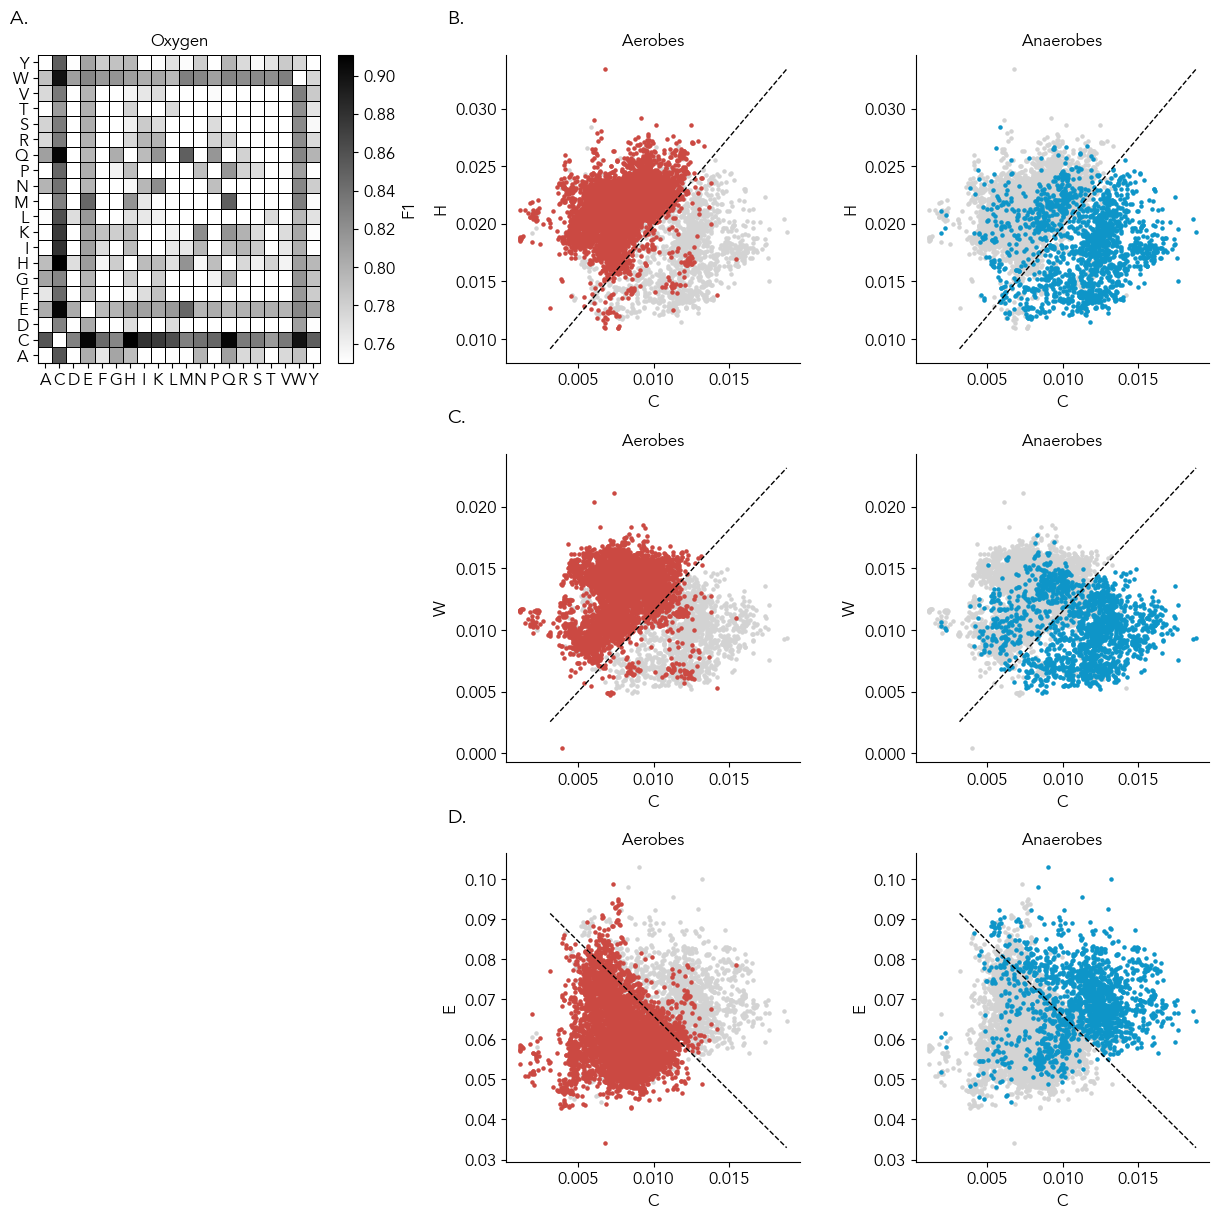

In [88]:
# supp fig
x1 = "all_aa_C"
pairs_to_compare = [
    (x1, "all_aa_H"),
    (x1, "all_aa_W"),
    (x1, "all_aa_E"),
]
fig, axes = plt.subplots(3, 3, figsize=(12,12), gridspec_kw={'width_ratios' : (1.2, 1, 1)})
fig.delaxes(axes[1, 0])
fig.delaxes(axes[2, 0])

i = 0
ax = axes[0, i]
ax = ax_two_aa_heatmap(fig, ax, pairs_df)
ax.text(-0.1, 1.1, f"{string.ascii_uppercase[0]}.", transform=ax.transAxes,  size=14)

x1, x2 = pairs_to_compare[i]
ax_pair = axes[0, 1:3]
ax = ax_pair[0]
ax_pair = axes_example_classification(ax_pair, x1, x2)
ax.text(-0.2, 1.1, f"{string.ascii_uppercase[1]}.", transform=ax.transAxes,  size=14)

m, b, xd, yd = OxygenTwoAA().fit_and_convert_to_data(x1, x2)
text1 = f"{x2[-1]} = {m:.4f} * {x1[-1]} + {b:.4f}"
#text1 = f"(({x2[-1]} - {b:.4f}) / {x1[-1]}) > {m:.4f}"
    
i = 1
x1, x2 = pairs_to_compare[i]
ax_pair = axes[i][1:]
ax = ax_pair[0]
ax_pair = axes_example_classification(ax_pair, x1, x2)
ax.text(-0.2, 1.1, f"{string.ascii_uppercase[2]}.", transform=ax.transAxes,  size=14)
m, b, xd, yd = OxygenTwoAA().fit_and_convert_to_data(x1, x2)
text2 = f"{x2[-1]} = {m:.4f} * {x1[-1]} + {b:.4f}"
i = 2
x1, x2 = pairs_to_compare[i]
ax_pair = axes[i][1:]
ax = ax_pair[0]
ax_pair = axes_example_classification(ax_pair, x1, x2)
ax.text(-0.2, 1.1, f"{string.ascii_uppercase[3]}.", transform=ax.transAxes,  size=14)
m, b, xd, yd = OxygenTwoAA().fit_and_convert_to_data(x1, x2)
text3 = f"{x2[-1]} = {m:.4f} * {x1[-1]} + {b:.4f}"

# for n, text in enumerate([text1, text2, text3]):
#     ax = axes[2,1]
#     ax.text(0, -0.1 - (0.1 * n), s=text, transform=ax.transAxes)

plt.tight_layout(pad=0.1)

In [89]:
for n, text in enumerate([text1, text2, text3]):
    print(text)

H = 1.5486 * C + 0.0043
W = 1.3123 * C + -0.0016
E = -3.7319 * C + 0.1032


In [90]:
# df['ncbi_genus'] = [species.split(' ')[0] for species in df['ncbi_species'].dropna().tolist()]
# data = df[~df['oxygen'].isnull() & ~df[x1].isnull() & ~df[x2].isnull()]

# X1 = data[x1]
# X2 = data[x2]
# y_true = data['oxygen']
# y_pred = classify_aerobe(X2, X1)

# focus = 1
# false_pred = y_true[(y_true != y_pred) & (y_true == focus)].index
# true_not = y_true[(y_true == np.abs(1-focus))].index
# x1, x2

# def count_genera_from_indices(data, indices):
#     species = data.loc[indices]['ncbi_species'].tolist()
#     genera = [spec.split(' ')[0] for spec in species]
#     count = Counter(genera)
#     return count
    
# count_false = count_genera_from_indices(data, false_pred)
# count_true = count_genera_from_indices(data, true_not)
# count_total = Counter([species.split(' ')[0] for species in data['ncbi_species'].dropna().tolist()])

# df_counts = pd.concat([pd.Series(count_false), pd.Series(count_true), pd.Series(count_total)], axis=1).fillna(0)
# df_counts.columns = [f'count_missed_{focus}', f'count_true_{np.abs(1-focus)}', 'count_total']
# df_counts = df_counts[df_counts[f'count_missed_{focus}'] > 0]
# df_counts[f'%_genus_missed_{focus}'] = 100 * df_counts[f'count_missed_{focus}'] / df_counts['count_total']
# df_counts[f'%_genus_true_{np.abs(1-focus)}'] = 100 * df_counts[f'count_true_{np.abs(1-focus)}'] / df_counts['count_total']

# df_counts = df_counts.sort_values(f'count_missed_{focus}', ascending=False)
# df_counts['cumsum'] = np.cumsum(df_counts[f'count_missed_{focus}'] / df_counts[f'count_missed_{focus}'].sum())
# sum_to_1 = (df_counts[f'count_missed_{focus}'] + df_counts[f'count_true_{np.abs(1-focus)}'] == df_counts['count_total']) & (df_counts[f'count_true_{np.abs(1-focus)}'] != 0)
# genus_has_other = (df_counts[f'count_true_{np.abs(1-focus)}'] >= 1)
# print(100 * (df_counts[genus_has_other][f'count_missed_{focus}'].sum() / df_counts[f'count_missed_{focus}'].sum()))
# df_counts[~genus_has_other]
# #df_counts[(df_counts[f'count_true_{focus}'] == 0)]
# #df_counts.head(50)


In [96]:

genera = [
    #'Legionella',
    'Bartonella',
        # 'Campylobacter', 
        # 'Flavobacterium', 
        #'Spiroplasma', 
        #'Arcobacter',
#          'Chryseobacterium', 
        # 'Borrelia', 
         #'Helicobacter'
         ]

# genera = [
#     'Clostridium'
#     # 'Bifidobacterium',
#     # 'Lactobacillus',
#     #'Thermococcus',
#     # 'Veillonella',
#     # 'Porphyromonas',
#     # 'Streptococcus',
# ]

df['ncbi_genus'] = [species.split(' ')[0] for species in df['ncbi_species'].dropna().tolist()]
data = df[~df['oxygen'].isnull() & ~df[x1].isnull() & ~df[x2].isnull()]
genera = [genus for genus in df['ncbi_genus'] if 'rhodo' in genus.lower()]
#genera = [genus for genus in df['ncbi_genus'] if genus.lower().startswith('sulfur')]
#genera = [genus for genus in df['ncbi_genus'] if 'desulfo' in genus.lower()]
#genera = [genus for genus in df['ncbi_genus'] if 'thermo' in genus.lower()]
#genera = ['Pelatocladus', 'Mojavia', 'Kastovskya', 'Sphaerospermopsis', 'Neosynechococcus', 'Nostoc', 'Anabaenopsis', 'Dulcicalothrix', 'Thermostichus', 'Prochlorococcus', 'Argonema', 'Aliterella', 'Limnoraphis', 'Gloeotrichia', 'Merismopedia', 'Anabaena', 'Coleofasciculus', 'Myxacorys', 'Microchaete', 'Cuspidothrix', 'Kovacikia', 'Dolichospermum', 'Komarekiella', 'Stenomitos', 'Aphanocapsa', 'Hydrococcus', 'Drouetiella', 'Hyella', 'Adonisia', 'Waterburya', 'Lyngbya', 'Scytonema', 'Scytonematopsis', 'Thermosynechococcus', 'Limnothrix', 'Arthrospira', 'Chroogloeocystis', 'Anthocerotibacter', 'Elainella', 'Spirulina', 'Stigonema', 'Cyanosarcina', 'Crinalium', 'Leptothoe', 'Chroococcidiopsis', 'Trichocoleus', 'Okeania', 'Nodosilinea', 'Fischerella', 'Aphanothece', 'Timaviella', 'Thermoleptolyngbya', 'Pegethrix', 'Microcystis', 'Shackletoniella', 'Tychonema', 'Candidatus', 'Gloeothece', 'Baaleninema', 'Moorena', 'Petrachloros', 'Chlorogloeopsis', 'Hassallia', 'Oscillatoria', 'Microseira', 'Gloeocapsopsis', 'Kamptonema', 'Aetokthonos', 'Allocoleopsis', 'Vulcanococcus', 'Cylindrospermopsis', 'Leptothermofonsia', 'Dactylococcopsis', 'Symplocastrum', 'Dendronalium', 'Kaiparowitsia', 'Acaryochloris', 'Stanieria', 'Iningainema', 'Aulosira', 'Phormidesmis', 'Lusitaniella', 'Atlanticothrix', 'Rippkaea', 'Romeria', 'Nodularia', 'Mastigocoleus', 'Desmonostoc', 'Trichodesmium', 'Chlorogloea', 'Halomicronema', 'Pleurocapsa', 'Rubidibacter', 'Raphidiopsis', 'Tolypothrix', '[Scytonema', 'Cyanobacterium', 'Westiellopsis', 'Prochloron', 'Leptodesmis', 'Tildeniella', 'Plectonema', 'Geminocystis', 'Synechococcus', 'Parasynechococcus', 'Vampirovibrio', 'Limnospira', 'Gloeobacter', 'Roseofilum', 'Phormidium', 'Cylindrospermum', 'Mastigocladopsis', 'Chamaesiphon', 'Leptolyngbya', 'Planktothrix', 'Pseudanabaena', 'Microcoleus', 'Cyanomargarita', 'Crocosphaera', 'Sodalinema', 'Oxynema', 'Euhalothece', 'Brasilonema', 'Fortiea', 'Goleter', 'Gomphosphaeria', 'Calothrix', 'Gloeomargarita', 'Spirirestis', 'Synechocystis', 'Richelia', 'Cyanobium', 'Trichormus', 'Prochlorothrix', 'Amazonocrinis']
genera = sorted(set(genera))
print(genera)

aerobe_dict = {0 : 'Anaerobes', 1 : 'Aerobes'}
color_dict = {0 : '#0E95C8', 1 : plt.get_cmap("RdBu_r")(0.83)}
fig, ax = plt.subplots(1,1, figsize=(4,4))
group = df[df['oxygen'].isnull() & df['ncbi_genus'].isin(genera)]
X1 = group[x1]
X2 = group[x2]
ax.scatter(X1, X2, s=5, alpha=1, color='yellow', label='NaN')  
for n, name in enumerate([1,0]):
    group = data[(data['oxygen'] == name) & data['ncbi_genus'].isin(genera)]
    X1 = group[x1]
    X2 = group[x2]
    ax.scatter(X1, X2, s=5, alpha=1, color=color_dict[name],label=aerobe_dict[name])

ax.scatter(data[x1], data[x2], s=5, alpha=1, color='lightgray', zorder=0, label=aerobe_dict[np.abs(n-1)])
ax.plot(xd, yd, 'k', lw=1, ls='--')
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
ax.set_xlabel(rename_base_vars['_'.join(x1.split('_')[1:])])
ax.set_ylabel(rename_base_vars['_'.join(x2.split('_')[1:])])
#ax.legend()


['Actirhodobacter', 'Arhodomonas', 'Ectothiorhodosinus', 'Ectothiorhodospira', 'Falsirhodobacter', 'Halorhodospira', 'Paenirhodobacter', 'Pararhodobacter', 'Pararhodonellum', 'Pararhodospirillum', 'Pseudorhodobacter', 'Pseudorhodoferax', 'Pseudorhodoplanes', 'Rhodobaca', 'Rhodobacter', 'Rhodobaculum', 'Rhodobium', 'Rhodoblastus', 'Rhodococcus', 'Rhodocyclus', 'Rhodocytophaga', 'Rhodoferax', 'Rhodoglobus', 'Rhodohalobacter', 'Rhodoligotrophos', 'Rhodoluna', 'Rhodomicrobium', 'Rhodonellum', 'Rhodophyticola', 'Rhodopila', 'Rhodopirellula', 'Rhodoplanes', 'Rhodopseudomonas', 'Rhodosalinus', 'Rhodospira', 'Rhodospirillum', 'Rhodothalassium', 'Rhodothermus', 'Rhodovarius', 'Rhodovastum', 'Rhodovibrio', 'Rhodovulum', 'Sinirhodobacter', 'Sinorhodobacter', 'Solirhodobacter', 'Thiorhodococcus']


Text(0, 0.5, 'E')

### Variable Phyla

#### LOO Phylum

In [97]:
X_train = df_train[features]

In [98]:
loo_cv_sets = []
taxa = []
genome_indices = df_train.index.tolist()
phylum_size = {}
for taxon, accessions in sorted(taxon_to_accessions.items()):
    if len(accessions) > 0:
        validation_set = set(genome_indices).intersection(set(accessions))
        if len(validation_set) > 0:
            taxa.append(taxon)
            phylum_size[taxon] = len(validation_set)
            validation_indices = np.in1d(genome_indices, np.array(list(validation_set))).nonzero()[0]
            indices = np.array(range(len(genome_indices)))
            mask = np.ones(indices.shape[0], dtype=bool)
            mask[validation_indices] = False
            training_indices = indices[mask]
            loo_cv_sets.append(((training_indices, validation_indices)))

pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe, y_train_pred, y_valid_pred = predict_training_and_cv(X_train, y_train, pipeline=pipe, cv=yield_cv_sets(loo_cv_sets))
_, y_train_probs, y_valid_probs = predict_training_and_cv(X_train, y_train, pipeline=pipe, cv=yield_cv_sets(loo_cv_sets), method='predict_proba')

pipe, y_train_pred.shape, y_valid_pred.shape
f1 = f1_score(y_train, y_valid_pred)
f1

0.9290758366595026

Text(0.5, 0, 'Left Out Variable')

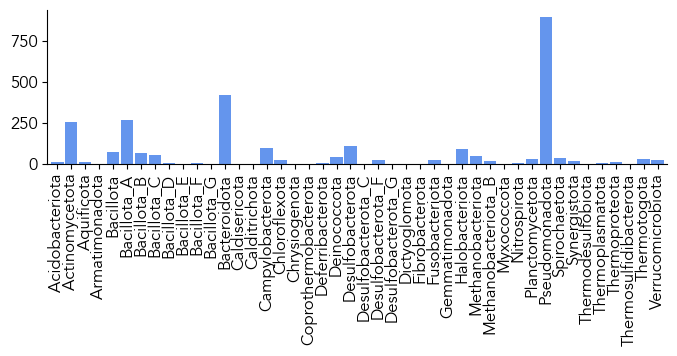

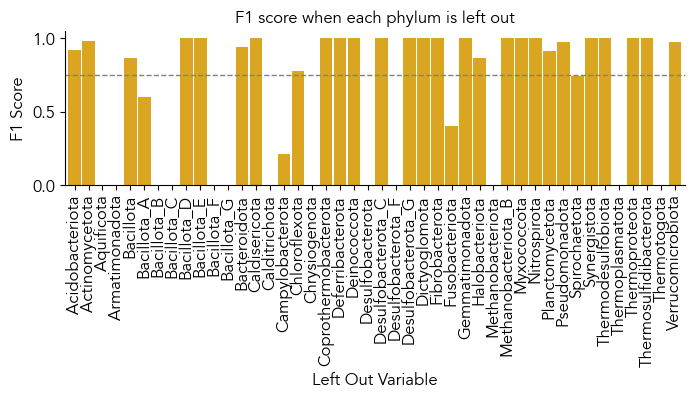

In [99]:
f1_when_left_out = {}
for i, (training_indices, validation_indices) in enumerate(loo_cv_sets):
    taxon = taxa[i]
    
    f1_when_left_out[taxon] = f1_score(y_train[validation_indices], y_valid_pred[validation_indices], zero_division=1)

fig, ax = plt.subplots(figsize=(8,2))
pd.Series(phylum_size).plot.bar(ax=ax, width=0.9, color='cornflowerblue')

fig, ax = plt.subplots(figsize=(8,2))
pd.Series(f1_when_left_out).plot.bar(ax=ax, width=0.9, color='goldenrod')
y_baseline = f1_score(baseline_results[target][rank]['y_train'], baseline_results[target][rank]['y_valid_pred'])
ax.axhline(y_baseline, color='gray', linestyle='--')
#ax.set_ylim([0.6, 0.97])
ax.set_title("F1 score when each phylum is left out")
ax.set_ylabel("F1 Score")
ax.set_xlabel("Left Out Variable")



# looks bad but isn't bad because if 0 aerobes, F1 is 0

Text(0.5, 0, 'GC Content')

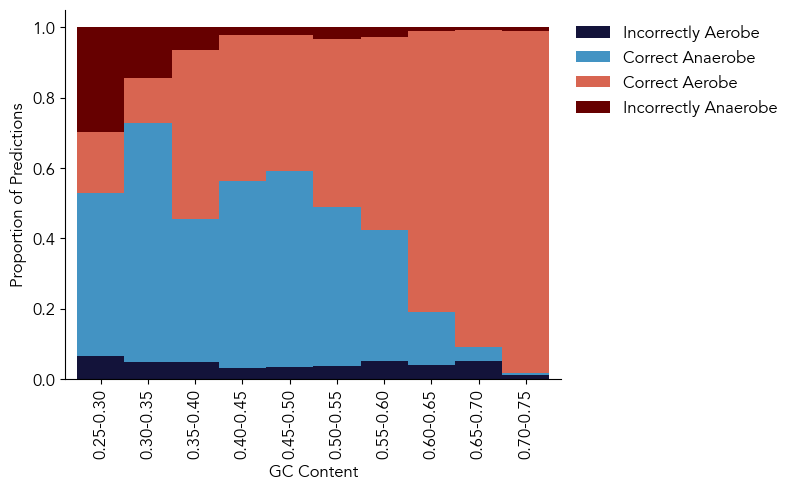

In [100]:
var = 'all_nt_C'
arr, labels = aerobic_predictions_along_range(y_train, y_valid_pred, var=var, bin_min=bin_min, bin_max=bin_max, step=step,float_prec=2, norm=True)
#arr, labels = aerobic_predictions_along_range(y_train, y_valid_pred)

fig ,ax = plt.subplots()
ax = ax_bar_aerobic_predictions(ax, arr,labels , columns, oxygen_colors)
ax.set_xlabel('GC Content')

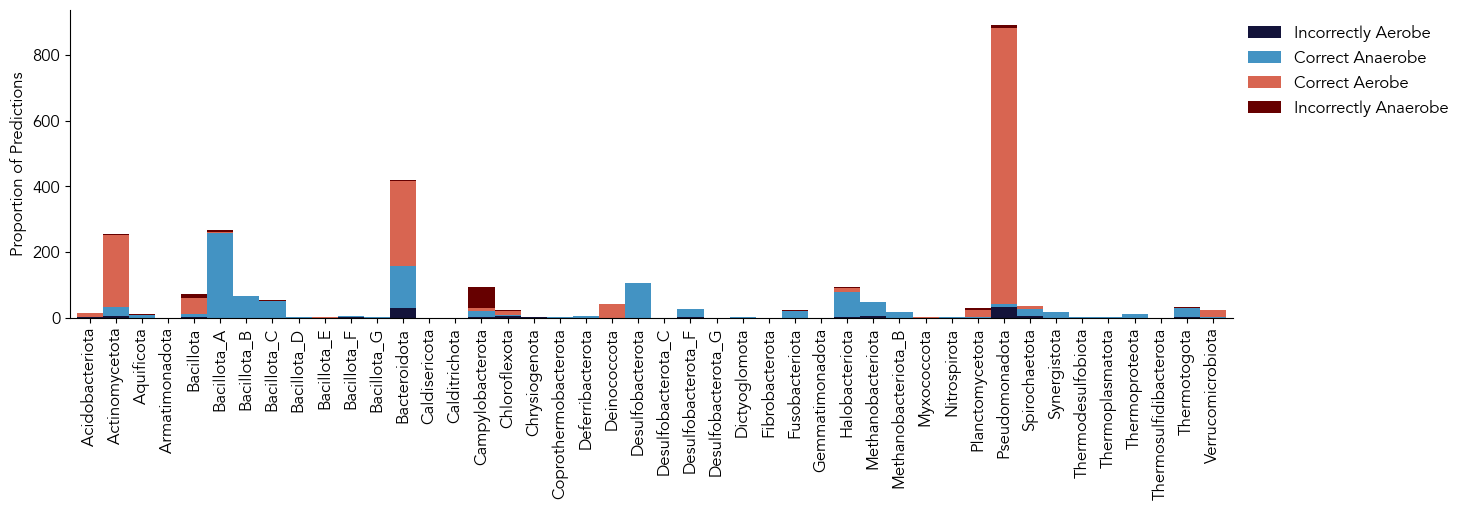

In [101]:
arr, labels = aerobic_predictions_by_taxon(y_train, y_valid_pred, taxon_to_accessions, min_n = 0, norm=False)
arr, labels
fig ,ax = plt.subplots(figsize=(15,4))
ax = ax_bar_aerobic_predictions(ax, arr, labels , columns, oxygen_colors)
#ax.set_xlabel('GC Content')

#### Train on one Phylum

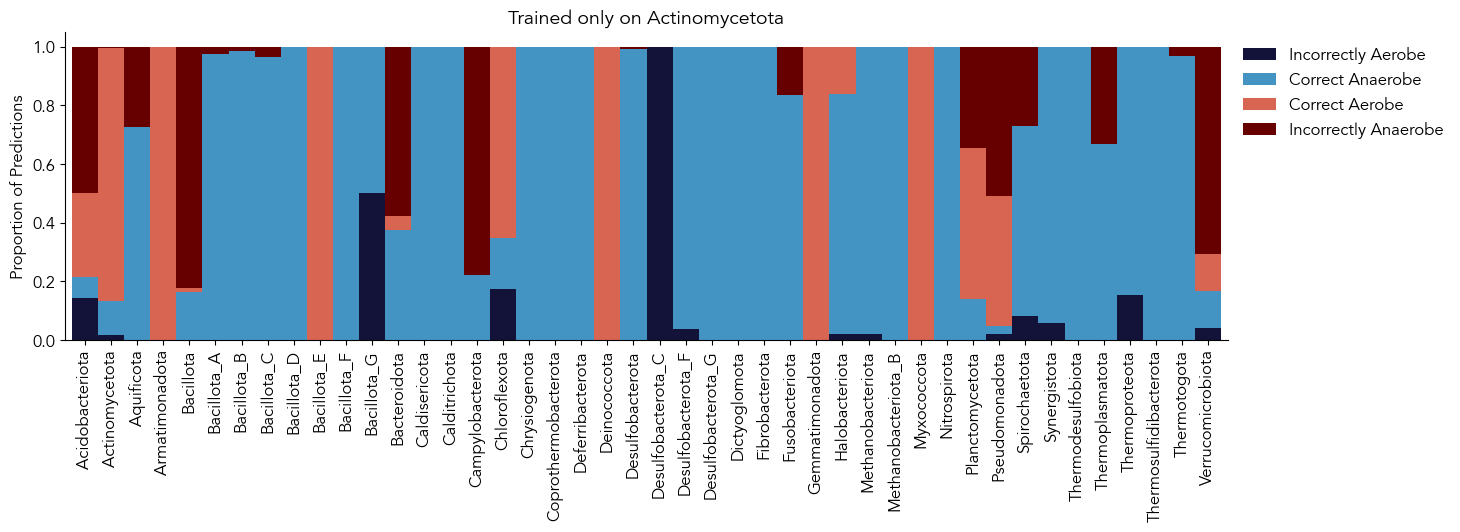

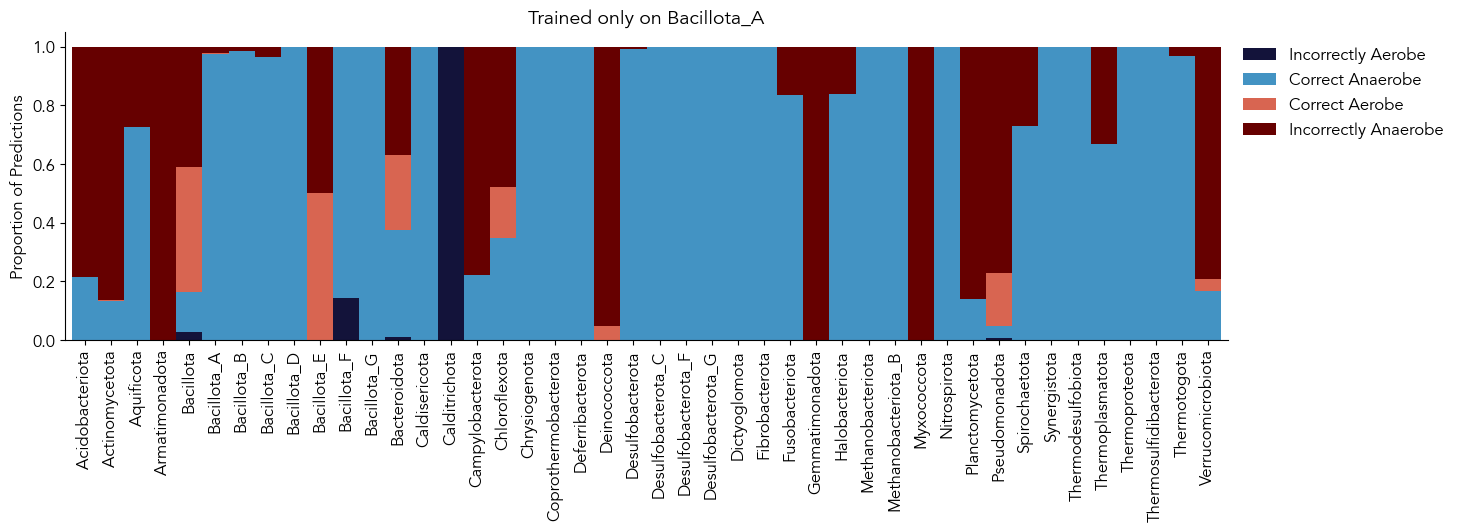

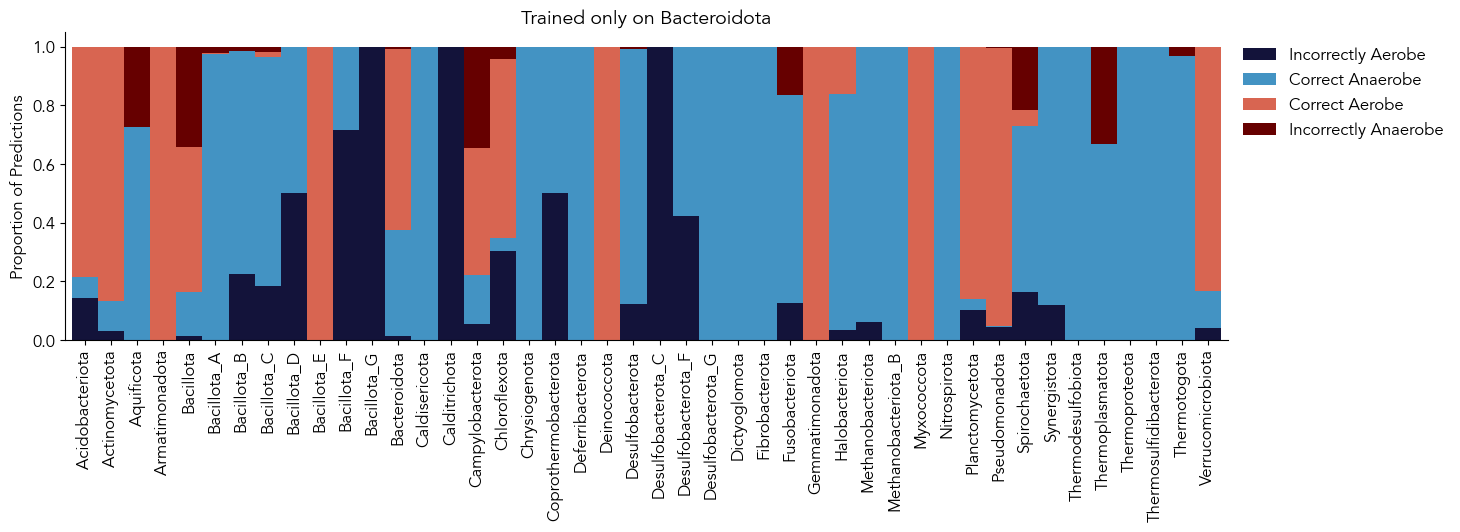

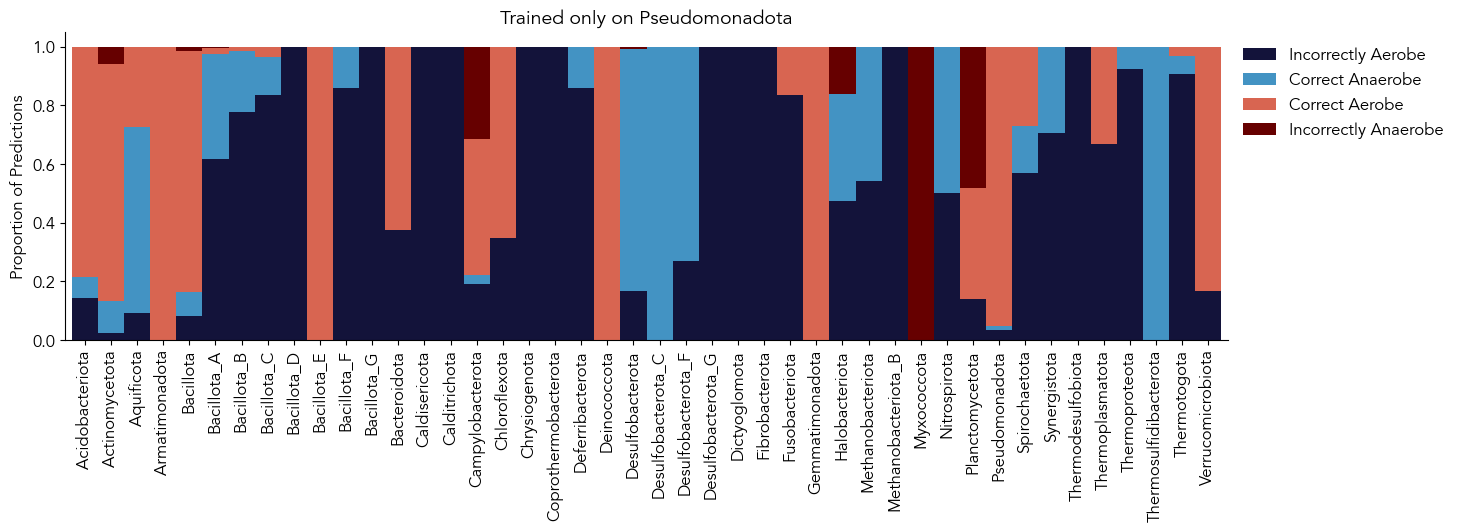

In [102]:
min_training_data = 200

f1_when_trained_on = {}
genome_indices = df_train.index.tolist()
for taxon, accessions in list(sorted(taxon_to_accessions.items())):
    
    validation_set = set(genome_indices).intersection(set(accessions))
    if len(validation_set) >= 20:        
    
        validation_indices = np.in1d(genome_indices, np.array(list(validation_set))).nonzero()[0]
        indices = np.array(range(len(genome_indices)))
        mask = np.ones(indices.shape[0], dtype=bool)
        mask[validation_indices] = False
        training_indices = indices[mask]
        too_cv_set = [(training_indices, validation_indices)]
    
        # flip indices this time
        X_train_too = df_train.iloc[validation_indices][features]
        y_train_too = df_train.iloc[validation_indices][target]
        X_valid_too = df_train.iloc[training_indices][features]
        y_valid_too = df_train.iloc[training_indices][target]
        pipe = make_pipeline(StandardScaler(), LogisticRegression())
        try:
            pipe.fit(X_train_too, y_train_too)
            y_valid_pred_too = pipe.predict(X_valid_too)
            all_true = df_train[target]
            all_pred = pipe.predict(df_train[features])
            all_probs = pipe.predict_proba(df_train[features])
            f1 = f1_score(y_valid_too, y_valid_pred_too)
            f1_when_trained_on[taxon] = f1

        except:
            pass
    
        if len(validation_set) >= min_training_data:
            arr, labels = aerobic_predictions_by_taxon(all_true, all_pred, taxon_to_accessions, min_n = 0, norm=True)
            arr, labels
            fig ,ax = plt.subplots(figsize=(15,4))
            ax = ax_bar_aerobic_predictions(ax, arr, labels , columns, oxygen_colors)
            ax.set_title(f"Trained only on {taxon}", fontsize=14)
            plt.show()


<Axes: xlabel='F1 Score', ylabel='Phylum Trained On'>

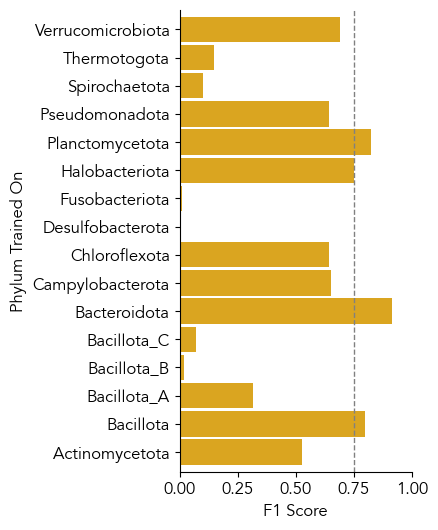

In [103]:
def ax_one_phylum_trained(ax):

    pd.Series(f1_when_trained_on).plot.barh(ax=ax, width=0.9, color='goldenrod')
    y_baseline = f1_score(baseline_results[target][rank]['y_train'], baseline_results[target][rank]['y_valid_pred'])
    ax.axvline(y_baseline, color='gray', linestyle='--')
    ax.set_xlim([0., 1])
    #ax.set_title("F1 Score")
    ax.set_xlabel("F1 Score")
    ax.set_ylabel("Phylum Trained On")
    return ax

fig, ax = plt.subplots(figsize=(3,6))
ax_one_phylum_trained(ax)

In [104]:
pd.Series(f1_when_trained_on)

Actinomycetota       0.526262
Bacillota            0.797900
Bacillota_A          0.314977
Bacillota_B          0.020024
Bacillota_C          0.069864
Bacteroidota         0.915861
Campylobacterota     0.651199
Chloroflexota        0.641026
Desulfobacterota     0.000000
Fusobacteriota       0.008526
Halobacteriota       0.749164
Planctomycetota      0.822270
Pseudomonadota       0.640839
Spirochaetota        0.100467
Thermotogota         0.148832
Verrucomicrobiota    0.691785
dtype: float64

### Randomization

In [105]:
# all data
y_random = np.random.choice(y_train, size=len(y_train), replace=False)
f1_score(y_train, y_random)

0.6057633353770693

0.2370023419203747


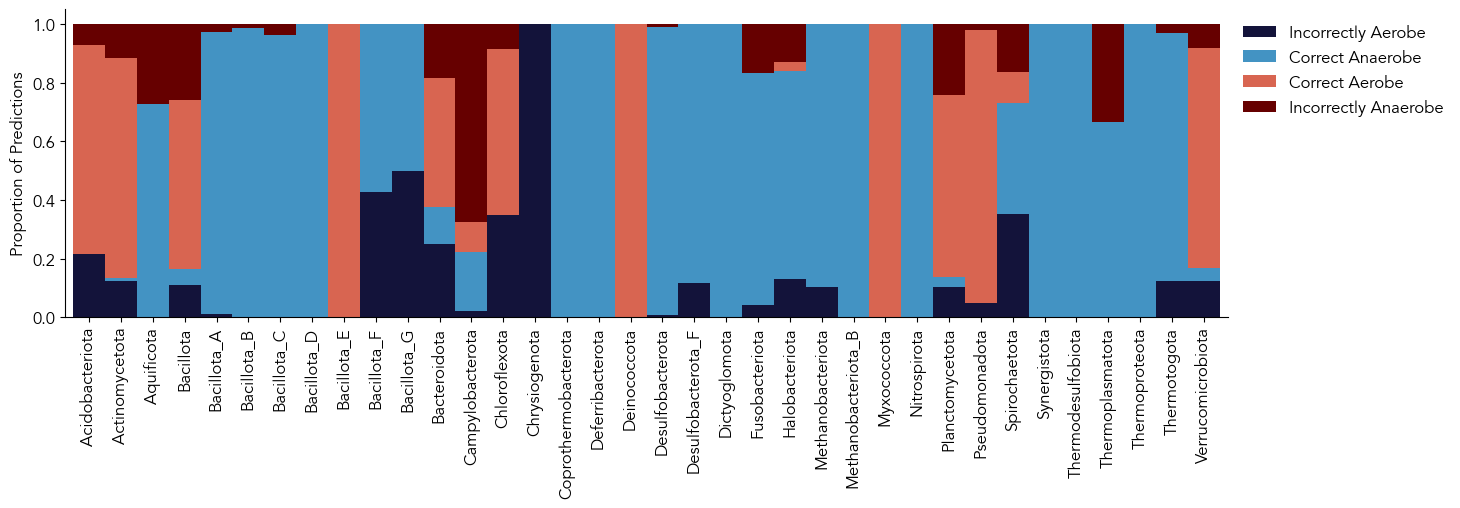

In [106]:
# by phylum
arr, labels = aerobic_predictions_by_taxon(y_train, y_valid_pred, taxon_to_accessions, min_n = 1, norm=False, randomize=True)
f1 = arr_to_f1(arr)
print(f1)
arr, labels = aerobic_predictions_by_taxon(y_train, y_valid_pred, taxon_to_accessions, min_n = 1, norm=True, randomize=True)
arr, labels
fig ,ax = plt.subplots(figsize=(15,4))
ax = ax_bar_aerobic_predictions(ax, arr, labels, columns, oxygen_colors)
#ax.set_title('Random within Phylum')

0.36683238310906063


Text(0.5, 1.0, 'Randomizing within GC bin')

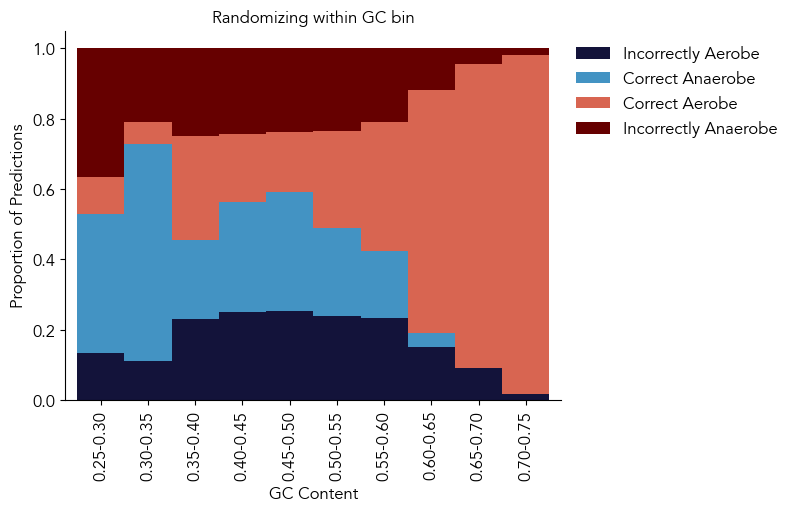

In [107]:
# by GC
var='all_nt_C'
bin_min = bin_defitions[var]['min']
bin_max = bin_defitions[var]['max']
step = bin_defitions[var]['step']
arr, xticklabels = aerobic_predictions_along_range(y_train, y_valid_pred, var=var, bin_min=bin_min, bin_max=bin_max, step=step, norm=True, float_prec=2, randomize=True)

f1 = arr_to_f1(arr)

print(f1)

fig ,ax = plt.subplots()
ax = ax_bar_aerobic_predictions(ax, arr,xticklabels, columns, oxygen_colors, show_proportions=False)
ax.set_xlabel('GC Content')
ax.set_title('Randomizing within GC bin')

## Understanding oxygen prediction

### Facultative anaerobes = aerobes 

In [108]:
condition = target = 'oxygen'
rank = 'family'
train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
df_train = df.loc[train_set]
df_full = df.loc[train_set + test_set]
y_train, y_train_pred, y_valid_pred, y_test, y_test_pred = load_results_from_model_eval_dict(target, rank, taxonomic_model_eval_dict)
y_valid_pred_probs = y_valid_pred[:, 1]
y_valid_pred = 1. * (y_valid_pred_probs > 0.5)
y_test_pred_probs = y_test_pred[:, 1]
y_test_pred = 1. * (y_test_pred_probs > 0.5)
y_full = np.array(list(y_train) + list(y_test))

y_full_pred = np.array(list(y_valid_pred) + list(y_test_pred))

0.9585798816568047 obligate anaerobe
0.9486552567237164 anaerobe
0.825301204819277 microaerophile
0.9803921568627451 facultative aerobe
0.9791666666666666 facultative anaerobe
0.9867416633186018 aerobe
0.9836065573770492 obligate aerobe


<Axes: xlabel='\nProbability Oxygen Tolerant', ylabel='% of Group'>

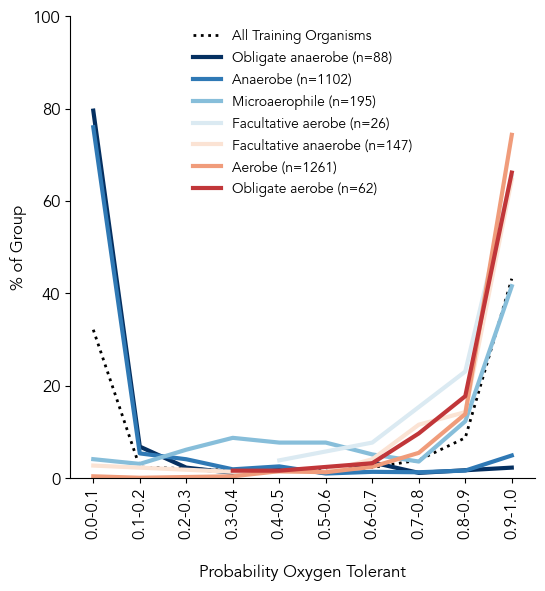

In [109]:
from collections import Counter

def normalize_histogram(values, bins, norm = True):  
    digit_to_bin = dict(zip(range(1, len(bins)+1), list(bins) ))    
    binned_values = np.digitize(sorted(values), bins)
    counts = Counter(binned_values)
    if norm is True:
        counts = {k : v / len(binned_values) for k, v in counts.items()}
    
    binned_ser = pd.Series(counts).sort_index()
    X = binned_ser.index.map(digit_to_bin)
    Y = binned_ser.values
    return X, Y


import matplotlib



def ax_plot_ox_probability_by_group(ax):
    labels = [ 'obligate anaerobe',
          'anaerobe',
 'microaerophile',
 #'aerotolerant', 
 'facultative aerobe',
'facultative anaerobe',
 'aerobe',
 'obligate aerobe'
         ]

    cmap = matplotlib.colormaps.get_cmap('RdBu_r')
    values = y_valid_pred_probs
    bins = np.linspace(0,1,11)
    X, Y = normalize_histogram(values, bins, norm = True)
    
    ax.plot(X+0.05, 100*Y, label='All Training Organisms', color='black', lw=2, alpha=1, linestyle=':')
    
    for n, category in enumerate(labels):
        color = cmap(n/len(labels))
        filter = (df_train[category] == 1)
        if category in ['anaerobe', 'obligate anaerobe']:
            print(f1_score(y_train[filter] < 1, (y_valid_pred_probs < 0.5)[filter]), category)    
        else:
            print(f1_score(y_train[filter] > 0, (y_valid_pred_probs > 0.5)[filter]), category)
        values = y_valid_pred_probs[filter]
        bins = np.linspace(0,1,11)
        X, Y = normalize_histogram(values, bins, norm = True)
        color = cmap(n/len(labels))
        ax.plot(X+0.05, 100*Y, label=f"{category.capitalize()} (n={len(y_valid_pred_probs[filter])})", color=color, lw=3, marker='o', markersize=0)
    
    
    
    ax.set_xticks([np.mean([bins[i], bins[i+1]]) for i in range(10)])
    ax.set_xticklabels([f"{bins[i]:0.1f}-{bins[i+1]:0.1f}" for i in range(10)], rotation=90)
    ax.set_ylabel('% of Group')
    ax.set_xlabel('\nProbability Oxygen Tolerant')
    ax.set_xlim([0,1])
    ax.set_ylim([0,100])
    #ax.legend(bbox_to_anchor=(1,1))
    ax.legend(frameon=False, fontsize=10)
    return ax
fig, ax = plt.subplots(figsize=(6,6))
ax_plot_ox_probability_by_group(ax)

### Bioenergetic cost

In [111]:
heatmap_base_features = BASE_VARS_DERIVED_GENOME + BASE_VARS_DERIVED_PROTEIN + BASE_VARS_PIS + BASE_VARS_AAS
localizations = ['all', 'intracellular_soluble',  'extracellular_soluble',  'membrane', 'diff_extra_intra']

costs = [['A', '11.7'],
 ['C', '24.7'],
 ['D', '12.7'],
 ['E', '15.3'],
 ['F', '52'],
 ['G', '11.7'],
 ['H', '38.3'],
 ['I', '32.3'],
 ['K', '30.3'],
 ['L', '27.3'],
 ['M', '34.3'],
 ['N', '14.7'],
 ['P', '20.3'],
 ['Q', '16.3'],
 ['R', '27.3'],
 ['S', '11.7'],
 ['T', '18.7'],
 ['V', '23.3'],
 ['W', '74.3'],
 ['Y', '50']]

aa_costs = {tup[0] : float(tup[1]) for tup in costs}
aa_costs

target = 'oxygen'
amino_acids = [f'all_aa_{tup[0]}' for tup in aa_costs]

data = df[df[f"use_{target.replace('_optimum', '')}"] == True]
X = data[[target] + amino_acids]
method = 'spearman'
C_all = X.corr(method=method).T

C = C_all.loc[[target], amino_acids].T
# # grab 1 localization at a time
# C_sers = []
# for localization in localizations:
#     ser = C_all.loc[target, prepend_features(heatmap_base_features[::-1], [localization])]
#     ser.index = heatmap_base_features[::-1]
#     C_sers.append(ser)

# C = pd.concat(C_sers, axis=1)
    
C.index = [y.replace('all_aa_', '') for y in C.index]
C['costs'] = C.index.map(aa_costs)
C

oxygen  costs
A  0.340435   11.7
C -0.490382   24.7
D  0.095618   12.7
E -0.378052   15.3
F -0.177149   52.0
G  0.210194   11.7
H  0.377278   38.3
I -0.347202   32.3
K -0.346617   30.3
L  0.303124   27.3
M -0.311122   34.3
N -0.243492   14.7
P  0.300448   20.3
Q  0.298850   16.3
R  0.206979   27.3
S -0.100747   11.7
T  0.275880   18.7
V  0.153559   23.3
W  0.416023   74.3
Y -0.354563   50.0

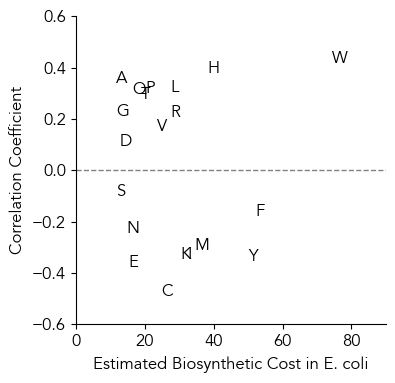

In [112]:


def ax_amino_acid_energy_corrs(ax, C):
    X = C['costs']
    Y = C['oxygen']
    L = C.index
    
    for cost, corr, aa in zip(X,Y,L):
        ax.text(x=cost, y=corr, s=aa, fontsize=12)
    ax.set_xlabel('Estimated Biosynthetic Cost in E. coli')
    ax.set_ylabel('Correlation Coefficient')
    #ax.set_title('Correlation between AA Frequency\nand Oxygen Tolerance,\nvs. Biosynthetic Cost')
    ax.axhline(y=0, linestyle='--', color='gray')
    ax.set_xlim([0,90])
    ax.set_ylim([-0.6,0.6])
    return ax

fig, ax = plt.subplots(figsize=(4,4))

ax = ax_amino_acid_energy_corrs(ax, C)

### Correlation to phyla

In [113]:
# make df:
# for phylum in phyla
# get correlation

genome_indices = df_train.index.tolist() + df_test.index.tolist()
df_oxygen = df.loc[genome_indices, ['oxygen'] + amino_acids]


# Decide which phyla to use
min_reps = 2 # both for aerobes and anaerobes
specific_phyla = []
other_phyla_genomes = []
aerobe_counts = {}
for taxon, accessions in list(sorted(taxon_to_accessions.items())):
    phylum_genomes = set(genome_indices).intersection(set(accessions))
    if len(phylum_genomes) > 0:
        df_genomes = df_oxygen.loc[list(phylum_genomes)]
        counts = dict(df_genomes['oxygen'].value_counts())
        if counts.get(0, -1) > min_reps and counts.get(1, -1) > min_reps:
            specific_phyla.append(taxon)
            aerobe_counts[taxon] = counts
        else:
            other_phyla_genomes.extend(phylum_genomes)

# correlations 
sers = []
for taxon, accessions in list(sorted(taxon_to_accessions.items())):
    if taxon in specific_phyla:
        phylum_genomes = set(genome_indices).intersection(set(accessions))
        corr = df_oxygen.loc[list(phylum_genomes)].corr(method='spearman').loc['oxygen', amino_acids]
        corr.name = taxon
        sers.append(corr)


# for other phyla and all phyla
df_genomes = df_oxygen.loc[list(other_phyla_genomes)]
counts = dict(df_genomes['oxygen'].value_counts())
corr = df_genomes.corr(method='spearman').loc['oxygen', amino_acids]
corr.name = 'Other Phyla'
aerobe_counts[corr.name] = counts
sers.append(corr)

df_genomes = df_oxygen
counts = dict(df_genomes['oxygen'].value_counts())
corr = df_genomes.corr(method='spearman').loc['oxygen', amino_acids]
corr.name = 'All Phyla'
aerobe_counts[corr.name] = counts
sers.append(corr)
# corr = df_phylum.corr(method='spearman').loc['oxygen', amino_acids]
# 
# print(taxon, len(phylum_genomes), counts)


aerobe_counts


aa_corr = pd.concat(sers,axis=1)


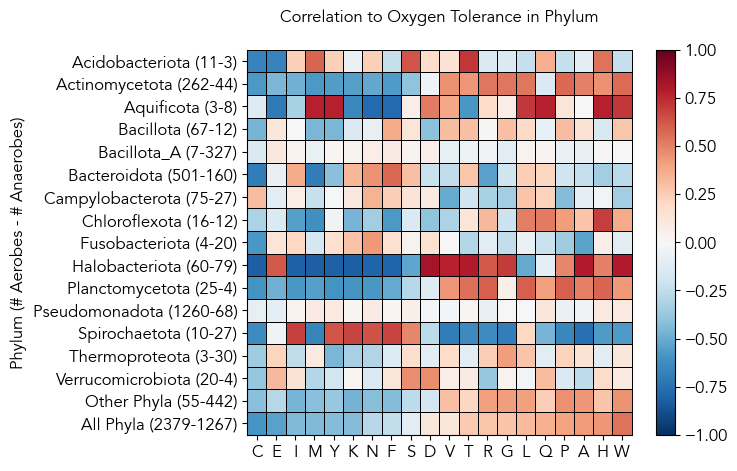

In [159]:

def ax_heatmap_oxygen_aa_corrs(ax, df_corr):

    df_corr = df_corr.sort_values('All Phyla')
    df_plot = df_corr.T[::-1]
    x_variables = df_plot.columns
    x_ticklabels = [rename_vars[var] for var in df_plot.columns]
    y_ticklabels = [f"{var} ({aerobe_counts[var].get(1)}-{aerobe_counts[var].get(0)})" for var in df_plot.index]
    c = ax.pcolormesh(range(len(x_variables)), range(len(y_ticklabels)),  df_plot.values, 
                      cmap='RdBu_r', vmin=-1, vmax=1, edgecolor='black', linewidth=0.5, clip_on=False)
    ax.set_title(plot_formats[target].replace(', Optimum', ''))
    ax.set_xticks(range(len(x_variables)))
    ax.set_yticks(range(len(y_ticklabels)))
    ax.set_xticklabels(x_ticklabels, rotation=0, ha='center')
    ax.set_yticklabels(y_ticklabels)
    ax.set_title('Correlation to Oxygen Tolerance in Phylum\n')
    ax.set_ylabel('Phylum (# Aerobes - # Anaerobes)')
    fig.colorbar(c, ax=ax,  aspect=20)
    return ax
fig, ax = plt.subplots(figsize=(6.2,5))
ax = ax_heatmap_oxygen_aa_corrs(ax, aa_corr)

0.9585798816568047 obligate anaerobe
0.9486552567237164 anaerobe
0.825301204819277 microaerophile
0.9803921568627451 facultative aerobe
0.9791666666666666 facultative anaerobe
0.9867416633186018 aerobe
0.9836065573770492 obligate aerobe


Text(-0.2, 1.0, 'C.')

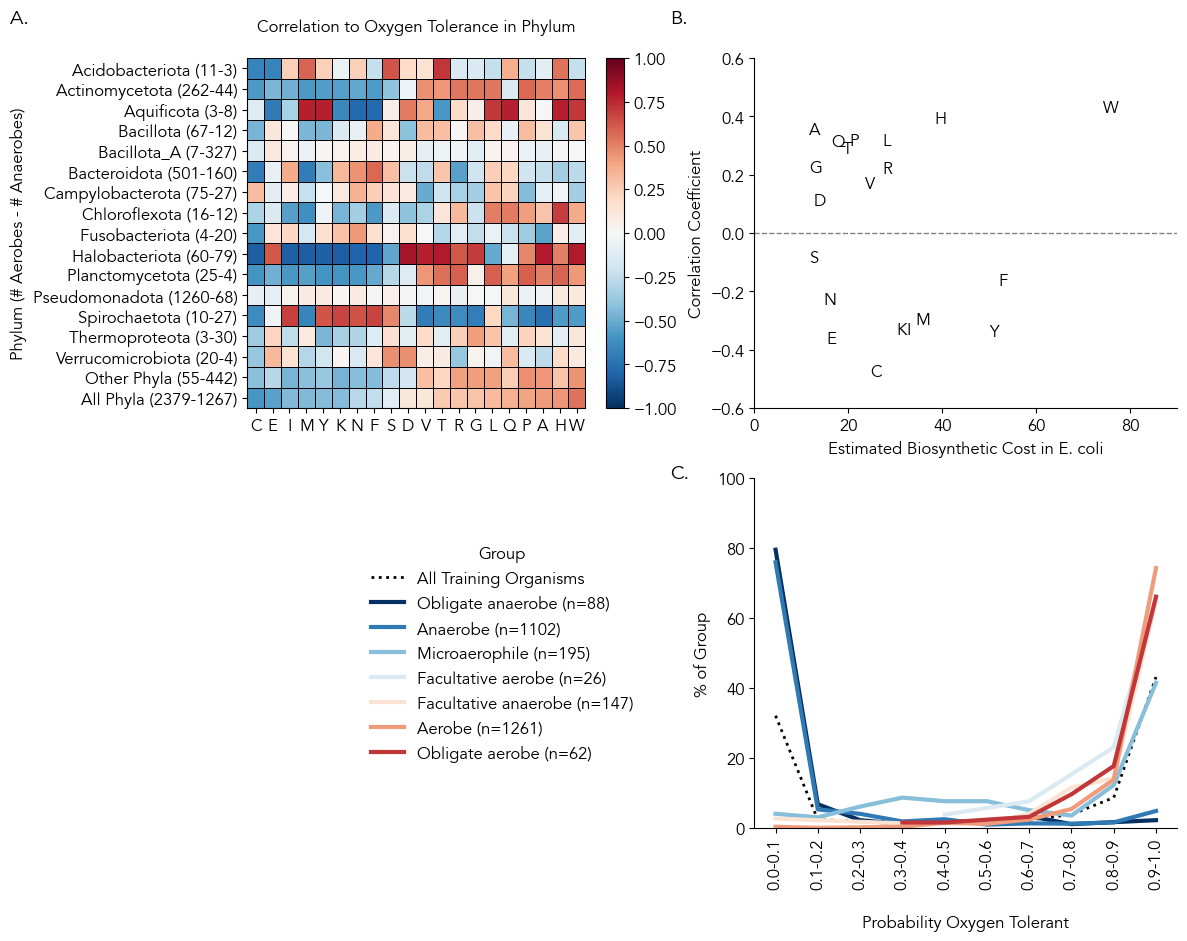

In [162]:
# Supp fig

fig, axes = plt.subplots(2,2, figsize=(12,10))
fig.delaxes(axes[1,0])

ax = axes[0,0]
ax = ax_heatmap_oxygen_aa_corrs(ax, aa_corr)
ax.text(-0.7, 1.1, f"{string.ascii_uppercase[0]}.", transform=ax.transAxes,  size=14)

ax = axes[0,1]
ax = ax_amino_acid_energy_corrs(ax, C)
ax.text(-0.2, 1.1, f"{string.ascii_uppercase[1]}.", transform=ax.transAxes,  size=14)
ax = axes[1,1]
ax = ax_plot_ox_probability_by_group(ax)
ax.legend(bbox_to_anchor=(-0.25,0.85), frameon=False, fontsize=12, title='Group')
ax.text(-0.2, 1., f"{string.ascii_uppercase[2]}.", transform=ax.transAxes,  size=14)
#plt.tight_layout(pad=0.1)

# In-Depth: Temperature, Salinity, pH

## Prepare data

In [116]:
# pipelines for train-validation split, training and saving models
training_instructions = json.loads(open("../models/instructions.json", "r").read())

# Create dataset
condition = 'ph'
rank = 'family'
target = f'{condition}_optimum'

features = training_instructions[condition]['features']
pipeline_filename = PATH_TO_DATA_DIR + training_instructions[condition]['pipeline_filename']
train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
cv_sets = taxonomic_cv_sets_dict[condition][rank]

df_train = df.loc[list(set(train_set).intersection(set(df.index.tolist()))), features + [target]]
df_test = df.loc[list(set(test_set).intersection(set(df.index.tolist()))), features + [target]]
    
df_train.shape

(603, 61)

In [117]:
X_train = df_train[features]
y_train = df_train[target]
y_test = df_test[target]

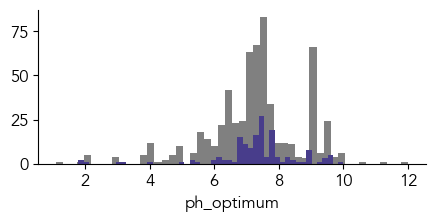

In [118]:
fig, ax = plt.subplots(figsize=(5,2))
hist, bins, _ = ax.hist(y_train.values, bins=50)
hist, bins, _ = ax.hist(y_test.values, bins=50)

ax.set_xlabel(target)
plt.show()

## Linear Regression

In [119]:
# Main model
pipe = joblib.load(pipeline_filename)




# Other models
#pipe = make_pipeline(StandardScaler(), LinearRegression(fit_intercept=True))
#pipe = make_pipeline(StandardScaler(), SelectKBest(k=20), LinearRegression(fit_intercept=True))
#pipe = make_pipeline(StandardScaler(), PCA(n_components=20), LinearRegression(fit_intercept=True))
#pipe = make_pipeline(StandardScaler(), SelectKBest(mutual_info_regression, k=10), LinearRegression(fit_intercept=True))
#pipe = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(int(len(features) * 1/4), 2), random_state=1, max_iter=5000))

pipe, y_train_pred, y_valid_pred = predict_training_and_cv(X_train, y_train, pipeline=pipe, cv=yield_cv_sets(cv_sets))
#pipe, y_train_pred.shape, y_valid_pred.shape, features

(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: title={'center': 'Training\nR$^2$=0.61 RMSE=0.9 corr=0.78 n=603'}, xlabel='True', ylabel='Prediction'>,
         <Axes: title={'center': 'Validation\nR$^2$=0.56 RMSE=1.0 corr=0.75 n=603'}, xlabel='True', ylabel='Prediction'>],
        [<Axes: ylabel='Residual'>, <Axes: ylabel='Residual'>],
        [<Axes: ylabel='Counts'>, <Axes: ylabel='Counts'>]], dtype=object))

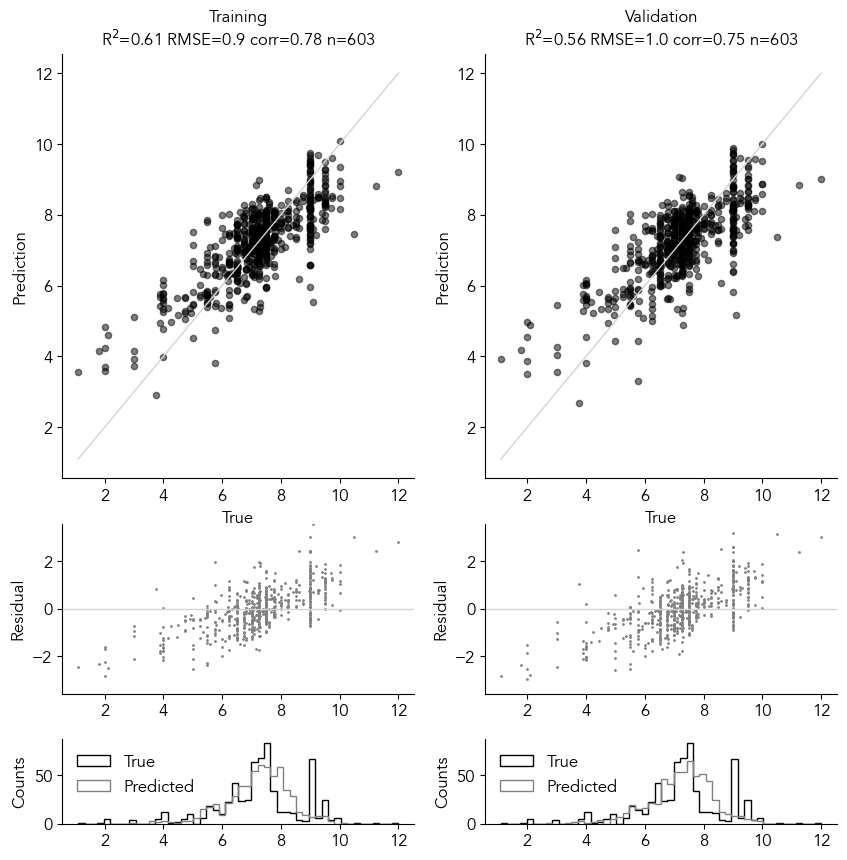

In [120]:
plot_regression_training_validation(y_train, y_train_pred, y_train, y_valid_pred)

In [121]:
SHOW_TEST = False
if SHOW_TEST is True:
    X_test = df_test[features]
    y_test = df_test[target]
    
    y_test_pred = pipe.predict(X_test)
    
    fig, axes = plt.subplots(3,1, figsize=(5,10), gridspec_kw={'height_ratios' : (10,4, 2)})
    
    ax = axes[0]
    ax = ax_regression(ax, y_train, y_valid_pred, title='Valid')
    ax = ax_regression(ax, y_test, y_test_pred, title='Test')
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    
    ax = axes[1]
    ax = ax_residual(ax,  y_test, y_test_pred,)
    ax.set_xlim(xlims)
    abs_diff = np.max(np.abs(y_test - y_test_pred))
    ax.set_ylim([-1 * abs_diff, 1 * abs_diff])
    
    ax = axes[2]
    ax_distribution(ax, y_test, y_test_pred,)
    ax.set_xlim(xlims)
